# Install ptitprince and load libraries

In [5]:
!pip install ptitprince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 41.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ptitprince: filename=ptitprince-0.3.1-py3-none-any.whl size=16216 sha256=e3dfb22d38e63fe9a2ec1811aa619073a5ef0b26ce06ff590965839f073b2eb8
  Stored in directory: /root/.cache/pip/wheels/5d/79/49/b89a41fd3d8780ce2c21c7f2debe45f3c6b08d8aef400e3df1
Successfully built ptitprince


In [6]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 49.6 MB/s eta 0:00:00


#Load Data

combinedFeatures_VegBiomeKoppen_withLatLon_with_countries.csv, combinedFeatures_VegBiomeKoppen_withLatLon_with_countries_global_ns.csv, ne_110m_admin_0_countries.zip

In [2]:
!unzip /content/ne_110m_admin_0_countries.zip

Archive:  /content/ne_110m_admin_0_countries.zip
replace ne_110m_admin_0_countries.README.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!cp urbanRural_VegBiomeKoppen_withLatLon_with_countries_global_ns.csv /content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries_global_ns.csv
!cp urbanRural_VegBiomeKoppen_withLatLon_with_countries.csv /content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries.csv

#Maps


###urban

In [7]:
from __future__ import annotations
import math
import sys
from pathlib import Path
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

# ────────────────────────── CONFIG ──────────────────────────

CSV_PATH = Path("/content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries_global_ns.csv")
SAVE_DIR = "/content/ns_outputs_global"   # None → do not write file
TOP_N    = 1000

URBAN_AREA_COL = "Urban_Area"
RURAL_AREA_CANDIDATES = ["Buffer_area", "Rural_Area"]  # try in this order

# Component classes for explicit rows
VEG_COMPONENTS = {
    "Tree cover": (
        ["tree_cover_area_urban"],
        ["tree_cover_area_rural"],
    ),
    "Grassland": (
        ["grassland_area_urban"],
        ["grassland_area_rural"],
    ),
    "Cropland": (
        ["cropland_area_urban"],
        ["cropland_area_rural"],
    ),
    "Shrubland": (
        ["shrubland_area_urban"],
        ["shrubland_area_rural"],
    ),
}

# For "Vegetation Fraction" (all veg combined)
ALL_VEG_URBAN = [
    "tree_cover_area_urban",
    "grassland_area_urban",
    "cropland_area_urban",
    "shrubland_area_urban",
    "herbaceous_wetland_area_urban",
    "mangroves_area_urban",
    "moss_and_lichen_area_urban",
]
ALL_VEG_RURAL = [
    "tree_cover_area_rural",
    "grassland_area_rural",
    "cropland_area_rural",
    "shrubland_area_rural",
    "herbaceous_wetland_area_rural",
    "mangroves_area_rural",
    "moss_and_lichen_area_rural",
]

ROW_ORDER = ["Vegetation Fraction", "Tree cover", "Grassland", "Cropland", "Shrubland"]
COHORT_ORDER = ["Major cities", "All cities"]  # Major first, then All

# ────────────────────────── HELPERS ──────────────────────────

def _coerce_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def _pick_rural_area_col(df: pd.DataFrame) -> str:
    for c in RURAL_AREA_CANDIDATES:
        if c in df.columns:
            return c
    raise KeyError(f"None of {RURAL_AREA_CANDIDATES} found as rural area column.")

def _kish_weighted_mean_se(x: pd.Series, w: pd.Series) -> Tuple[float, float]:
    """
    Kish-weighted mean & SE:
      μ_w   = Σ w x / Σ w
      Var_w = Σ w (x - μ_w)^2 / Σ w
      n_eff = (Σ w)^2 / Σ w^2
      SE_w  = sqrt(Var_w / n_eff)
    """
    x = _coerce_num(x)
    w = _coerce_num(w)
    m = x.notna() & w.notna() & np.isfinite(x) & np.isfinite(w) & (w > 0)
    x = x[m].to_numpy(dtype=float)
    w = w[m].to_numpy(dtype=float)

    if x.size == 0:
        return (np.nan, np.nan)

    W = float(w.sum())
    if W <= 0:
        return (np.nan, np.nan)

    mu_w = float(np.dot(w, x) / W)

    if x.size == 1:
        return (mu_w, np.nan)

    var_w = float(np.dot(w, (x - mu_w) ** 2) / W)
    w2 = float(np.dot(w, w))
    if w2 <= 0 or not np.isfinite(var_w):
        return (mu_w, np.nan)

    n_eff = (W * W) / w2
    if n_eff <= 0 or not np.isfinite(n_eff):
        return (mu_w, np.nan)

    se_w = float(math.sqrt(var_w / n_eff))
    return (mu_w, se_w)

def _mean_se(x: pd.Series) -> Tuple[float, float]:
    x = _coerce_num(x).dropna()
    n = x.size
    if n == 0:
        return (np.nan, np.nan)
    mu = float(x.mean())
    se = float(x.std(ddof=1) / math.sqrt(n)) if n > 1 else np.nan
    return (mu, se)

def _paired_stats(u_frac: pd.Series, r_frac: pd.Series) -> Tuple[float, float, float, int]:
    """
    From aligned urban & rural fractions:
      Returns (Δ, d_cohen, p_wilcoxon, n)
      NOTE: rank-biserial r is computed separately from the same diff.
    """
    u = _coerce_num(u_frac)
    r = _coerce_num(r_frac)
    m = u.notna() & r.notna() & np.isfinite(u) & np.isfinite(r)
    d = (u[m] - r[m]).to_numpy(dtype=float)
    n = int(d.size)

    if n == 0:
        return (np.nan, np.nan, np.nan, 0)

    delta = float(d.mean())

    # Cohen's d: paired = mean(diff)/sd(diff)
    if n > 1:
        sd = float(d.std(ddof=1))
        d_cohen = float(delta / sd) if (sd > 0 and np.isfinite(sd)) else np.nan
    else:
        d_cohen = np.nan

    # Wilcoxon signed-rank on non-zero differences
    try:
        d_nz = d[d != 0]
        if d_nz.size == 0:
            p = np.nan
        else:
            res = wilcoxon(
                d_nz,
                zero_method="wilcox",
                alternative="two-sided",
                mode="auto",
            )
            p = float(res.pvalue)
    except Exception:
        p = np.nan

    return (delta, d_cohen, p, n)

def _rank_biserial_from_diff(diff: pd.Series) -> float:
    """
    Paired rank-biserial for Urban − Rural:

        r_rb = (R_pos − R_neg) / (R_pos + R_neg)

    based on Wilcoxon signed-rank logic (ranks of |diff|, zeros excluded).
    """
    d = _coerce_num(diff)
    d = d[d != 0].dropna()
    n = int(d.size)
    if n == 0:
        return float("nan")

    ranks = d.abs().rank(method="average")
    R_pos = float(ranks[d > 0].sum())
    R_neg = float(ranks[d < 0].sum())
    R_tot = R_pos + R_neg
    if R_tot <= 0:
        return float("nan")

    return float((R_pos - R_neg) / R_tot)

def _pct_diff_breakdown(u_frac: pd.Series, r_frac: pd.Series) -> Tuple[float, float, float]:
    """
    From paired diff = Urban − Rural, compute:
      % U>R  = 100 * share(diff > 0)
      % U==R = 100 * share(diff == 0)
      % R>U  = 100 * share(diff < 0)
    """
    u = _coerce_num(u_frac)
    r = _coerce_num(r_frac)
    m = u.notna() & r.notna() & np.isfinite(u) & np.isfinite(r)
    if not m.any():
        return (np.nan, np.nan, np.nan)
    d = (u[m] - r[m]).to_numpy(dtype=float)
    n = float(d.size)
    if n == 0:
        return (np.nan, np.nan, np.nan)
    pct_ugt = float((d > 0).sum() * 100.0 / n)
    pct_ueq = float((d == 0).sum() * 100.0 / n)
    pct_rgt = float((d < 0).sum() * 100.0 / n)
    return pct_ugt, pct_ueq, pct_rgt

def _build_fraction_pairs(df: pd.DataFrame) -> Dict[str, Tuple[pd.Series, pd.Series]]:
    """
    Given a cohort-specific df with Rural_Area_eff defined,
    construct (frac_urban, frac_rural) for:
      - Vegetation Fraction (all veg combined)
      - Tree cover, Grassland, Cropland, Shrubland
    """
    pairs: Dict[str, Tuple[pd.Series, pd.Series]] = {}

    # Vegetation Fraction
    if not set(ALL_VEG_URBAN).issubset(df.columns) or not set(ALL_VEG_RURAL).issubset(df.columns):
        raise KeyError("Missing ALL_VEG_* columns for combined Vegetation Fraction.")

    tot_u = df[ALL_VEG_URBAN].apply(_coerce_num).sum(axis=1, min_count=1)
    tot_r = df[ALL_VEG_RURAL].apply(_coerce_num).sum(axis=1, min_count=1)

    frac_u_all = tot_u / df[URBAN_AREA_COL]
    frac_r_all = tot_r / df["Rural_Area_eff"]
    pairs["Vegetation Fraction"] = (frac_u_all, frac_r_all)

    # Individual components
    for label, (u_cols, r_cols) in VEG_COMPONENTS.items():
        missing_u = [c for c in u_cols if c not in df.columns]
        missing_r = [c for c in r_cols if c not in df.columns]
        if missing_u or missing_r:
            continue

        u_area = df[u_cols].apply(_coerce_num).sum(axis=1, min_count=1)
        r_area = df[r_cols].apply(_coerce_num).sum(axis=1, min_count=1)

        fu = u_area / df[URBAN_AREA_COL]
        fr = r_area / df["Rural_Area_eff"]
        pairs[label] = (fu, fr)

    return pairs

def _fmt(v, col=None):
    if v is None:
        return ""
    if isinstance(v, (float, np.floating)):
        if not np.isfinite(v):
            return ""
        if col and col.startswith("% U"):
            return f"{v:.2f}"
        return f"{v:.4f}"
    if isinstance(v, (int, np.integer)):
        return f"{v}"
    return str(v)

# ────────────────────────── MAIN LOGIC ──────────────────────────

def main():
    try:
        if not CSV_PATH.is_file():
            print(f"[ERROR] CSV not found: {CSV_PATH}", file=sys.stderr)
            sys.exit(1)

        df = pd.read_csv(CSV_PATH, low_memory=False)

        if URBAN_AREA_COL not in df.columns:
            raise ValueError(f"Missing required column: {URBAN_AREA_COL}")

        rural_area_col = _pick_rural_area_col(df)

        df[URBAN_AREA_COL] = _coerce_num(df[URBAN_AREA_COL])
        df[rural_area_col] = _coerce_num(df[rural_area_col])

        # Filter valid areas
        df = df[(df[URBAN_AREA_COL] > 0) & (df[rural_area_col] > 0)].copy()
        if df.empty:
            raise ValueError("No rows with positive Urban_Area and Rural_Area.")

        df["Rural_Area_eff"] = df[rural_area_col]

        print(f"[OK] Loaded {df.shape[0]:,} rows × {df.shape[1]:,} cols after cleaning.")
        print(f"[INFO] Using '{rural_area_col}' as rural/buffer area column.")

        df_all = df.copy()
        top_n = min(TOP_N, df.shape[0])
        df_top = df.nlargest(top_n, URBAN_AREA_COL, keep="all").copy()
        have_top = not df_top.empty
        if have_top:
            print(f"[OK] Major cities (TOP_{TOP_N}): {df_top.shape[0]:,} rows.")
        else:
            print(f"[WARN] TOP_{TOP_N} subset empty; only All cities will be reported.")

        rows: List[Dict] = []
        cohorts = [
            ("Major cities", df_top if have_top else pd.DataFrame()),
            ("All cities", df_all),
        ]

        for cohort_label, dfx in cohorts:
            if dfx.empty:
                continue

            frac_pairs = _build_fraction_pairs(dfx)

            for var_name in ROW_ORDER:
                if var_name not in frac_pairs:
                    continue

                f_u, f_r = frac_pairs[var_name]

                mask = (
                    f_u.notna() & f_r.notna() &
                    np.isfinite(f_u) & np.isfinite(f_r)
                )
                if not mask.any():
                    continue

                fu = f_u[mask]
                fr = f_r[mask]
                w_urban = dfx.loc[mask, URBAN_AREA_COL]
                w_rural = dfx.loc[mask, "Rural_Area_eff"]

                # Unweighted
                urb_mu, urb_se = _mean_se(fu)
                rur_mu, rur_se = _mean_se(fr)

                # Weighted
                urb_muw, urb_sew = _kish_weighted_mean_se(fu, w_urban)
                rur_muw, rur_sew = _kish_weighted_mean_se(fr, w_rural)

                # Paired stats (Δ, d, p, n)
                delta, d_cohen, p_val, n = _paired_stats(fu, fr)

                # Rank-biserial from paired differences
                diff = fu - fr
                r_rb = _rank_biserial_from_diff(diff)

                # Weighted Δw
                delta_w = (
                    float(urb_muw - rur_muw)
                    if np.isfinite(urb_muw) and np.isfinite(rur_muw)
                    else np.nan
                )

                # % U>R, % U==R, % R>U
                pct_ugt, pct_ueq, pct_rgt = _pct_diff_breakdown(fu, fr)

                rows.append({
                    "Variable": var_name,
                    "Cohort": cohort_label,
                    "Urban μ": urb_mu,
                    "Urban SE": urb_se,
                    "Urban μw": urb_muw,
                    "Urban SEw": urb_sew,
                    "Rural μ": rur_mu,
                    "Rural SE": rur_se,
                    "Rural μw": rur_muw,
                    "Rural SEw": rur_sew,
                    "Δ": delta,
                    "Δw": delta_w,
                    "Cohen's d": d_cohen,
                    "Rank-biserial r": r_rb,
                    "p-value": p_val,
                    "% U>R": pct_ugt,
                    "% U==R": pct_ueq,
                    "% R>U": pct_rgt,
                    "n": n,
                })

        if not rows:
            raise RuntimeError("No summary rows produced. Check input columns and config.")

        summary_df = pd.DataFrame(rows)

        summary_df["Variable"] = pd.Categorical(summary_df["Variable"],
                                                categories=ROW_ORDER,
                                                ordered=True)
        summary_df["Cohort"] = pd.Categorical(summary_df["Cohort"],
                                              categories=COHORT_ORDER,
                                              ordered=True)
        summary_df = summary_df.sort_values(["Variable", "Cohort"]).reset_index(drop=True)

        float_cols_4 = [
            "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
            "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
            "Δ", "Δw",
            "Cohen's d", "Rank-biserial r",
            "p-value",
        ]
        pct_cols = ["% U>R", "% U==R", "% R>U"]

        for c in float_cols_4:
            if c in summary_df.columns:
                summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(4)

        for c in pct_cols:
            if c in summary_df.columns:
                summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(2)

        print("\n=== GLOBAL URBAN vs RURAL VEGETATION FRACTIONS (Major cities then All cities) ===")
        fmt_map = {col: (lambda v, _c=col: _fmt(v, col=_c)) for col in summary_df.columns}
        print(summary_df.to_string(index=False, formatters=fmt_map))

        print("\n=== SUMMARY TABLE CSV (copy/paste) ===")
        print(summary_df.to_csv(index=False, float_format="%.4f", na_rep=""))

        if SAVE_DIR:
            out_dir = Path(SAVE_DIR)
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / "T1_main.csv"
            summary_df.to_csv(out_path, index=False, float_format="%.4f", na_rep="")
            print(f"[OK] Saved: {out_path}")

    except (FileNotFoundError, KeyError, ValueError, RuntimeError) as e:
        print(f"[ERROR] {e}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"[ERROR] Unexpected failure: {e.__class__.__name__}: {e}", file=sys.stderr)
        raise

if __name__ == "__main__":
    main()


[OK] Loaded 83,102 rows × 34 cols after cleaning.
[INFO] Using 'Buffer_area' as rural/buffer area column.
[OK] Major cities (TOP_1000): 1,000 rows.

=== GLOBAL URBAN vs RURAL VEGETATION FRACTIONS (Major cities then All cities) ===
           Variable       Cohort Urban μ Urban SE Urban μw Urban SEw Rural μ Rural SE Rural μw Rural SEw       Δ      Δw Cohen's d Rank-biserial r p-value % U>R % U==R   % R>U     n
Vegetation Fraction Major cities  0.3298   0.0059   0.3433    0.0114  0.6658   0.0054   0.6597    0.0101 -0.3360 -0.3164   -2.0551         -0.9855  0.0000  4.30   0.00 95.7000  1000
Vegetation Fraction   All cities  0.4479   0.0008   0.3754    0.0056  0.7237   0.0007   0.6881    0.0044 -0.2758 -0.3127   -1.5985         -0.9608  0.0000  6.33   0.11 93.5600 83102
         Tree cover Major cities  0.1958   0.0052   0.2133    0.0098  0.2778   0.0063   0.2991    0.0117 -0.0820 -0.0858   -0.6371         -0.6516  0.0000 27.20   0.00 72.8000  1000
         Tree cover   All cities  0.1987 

Original number of cities with valid data: 83102
Analyzing the 1000 largest cities by urban area.


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


Map saved to -> /content/Fig1A_map.pdf


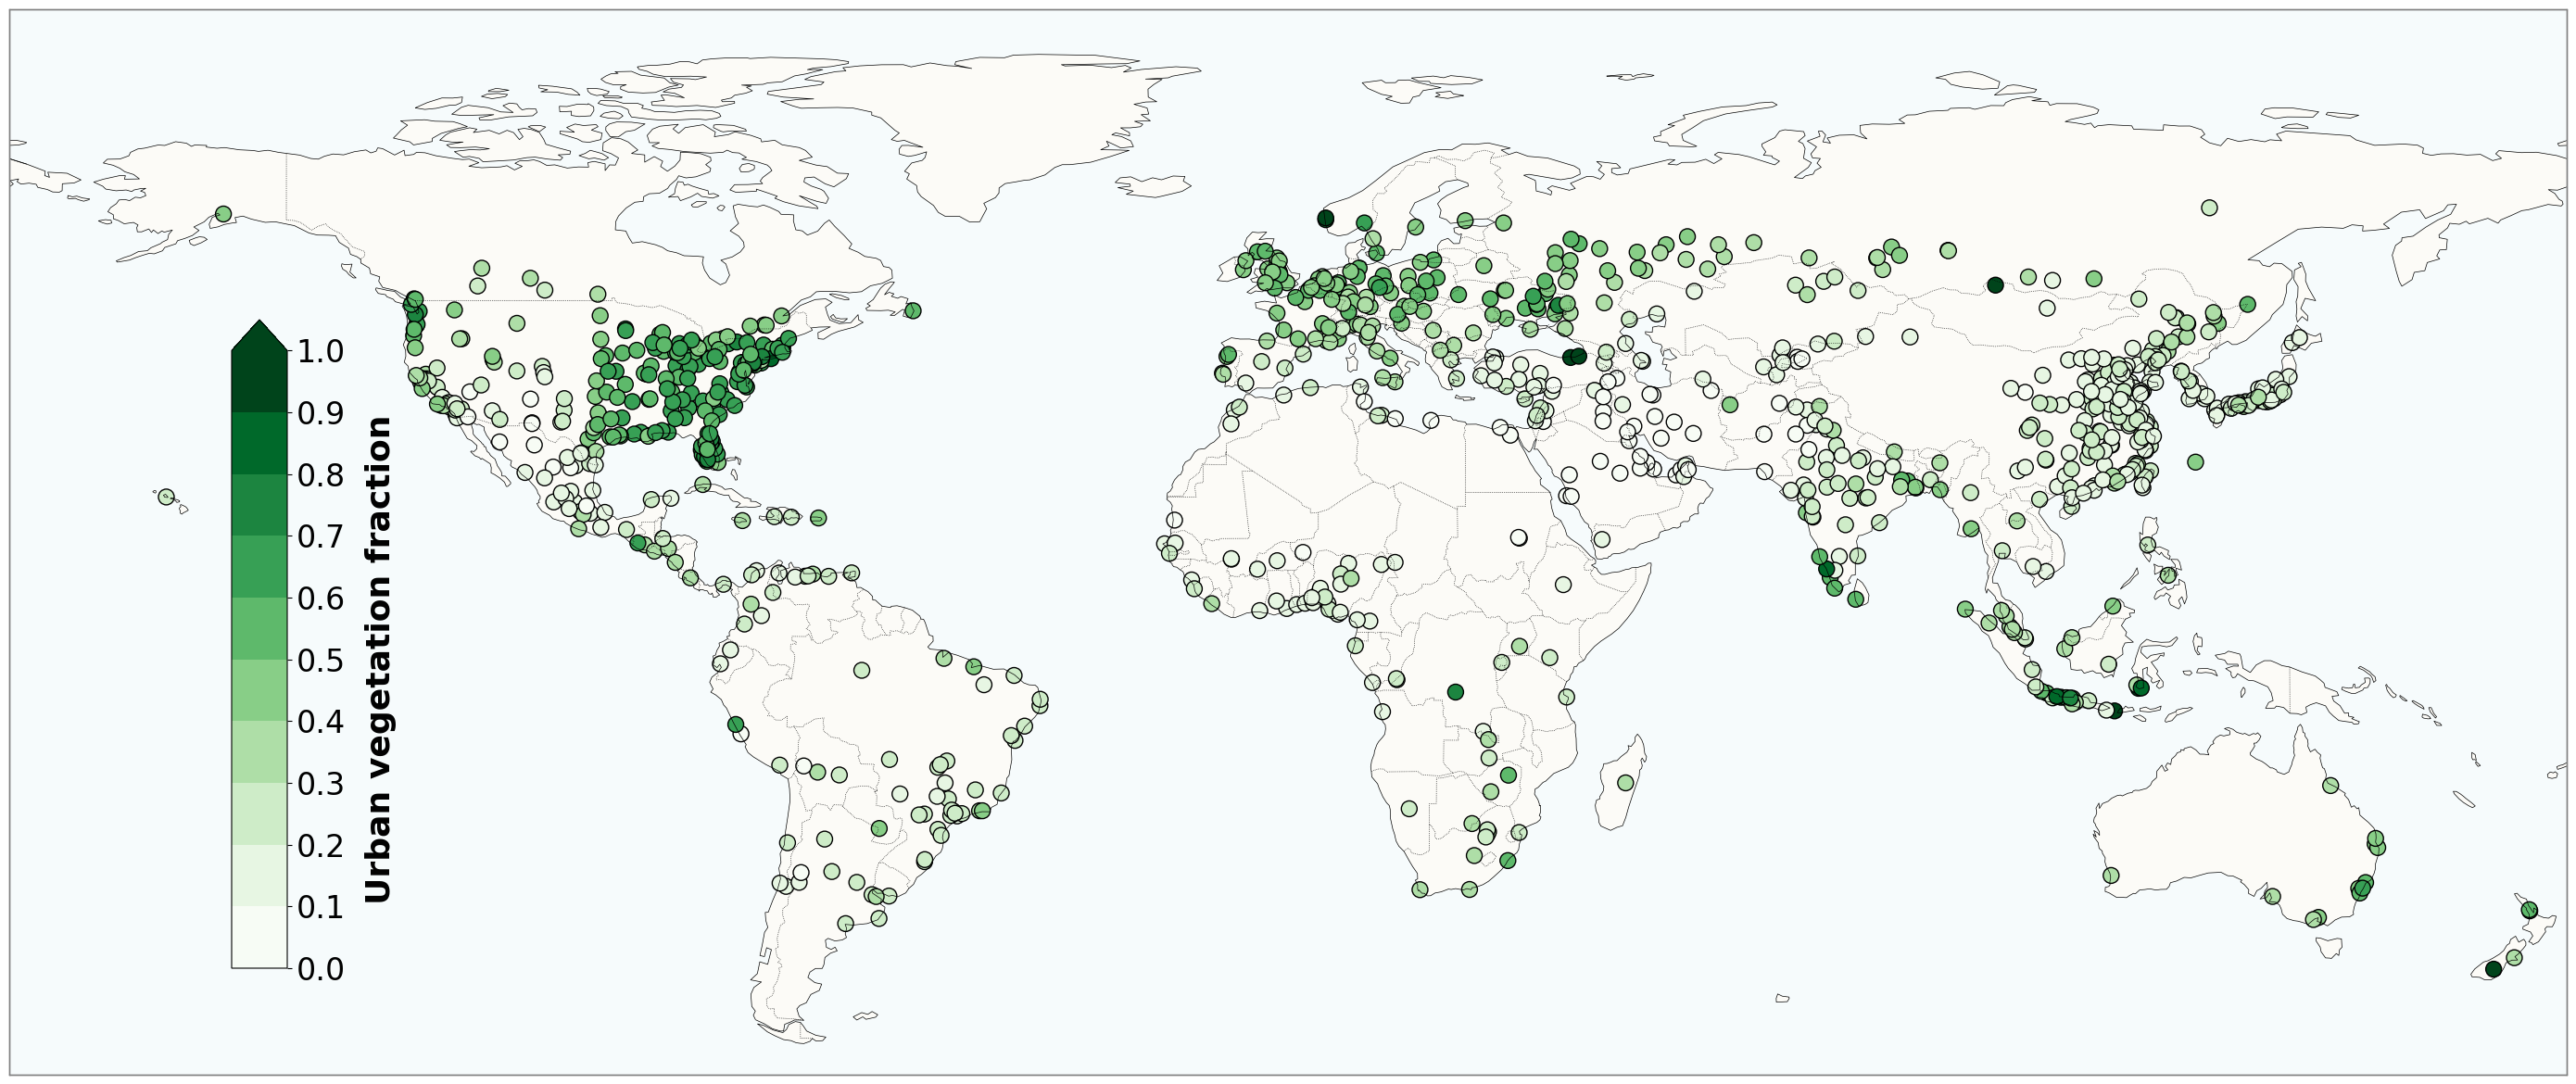

Histogram saved to -> /content/Fig1A_hist.pdf


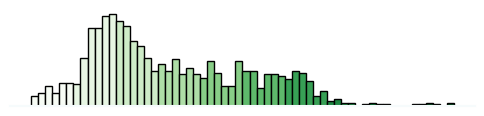

In [8]:
# ------------------------------------------------------------------
# STEP 1: IMPORTS
# ------------------------------------------------------------------
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable

# ------------------------------------------------------------------
# STEP 2: CONFIGURATION
# ------------------------------------------------------------------
# Paths should be adjusted to your environment.
CSV_PATH        = Path('/content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries.csv')

# Outputs will be saved in the specified directory.
OUT_DIR         = Path('/content/')
OUT_MAP         = '/content/Fig1A_map.pdf'
OUT_HIST        = '/content/Fig1A_hist.pdf'

# --- Parameters ---
NUM_COLOR_BINS   = 10 # Number of distinct color classes on the map
NUM_HIST_BINS    = 60 # Number of bins for the smaller histogram

# A sequential green colormap suitable for total vegetation data.
SEQUENTIAL_CMAP = plt.cm.Greens

# ------------------------------------------------------------------
# 1. LOAD CSV + CALCULATE TOTAL URBAN VEGETATION FRACTION
# ------------------------------------------------------------------
if not CSV_PATH.is_file():
    raise FileNotFoundError(f"ERROR: CSV not found -> {CSV_PATH}")

df = pd.read_csv(CSV_PATH, low_memory=False)

# Define all urban vegetation columns
urban_cols = [
    "cropland_area_urban", "grassland_area_urban", "herbaceous_wetland_area_urban",
    "mangroves_area_urban", "moss_and_lichen_area_urban", "shrubland_area_urban",
    "tree_cover_area_urban"
]
# Define all columns required for the analysis
REQ = urban_cols + ["Urban_Area", "lat", "lon", "water_percentage"]

missing = [c for c in REQ if c not in df.columns]
if missing:
    raise ValueError(f"ERROR: missing column(s) {missing!r} in CSV")

# Coerce data to numeric, turning errors into Not-a-Number (NaN)
for col in REQ:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where essential data is missing
df.dropna(subset=REQ, inplace=True)

# Filter out cities with zero urban area to avoid division by zero
df = df[df["Urban_Area"] > 0].copy()

# Calculate the fraction of urban area covered by ALL vegetation types
df['veg_urban_frac'] = df[urban_cols].sum(axis=1) / df['Urban_Area']


# ------------------------------------------------------------------
# 2. FILTER FOR LARGEST 1000 CITIES
# ------------------------------------------------------------------
print(f"Original number of cities with valid data: {len(df)}")
df_top1000 = df.nlargest(1000, 'Urban_Area').copy()
print(f"Analyzing the {len(df_top1000)} largest cities by urban area.")


# ------------------------------------------------------------------
# 3. CREATE DISCRETE SEQUENTIAL COLOUR SCALE (0-1, 10 Classes)
# ------------------------------------------------------------------
# Set a fixed 0 to 1 scale
vmin = 0.0
vmax = 1.0

# Create discrete boundaries for the 10 color bins
bounds = np.linspace(vmin, vmax, NUM_COLOR_BINS + 1)
norm   = BoundaryNorm(bounds, ncolors=SEQUENTIAL_CMAP.N, clip=True)


# ------------------------------------------------------------------
# 4. CITY SCATTER MAP
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, facecolor='#fcfbf7')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')

# Make plot border black
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('grey')
    spine.set_linewidth(1)

# Scatter plot of the top 1000 cities
scatter = ax.scatter(
    df_top1000['lon'],
    df_top1000['lat'],
    c=df_top1000['veg_urban_frac'], # Color based on ALL vegetation
    cmap=SEQUENTIAL_CMAP,
    norm=norm,
    s=150,
    alpha=1,
    edgecolors='black',
    linewidths=1,
    transform=ccrs.PlateCarree()
)


ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())


# --- Color Bar ---
cbar_ax = fig.add_axes([0.13, 0.27, 0.02, 0.35])
sm = ScalarMappable(norm=norm, cmap=SEQUENTIAL_CMAP)
sm.set_array([]) # You must set the array for the scalar mappable
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label('Urban vegetation fraction', fontsize=26, labelpad=15, fontweight='bold')

# Set ticks to the calculated bin edges for clarity
cbar.set_ticks(bounds)
cbar.set_ticklabels([f'{b:.1f}' for b in bounds]) # Use .1f for 0.0, 0.1, etc.
cbar.ax.tick_params(labelsize=24)


plt.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.05)
plt.savefig(OUT_MAP, bbox_inches='tight', format='pdf', transparent=True)
print(f"Map saved to -> {OUT_MAP}")
plt.show()

# ------------------------------------------------------------------
# 5. MINIMALIST HISTOGRAM
# ------------------------------------------------------------------
def minimalist_hist(series: pd.Series, bounds_arr, bins, cmap_obj, path):
    """Creates a minimalist histogram with bars colored by value."""
    # Use the same normalization as the map for visual consistency
    norm_hist = BoundaryNorm(bounds_arr, ncolors=cmap_obj.N, clip=True)

    # Clip series to the same bounds as the map
    series = series.clip(lower=bounds_arr[0], upper=bounds_arr[-1])
    if series.empty:
        print("No data in histogram range – skipped."); return

    fig, ax = plt.subplots(figsize=(6, 1.25))

    counts, edges, patches = ax.hist(
        series,
        bins=np.linspace(bounds_arr[0], bounds_arr[-1], bins + 1),
        edgecolor='black', linewidth=1
    )

    # Color each histogram bar based on its value
    for p, l, r in zip(patches, edges[:-1], edges[1:]):
        p.set_facecolor(cmap_obj(norm_hist((l + r) / 2)))

    # Strip axes for minimalist look
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values(): s.set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('#f6fbfc')
    ax.spines['bottom'].set_linewidth(1.5)

    fig.patch.set_alpha(0); ax.patch.set_alpha(0)
    plt.savefig(path, bbox_inches='tight', format='pdf', transparent=True)
    print(f"Histogram saved to -> {path}")
    plt.show()

# Generate the histogram with data and styling from the map
minimalist_hist(
    series=df_top1000['veg_urban_frac'],
    bounds_arr=bounds,
    bins=NUM_HIST_BINS,
    cmap_obj=SEQUENTIAL_CMAP,
    path=OUT_HIST
)

Original number of cities with valid data: 83102
Analyzing the 83102 largest cities by urban area.
Map saved to -> /content/EDFig1A_map.pdf


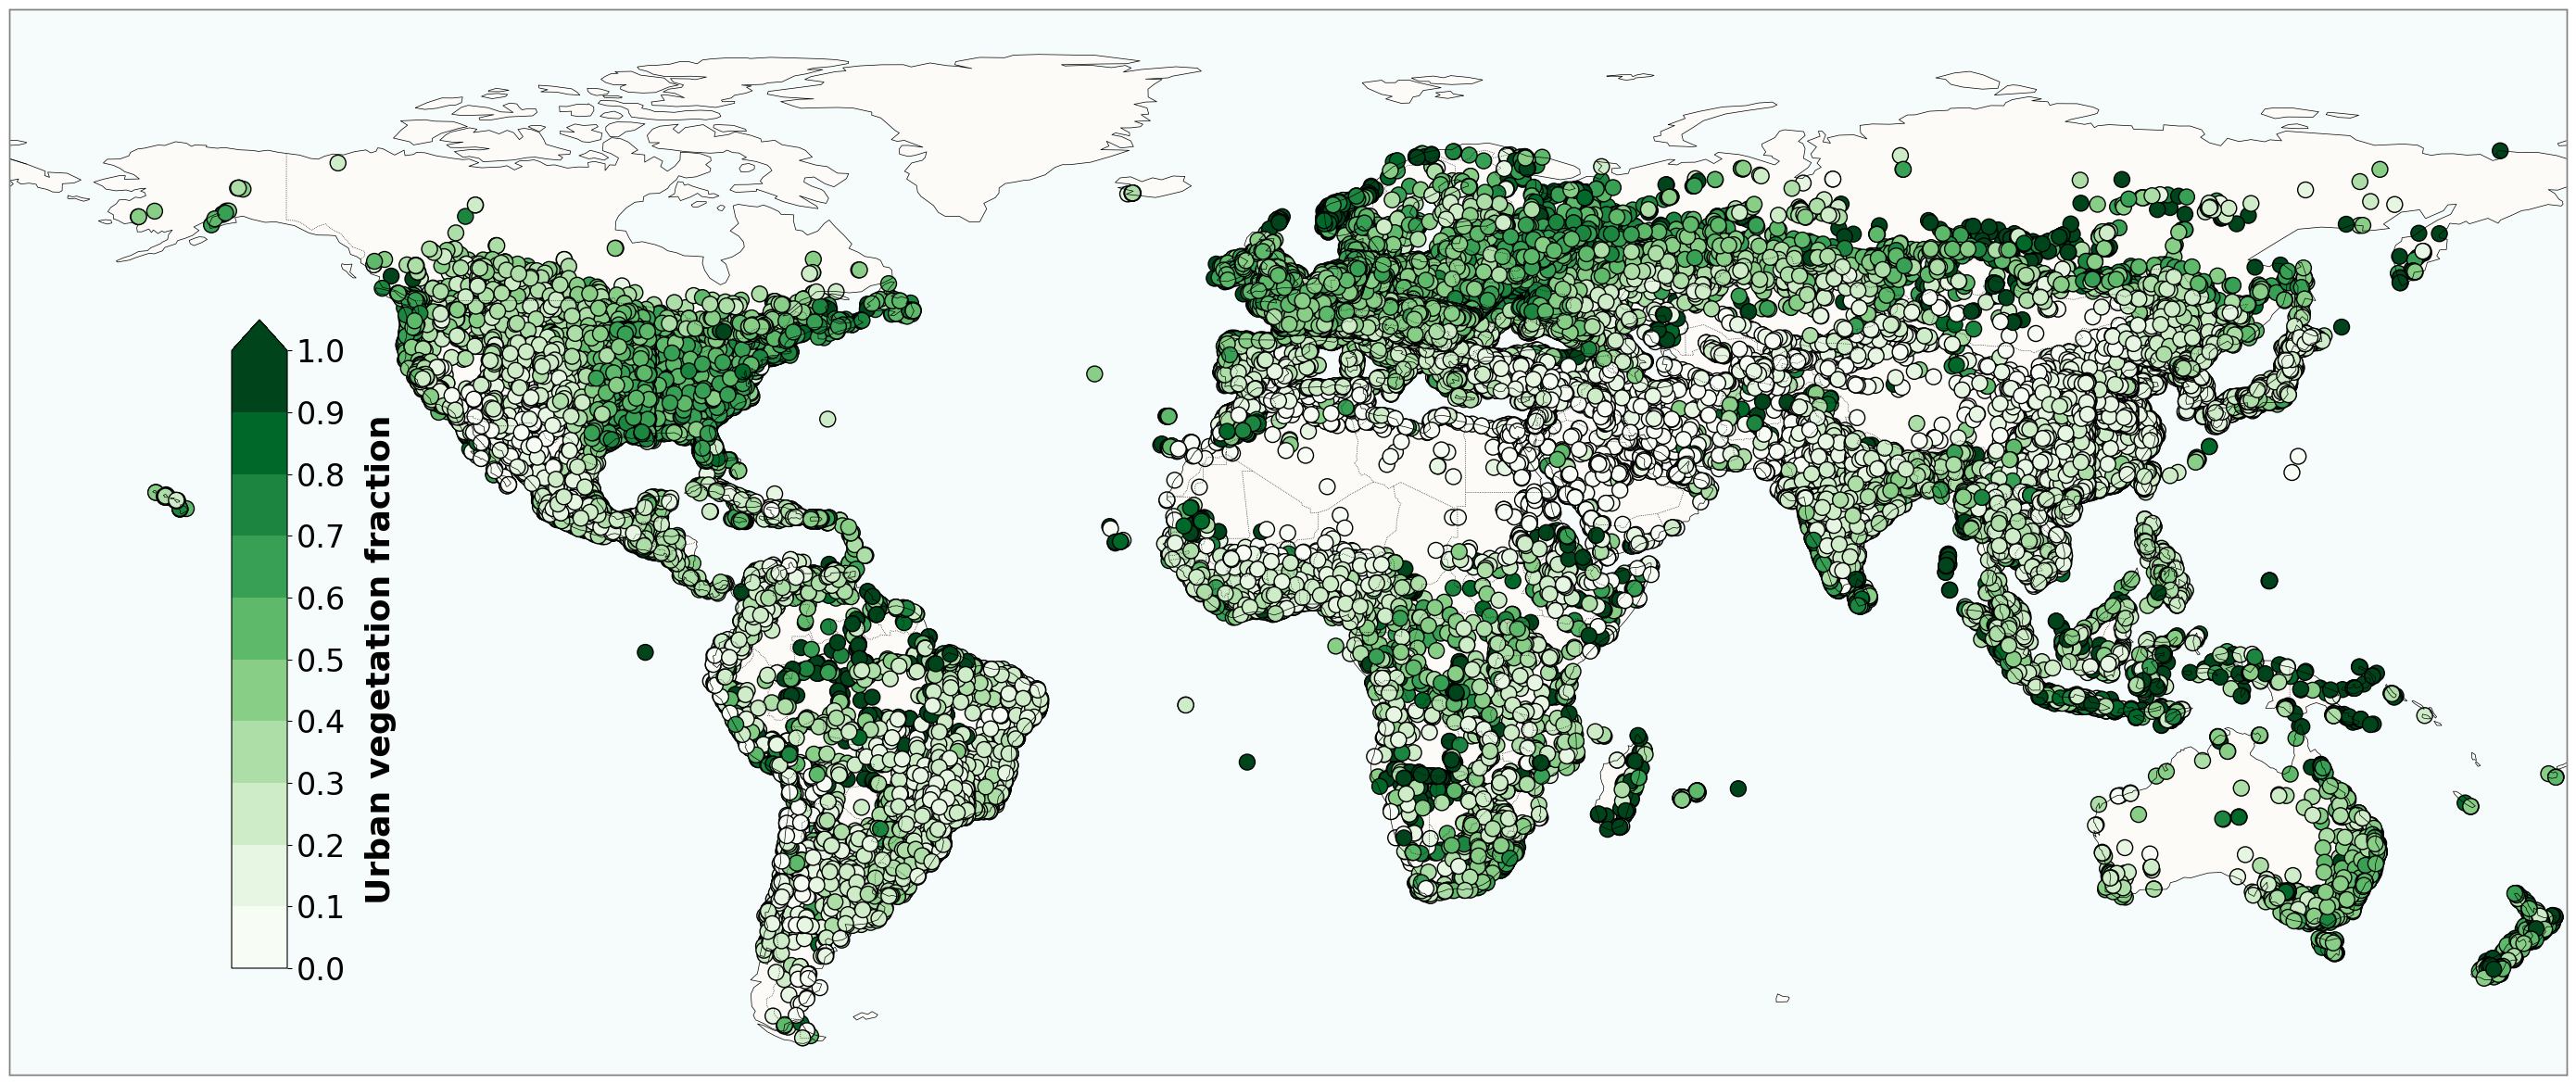

Histogram saved to -> /content/EDFig1A_hist.pdf


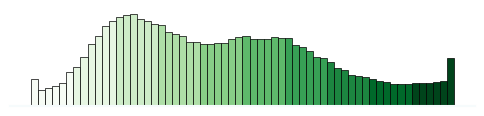

In [9]:
# ------------------------------------------------------------------
# STEP 1: IMPORTS
# ------------------------------------------------------------------
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable

# ------------------------------------------------------------------
# STEP 2: CONFIGURATION
# ------------------------------------------------------------------
# Paths should be adjusted to your environment.
CSV_PATH        = Path('/content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries.csv')

# Outputs will be saved in the specified directory.
OUT_DIR         = Path('/content/')
OUT_MAP         = '/content/EDFig1A_map.pdf'
OUT_HIST        = '/content/EDFig1A_hist.pdf'

# --- Parameters ---
NUM_COLOR_BINS   = 10 # Number of distinct color classes on the map
NUM_HIST_BINS    = 60 # Number of bins for the smaller histogram

# A sequential green colormap suitable for total vegetation data.
SEQUENTIAL_CMAP = plt.cm.Greens

# ------------------------------------------------------------------
# 1. LOAD CSV + CALCULATE TOTAL URBAN VEGETATION FRACTION
# ------------------------------------------------------------------
if not CSV_PATH.is_file():
    raise FileNotFoundError(f"ERROR: CSV not found -> {CSV_PATH}")

df = pd.read_csv(CSV_PATH, low_memory=False)

# Define all urban vegetation columns
urban_cols = [
    "cropland_area_urban", "grassland_area_urban", "herbaceous_wetland_area_urban",
    "mangroves_area_urban", "moss_and_lichen_area_urban", "shrubland_area_urban",
    "tree_cover_area_urban"
]
# Define all columns required for the analysis
REQ = urban_cols + ["Urban_Area", "lat", "lon", "water_percentage"]

missing = [c for c in REQ if c not in df.columns]
if missing:
    raise ValueError(f"ERROR: missing column(s) {missing!r} in CSV")

# Coerce data to numeric, turning errors into Not-a-Number (NaN)
for col in REQ:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where essential data is missing
df.dropna(subset=REQ, inplace=True)

# Filter out cities with zero urban area to avoid division by zero
df = df[df["Urban_Area"] > 0].copy()

# Calculate the fraction of urban area covered by ALL vegetation types
df['veg_urban_frac'] = df[urban_cols].sum(axis=1) / df['Urban_Area']


# ------------------------------------------------------------------
# 2. FILTER FOR LARGEST 1000 CITIES
# ------------------------------------------------------------------
print(f"Original number of cities with valid data: {len(df)}")
df_top1000 = df
print(f"Analyzing the {len(df_top1000)} largest cities by urban area.")


# ------------------------------------------------------------------
# 3. CREATE DISCRETE SEQUENTIAL COLOUR SCALE (0-1, 10 Classes)
# ------------------------------------------------------------------
# Set a fixed 0 to 1 scale
vmin = 0.0
vmax = 1.0

# Create discrete boundaries for the 10 color bins
bounds = np.linspace(vmin, vmax, NUM_COLOR_BINS + 1)
norm   = BoundaryNorm(bounds, ncolors=SEQUENTIAL_CMAP.N, clip=True)


# ------------------------------------------------------------------
# 4. CITY SCATTER MAP
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, facecolor='#fcfbf7')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')

# Make plot border black
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('grey')
    spine.set_linewidth(1)

# Scatter plot of the top 1000 cities
scatter = ax.scatter(
    df_top1000['lon'],
    df_top1000['lat'],
    c=df_top1000['veg_urban_frac'], # Color based on ALL vegetation
    cmap=SEQUENTIAL_CMAP,
    norm=norm,
    s=150,
    alpha=1,
    edgecolors='black',
    linewidths=1,
    transform=ccrs.PlateCarree()
)


ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())


# --- Color Bar ---
cbar_ax = fig.add_axes([0.13, 0.27, 0.02, 0.35])
sm = ScalarMappable(norm=norm, cmap=SEQUENTIAL_CMAP)
sm.set_array([]) # You must set the array for the scalar mappable
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label('Urban vegetation fraction', fontsize=26, labelpad=15, fontweight='bold')

# Set ticks to the calculated bin edges for clarity
cbar.set_ticks(bounds)
cbar.set_ticklabels([f'{b:.1f}' for b in bounds]) # Use .1f for 0.0, 0.1, etc.
cbar.ax.tick_params(labelsize=24)


plt.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.05)
plt.savefig(OUT_MAP, bbox_inches='tight', format='pdf', transparent=True)
print(f"Map saved to -> {OUT_MAP}")
plt.show()

# ------------------------------------------------------------------
# 5. MINIMALIST HISTOGRAM
# ------------------------------------------------------------------
def minimalist_hist(series: pd.Series, bounds_arr, bins, cmap_obj, path):
    """Creates a minimalist histogram with bars colored by value."""
    # Use the same normalization as the map for visual consistency
    norm_hist = BoundaryNorm(bounds_arr, ncolors=cmap_obj.N, clip=True)

    # Clip series to the same bounds as the map
    series = series.clip(lower=bounds_arr[0], upper=bounds_arr[-1])
    if series.empty:
        print("No data in histogram range – skipped."); return

    fig, ax = plt.subplots(figsize=(6, 1.25))

    counts, edges, patches = ax.hist(
        series,
        bins=np.linspace(bounds_arr[0], bounds_arr[-1], bins + 1),
        edgecolor='black', linewidth=0.5
    )

    # Color each histogram bar based on its value
    for p, l, r in zip(patches, edges[:-1], edges[1:]):
        p.set_facecolor(cmap_obj(norm_hist((l + r) / 2)))

    # Strip axes for minimalist look
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values(): s.set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('#f6fbfc')
    ax.spines['bottom'].set_linewidth(1.5)

    fig.patch.set_alpha(0); ax.patch.set_alpha(0)
    plt.savefig(path, bbox_inches='tight', format='pdf', transparent=True)
    print(f"Histogram saved to -> {path}")
    plt.show()

# Generate the histogram with data and styling from the map
minimalist_hist(
    series=df_top1000['veg_urban_frac'],
    bounds_arr=bounds,
    bins=NUM_HIST_BINS,
    cmap_obj=SEQUENTIAL_CMAP,
    path=OUT_HIST
)

###urban rural city differences

/tmp/ipython-input-2374173688.py:94: DtypeWarning: Columns (57,59,60,62,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


veg_diff range (top 1000): -0.704 → 0.334
Map successfully saved to /content/Fig1B_map.pdf


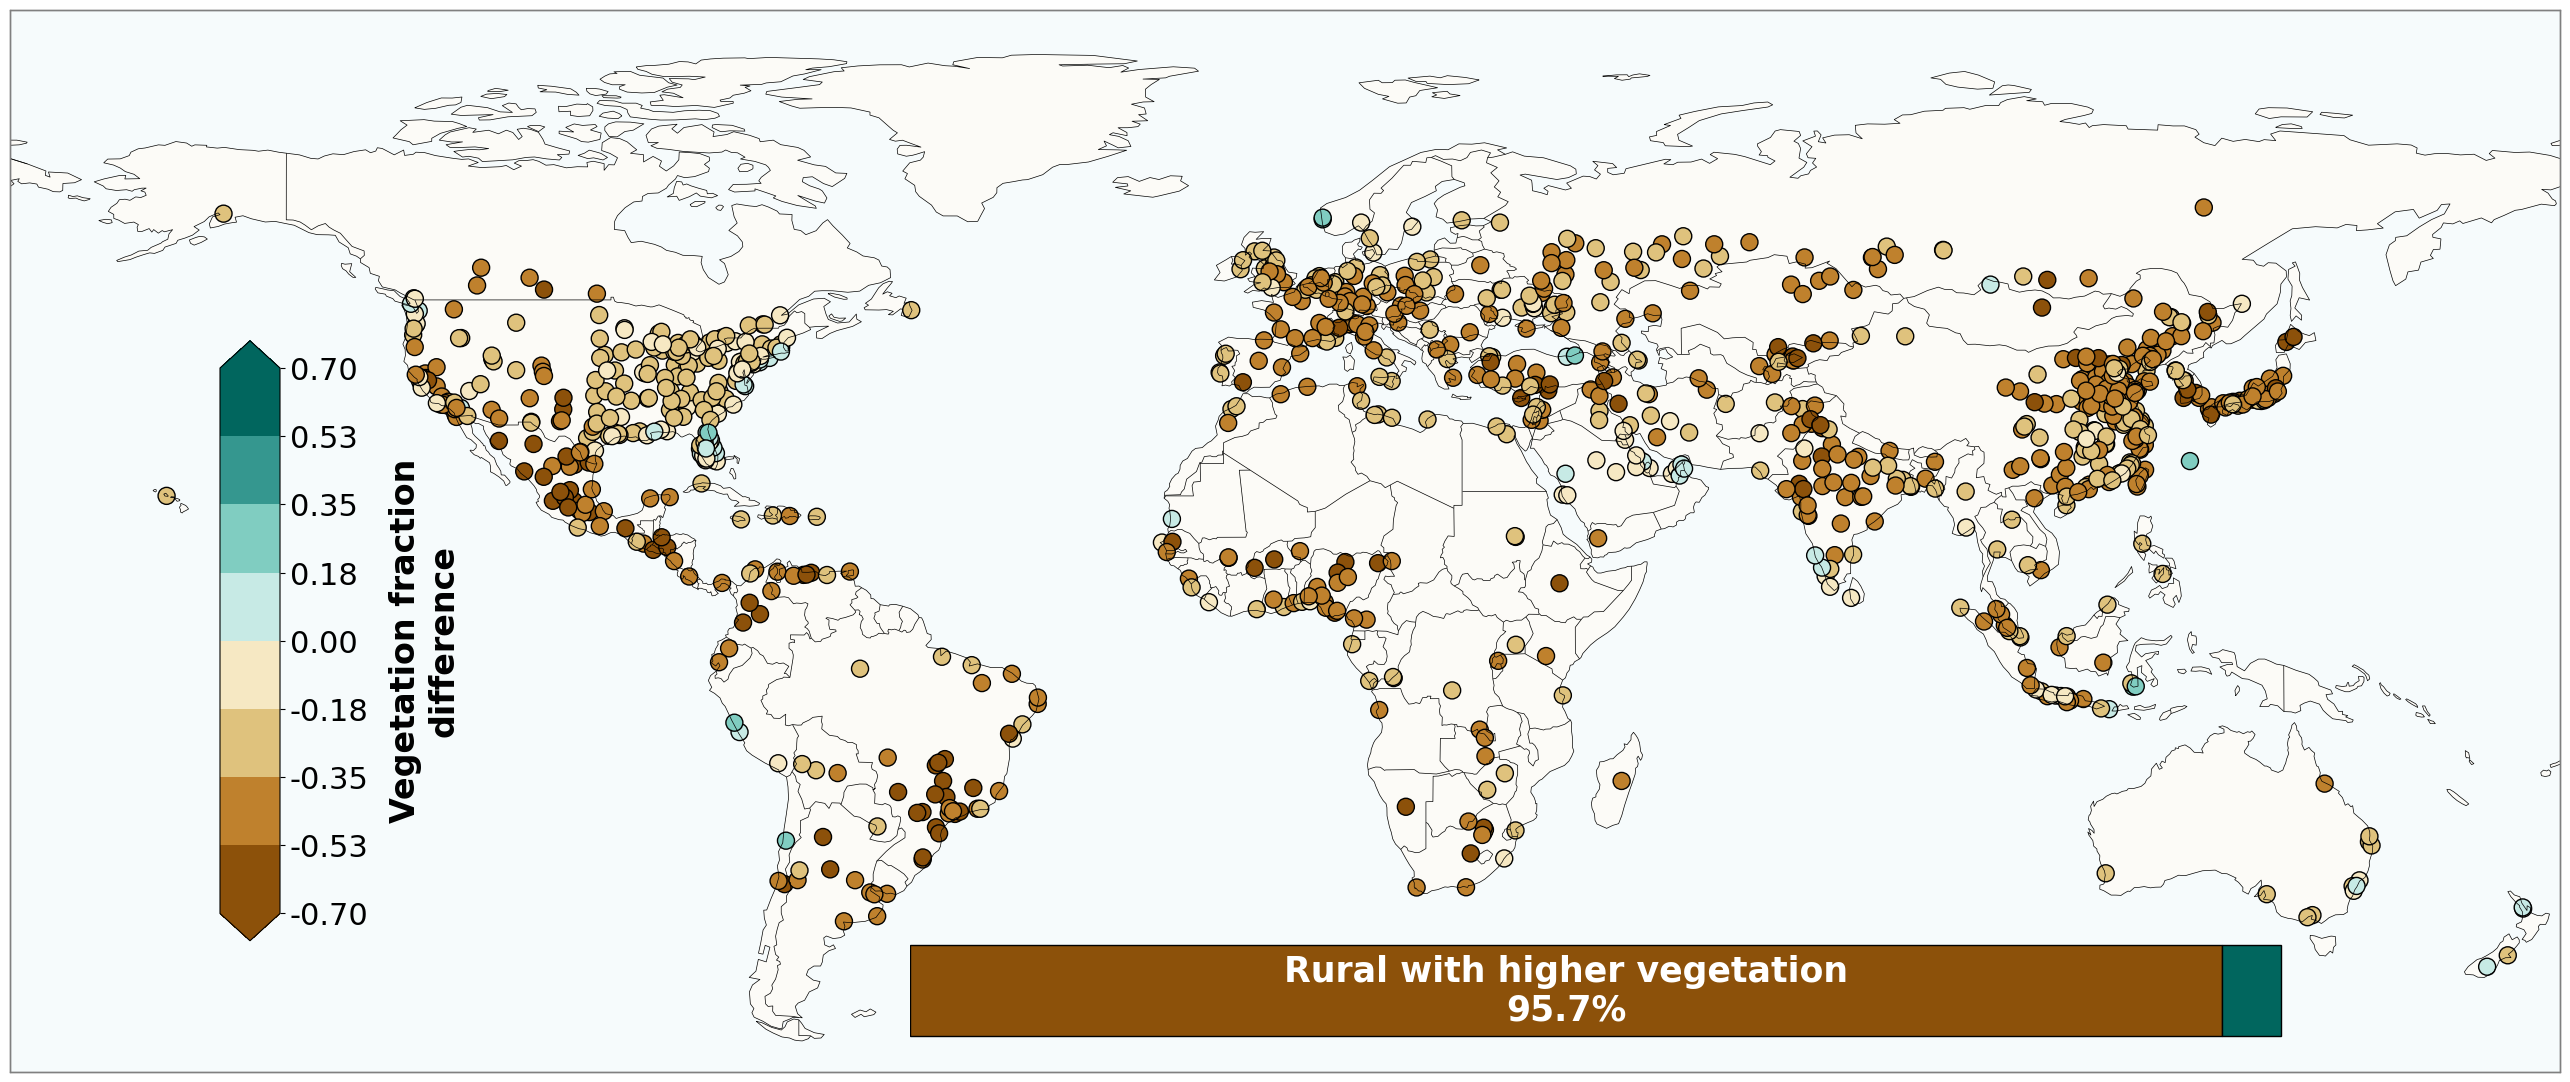

Histogram successfully saved to /content/Fig1B_hist.pdf


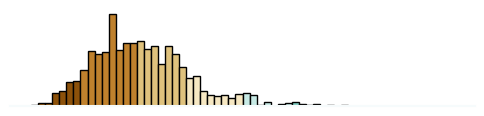

In [10]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm

# -------------------------
# CONFIG
# -------------------------
NBINS_HIST = 60   # histogram bins (many bars, but colored by discrete classes)


def create_frequency_histogram_discrete(
    data_series: pd.Series,
    bounds: np.ndarray,
    cmap_discrete: ListedColormap,
    norm_discrete: BoundaryNorm,
    num_bins: int,
    out_path: str,
) -> None:
    """
    Minimalist frequency histogram of urban–rural differences (or any diff variable).

    - X range is clipped to `bounds[0] .. bounds[-1]`
    - Colors use the SAME discrete colormap + BoundaryNorm as the map/colorbar.
    - Each bar is colored by the discrete class of its bin midpoint.
    """

    lower_bound = float(bounds[0])
    upper_bound = float(bounds[-1])

    # Filter to the same numeric range as the map/cbar
    filtered = data_series[(data_series >= lower_bound) & (data_series <= upper_bound)]
    if filtered.empty:
        print("No data available within specified bounds for histogram.")
        return

    # Histogram bins: many more than the color classes, but within the same range
    bins = np.linspace(lower_bound, upper_bound, num_bins + 1)

    fig, ax = plt.subplots(figsize=(6, 1.25))
    try:
        counts, bin_edges, patches = ax.hist(
            filtered,
            bins=bins,
            edgecolor='black'
        )

        # Color each bin according to its midpoint, using the SAME discrete norm & cmap
        for patch, left, right in zip(patches, bin_edges[:-1], bin_edges[1:]):
            midpoint = 0.5 * (left + right)
            color = cmap_discrete(norm_discrete(midpoint))  # index into the discrete cmap
            patch.set_facecolor(color)

        # Minimalist styling
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_color('#f6fbfc')
        ax.spines['bottom'].set_linewidth(1.5)

        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)

        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, format='pdf', dpi=400, bbox_inches='tight', transparent=True)
        print(f"Histogram successfully saved to {out_path}")
    except Exception as e:
        print(f"Error generating/saving histogram: {e}")
    finally:
        plt.show()
        plt.close(fig)


def analyze_veg_diff(file_path, top_n=1000, output_prefix="veg_diff"):
    """
    Loads vegetation components, computes urban–rural vegetation fraction difference,
    and renders:
      - a discrete scatter map (even #classes; 0 is a class boundary)
      - a stacked bar with %>0 vs %<0
      - a DISCRETE histogram using the same diverging palette/classes as the map
    """
    # 1) Load
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        raise FileNotFoundError(f"Error reading file '{file_path}': {e}")

    # 2) Columns & numeric conversion
    urban_cols = [
        "cropland_area_urban", "grassland_area_urban", "herbaceous_wetland_area_urban",
        "mangroves_area_urban", "moss_and_lichen_area_urban", "shrubland_area_urban",
        "tree_cover_area_urban"
    ]
    rural_cols = [
        "cropland_area_rural", "grassland_area_rural", "herbaceous_wetland_area_rural",
        "mangroves_area_rural", "moss_and_lichen_area_rural", "shrubland_area_rural",
        "tree_cover_area_rural"
    ]
    required_columns = urban_cols + rural_cols + ["Urban_Area", "Buffer_area", "lat", "lon"]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in data.")
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.dropna(subset=required_columns)
    df = df[(df["Urban_Area"] > 0) & (df["Buffer_area"] > 0)].copy()
    if df.empty:
        raise RuntimeError("No rows with Urban_Area > 0 AND Buffer_area > 0.")

    # 3) Fractions and difference
    df["veg_urban_frac"] = df[urban_cols].sum(axis=1) / df["Urban_Area"]
    df["veg_rural_frac"] = df[rural_cols].sum(axis=1) / df["Buffer_area"]
    df["veg_diff"] = df["veg_urban_frac"] - df["veg_rural_frac"]

    # 4) Top N by urban area
    df = df.nlargest(top_n, "Urban_Area")
    if df.empty:
        raise RuntimeError("No data after selecting top_n cities.")
    lo, hi = df["veg_diff"].min(), df["veg_diff"].max()
    print(f"veg_diff range (top {top_n}): {lo:.3f} → {hi:.3f}")

    # 5) Brown→Teal diverging palette (even #colors; 0 becomes a boundary)
    custom_colors = [
        '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',  # brown side (negative)
        '#c7eae5', '#80cdc1', '#35978f', '#01665e'   # teal side (positive)
    ]
    N = len(custom_colors)
    R = max(abs(lo), abs(hi)) if np.isfinite(lo) and np.isfinite(hi) else 1.0
    if R == 0:
        R = 1.0  # avoid degenerate color ranges when all diffs are 0

    # Discrete bounds: N+1 edges, N bins; 0 is guaranteed to be an edge
    discrete_bounds = np.linspace(-R, R, N + 1)
    cmap_disc = ListedColormap(custom_colors)
    norm_disc = BoundaryNorm(discrete_bounds, ncolors=N, clip=True)

    # 6) Scatter map
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.1)
    ax.add_feature(cfeature.LAND, facecolor="#fcfbf7")

    # Frame
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('grey')
        spine.set_linewidth(1)

    sc = ax.scatter(
        df["lon"], df["lat"],
        c=df["veg_diff"],
        cmap=cmap_disc, norm=norm_disc,
        s=150, edgecolors="black", linewidths=1,
        transform=ccrs.PlateCarree()
    )
    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    # 7) Colorbar (ticks at bin edges for readability)
    cax = fig.add_axes([0.17, 0.3, 0.02, 0.3])
    cb = plt.colorbar(sc, cax=cax, orientation="vertical", extend="both")
    cb.set_label("Vegetation fraction\ndifference", fontsize=24, labelpad=15, fontweight='bold')
    cb.ax.tick_params(labelsize=22)
    cb.set_ticks(discrete_bounds)
    cb.set_ticklabels([f"{x:.2f}" for x in discrete_bounds])

    # 8) %>0 vs %<0 stacked bar (rural-left, urban-right)
    total = len(df)
    pct_pos = (df["veg_diff"] > 0).sum() / total * 100.0
    pct_neg = (df["veg_diff"] < 0).sum() / total * 100.0

    bax = fig.add_axes([0.4, 0.25, 0.48, 0.05])
    bax.set_axis_off()

    # First draw rural (brown) on left
    bax.barh(["Cities"], [pct_neg], color='#8c510a', edgecolor='black', height=0.4)

    # Then draw urban (teal) on right
    bax.barh(["Cities"], [pct_pos], color='#01665e', edgecolor='black', height=0.4, left=pct_neg)

    # Labels
    bax.text(pct_neg / 2, 0,
             f"Rural with higher vegetation\n{pct_neg:.1f}%",
             ha='center', va='center', fontsize=25, color='white', weight='bold')

    bax.text(pct_neg + pct_pos / 2, 0,
             f"",
             ha='center', va='center', fontsize=25, color='white', weight='bold')

    plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.05)

    # 9) Save map
    map_file = f"{output_prefix}_map.pdf"
    try:
        os.makedirs(os.path.dirname(map_file), exist_ok=True)
        plt.savefig(map_file, bbox_inches="tight", format='pdf', transparent=True)
        print(f"Map successfully saved to {map_file}")
    except Exception as e:
        print(f"Error saving map: {e}")
    finally:
        plt.show()
        plt.close(fig)

    # 10) DISCRETE histogram using the same palette/classes as the map
    hist_file = f"{output_prefix}_hist.pdf"
    create_frequency_histogram_discrete(
        data_series=df["veg_diff"],
        bounds=discrete_bounds,
        cmap_discrete=cmap_disc,
        norm_discrete=norm_disc,
        num_bins=NBINS_HIST,
        out_path=hist_file
    )


if __name__ == "__main__":
    # Paths/config
    FILE_PATH = "/content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries.csv"
    TOP_N = 1000

    # Output prefix (directory will be created if needed)
    OUTPUT_DIR = "/content/"
    OUTPUT_PREFIX = os.path.join(OUTPUT_DIR, "Fig1B")

    try:
        analyze_veg_diff(
            file_path=FILE_PATH,
            top_n=TOP_N,
            output_prefix=OUTPUT_PREFIX
        )
    except (FileNotFoundError, ValueError, RuntimeError) as e:
        print(f"An error occurred during analysis: {e}", file=sys.stderr)
        sys.exit(1)


/tmp/ipython-input-1499831148.py:93: DtypeWarning: Columns (57,59,60,62,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


veg_diff range (top 83102): -0.768 → 0.674
Map successfully saved to /content/EDFig1_map.pdf


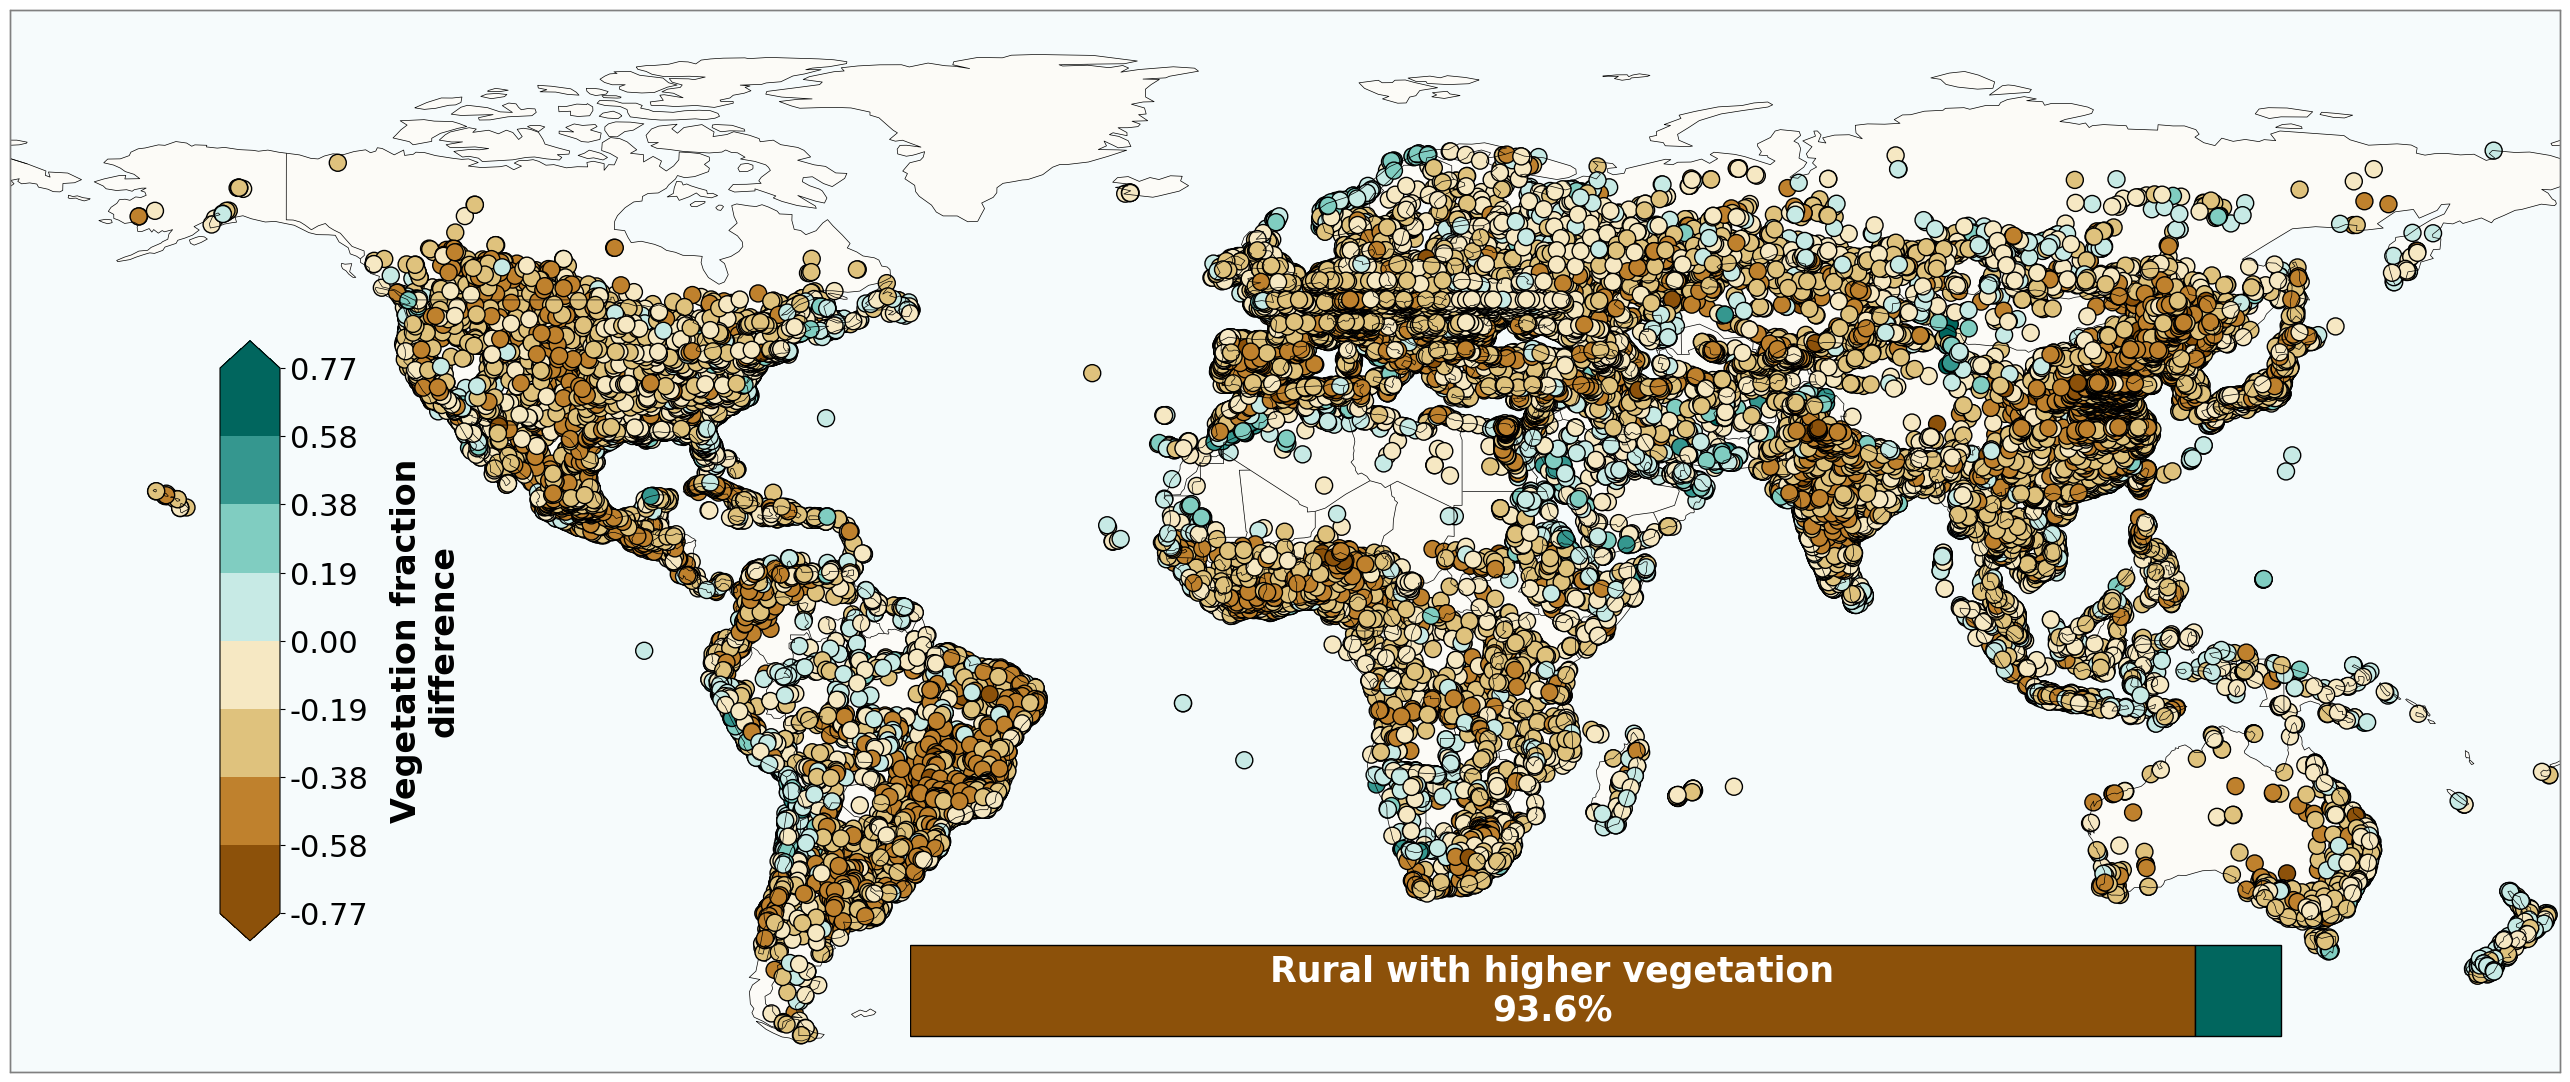

Histogram successfully saved to /content/EDFig1_hist.pdf


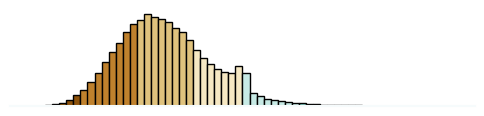

In [11]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm

# -------------------------
# CONFIG
# -------------------------
NBINS_HIST = 60   # histogram bins (many bars, but colored by discrete classes)


def create_frequency_histogram_discrete(
    data_series: pd.Series,
    bounds: np.ndarray,
    cmap_discrete: ListedColormap,
    norm_discrete: BoundaryNorm,
    num_bins: int,
    out_path: str,
) -> None:
    """
    Minimalist frequency histogram of urban–rural differences (or any diff variable).

    - X range is clipped to `bounds[0] .. bounds[-1]`
    - Colors use the SAME discrete colormap + BoundaryNorm as the map/colorbar.
    - Each bar is colored by the discrete class of its bin midpoint.
    """

    lower_bound = float(bounds[0])
    upper_bound = float(bounds[-1])

    # Filter to the same numeric range as the map/cbar
    filtered = data_series[(data_series >= lower_bound) & (data_series <= upper_bound)]
    if filtered.empty:
        print("No data available within specified bounds for histogram.")
        return

    # Histogram bins: many more than the color classes, but within the same range
    bins = np.linspace(lower_bound, upper_bound, num_bins + 1)

    fig, ax = plt.subplots(figsize=(6, 1.25))
    try:
        counts, bin_edges, patches = ax.hist(
            filtered,
            bins=bins,
            edgecolor='black'
        )

        # Color each bin according to its midpoint, using the SAME discrete norm & cmap
        for patch, left, right in zip(patches, bin_edges[:-1], bin_edges[1:]):
            midpoint = 0.5 * (left + right)
            color = cmap_discrete(norm_discrete(midpoint))  # index into the discrete cmap
            patch.set_facecolor(color)

        # Minimalist styling
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_color('#f6fbfc')
        ax.spines['bottom'].set_linewidth(1.5)

        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)

        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, format='pdf', dpi=400, bbox_inches='tight', transparent=True)
        print(f"Histogram successfully saved to {out_path}")
    except Exception as e:
        print(f"Error generating/saving histogram: {e}")
    finally:
        plt.show()
        plt.close(fig)


def analyze_veg_diff(file_path, top_n=1000, output_prefix="veg_diff"):
    """
    Loads vegetation components, computes urban–rural vegetation fraction difference,
    and renders:
      - a discrete scatter map (even #classes; 0 is a class boundary)
      - a stacked bar with %>0 vs %<0
      - a DISCRETE histogram using the same diverging palette/classes as the map
    """
    # 1) Load
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        raise FileNotFoundError(f"Error reading file '{file_path}': {e}")

    # 2) Columns & numeric conversion
    urban_cols = [
        "cropland_area_urban", "grassland_area_urban", "herbaceous_wetland_area_urban",
        "mangroves_area_urban", "moss_and_lichen_area_urban", "shrubland_area_urban",
        "tree_cover_area_urban"
    ]
    rural_cols = [
        "cropland_area_rural", "grassland_area_rural", "herbaceous_wetland_area_rural",
        "mangroves_area_rural", "moss_and_lichen_area_rural", "shrubland_area_rural",
        "tree_cover_area_rural"
    ]
    required_columns = urban_cols + rural_cols + ["Urban_Area", "Buffer_area", "lat", "lon"]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in data.")
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.dropna(subset=required_columns)
    df = df[(df["Urban_Area"] > 0) & (df["Buffer_area"] > 0)].copy()
    if df.empty:
        raise RuntimeError("No rows with Urban_Area > 0 AND Buffer_area > 0.")

    # 3) Fractions and difference
    df["veg_urban_frac"] = df[urban_cols].sum(axis=1) / df["Urban_Area"]
    df["veg_rural_frac"] = df[rural_cols].sum(axis=1) / df["Buffer_area"]
    df["veg_diff"] = df["veg_urban_frac"] - df["veg_rural_frac"]

    # 4) Top N by urban area
    df = df.nlargest(top_n, "Urban_Area")
    if df.empty:
        raise RuntimeError("No data after selecting top_n cities.")
    lo, hi = df["veg_diff"].min(), df["veg_diff"].max()
    print(f"veg_diff range (top {top_n}): {lo:.3f} → {hi:.3f}")

    # 5) Brown→Teal diverging palette (even #colors; 0 becomes a boundary)
    custom_colors = [
        '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',  # brown side (negative)
        '#c7eae5', '#80cdc1', '#35978f', '#01665e'   # teal side (positive)
    ]
    N = len(custom_colors)
    R = max(abs(lo), abs(hi)) if np.isfinite(lo) and np.isfinite(hi) else 1.0
    if R == 0:
        R = 1.0  # avoid degenerate color ranges when all diffs are 0

    # Discrete bounds: N+1 edges, N bins; 0 is guaranteed to be an edge
    discrete_bounds = np.linspace(-R, R, N + 1)
    cmap_disc = ListedColormap(custom_colors)
    norm_disc = BoundaryNorm(discrete_bounds, ncolors=N, clip=True)

    # 6) Scatter map
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.1)
    ax.add_feature(cfeature.LAND, facecolor="#fcfbf7")

    # Frame
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('grey')
        spine.set_linewidth(1)

    sc = ax.scatter(
        df["lon"], df["lat"],
        c=df["veg_diff"],
        cmap=cmap_disc, norm=norm_disc,
        s=150, edgecolors="black", linewidths=1,
        transform=ccrs.PlateCarree()
    )
    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    # 7) Colorbar (ticks at bin edges for readability)
    cax = fig.add_axes([0.17, 0.3, 0.02, 0.3])
    cb = plt.colorbar(sc, cax=cax, orientation="vertical", extend="both")
    cb.set_label("Vegetation fraction\ndifference", fontsize=24, labelpad=15, fontweight='bold')
    cb.ax.tick_params(labelsize=22)
    cb.set_ticks(discrete_bounds)
    cb.set_ticklabels([f"{x:.2f}" for x in discrete_bounds])

    # 8) %>0 vs %<0 stacked bar (rural-left, urban-right)
    total = len(df)
    pct_pos = (df["veg_diff"] > 0).sum() / total * 100.0
    pct_neg = (df["veg_diff"] < 0).sum() / total * 100.0

    bax = fig.add_axes([0.4, 0.25, 0.48, 0.05])
    bax.set_axis_off()

    # First draw rural (brown) on left
    bax.barh(["Cities"], [pct_neg], color='#8c510a', edgecolor='black', height=0.4)

    # Then draw urban (teal) on right
    bax.barh(["Cities"], [pct_pos], color='#01665e', edgecolor='black', height=0.4, left=pct_neg)

    # Labels
    bax.text(pct_neg / 2, 0,
             f"Rural with higher vegetation\n{pct_neg:.1f}%",
             ha='center', va='center', fontsize=25, color='white', weight='bold')

    bax.text(pct_neg + pct_pos / 2, 0,
             f"",
             ha='center', va='center', fontsize=25, color='white', weight='bold')

    plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.05)

    # 9) Save map
    map_file = f"{output_prefix}_map.pdf"
    try:
        os.makedirs(os.path.dirname(map_file), exist_ok=True)
        plt.savefig(map_file, bbox_inches="tight", format='pdf', transparent=True)
        print(f"Map successfully saved to {map_file}")
    except Exception as e:
        print(f"Error saving map: {e}")
    finally:
        plt.show()
        plt.close(fig)

    # 10) DISCRETE histogram using the same palette/classes as the map
    hist_file = f"{output_prefix}_hist.pdf"
    create_frequency_histogram_discrete(
        data_series=df["veg_diff"],
        bounds=discrete_bounds,
        cmap_discrete=cmap_disc,
        norm_discrete=norm_disc,
        num_bins=NBINS_HIST,
        out_path=hist_file
    )


if __name__ == "__main__":
    # Paths/config
    FILE_PATH = "/content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries.csv"
    TOP_N = 83102

    # Output prefix (directory will be created if needed)
    OUTPUT_DIR = "/content/"
    OUTPUT_PREFIX = os.path.join(OUTPUT_DIR, "EDFig1")

    try:
        analyze_veg_diff(
            file_path=FILE_PATH,
            top_n=TOP_N,
            output_prefix=OUTPUT_PREFIX
        )
    except (FileNotFoundError, ValueError, RuntimeError) as e:
        print(f"An error occurred during analysis: {e}", file=sys.stderr)
        sys.exit(1)


###urban country

Keeping 167 countries with ≥3 cities for analysis.


/tmp/ipython-input-3954056581.py:347: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_aggregate_country)



Top 3 — weighted URBAN vegetation fraction (μ̄_u)
     COUNTRY_STD  n_cities  veg_urban_country
          norway     461.0           0.828869
papua new guinea      43.0           0.776180
         ukraine    4753.0           0.720488

Bottom 3 — weighted URBAN vegetation fraction (μ̄_u)
 COUNTRY_STD  n_cities  veg_urban_country
      kuwait      18.0           0.013578
       qatar      30.0           0.027160
saudi arabia     274.0           0.034400

Most positive 3 — DW (urban − rural) vegetation fraction (Δ_DW)
COUNTRY_STD  n_cities  veg_diff_country_dw
 mauritania      47.0             0.144054
     norway     461.0             0.062018
    eritrea      39.0             0.025897

Most negative 3 — DW (urban − rural) vegetation fraction (Δ_DW)
 COUNTRY_STD  n_cities  veg_diff_country_dw
burkina faso      35.0            -0.508342
    colombia     299.0            -0.489142
 el salvador      35.0            -0.476979

Across-country weighted means (area-weighted over countries):
  

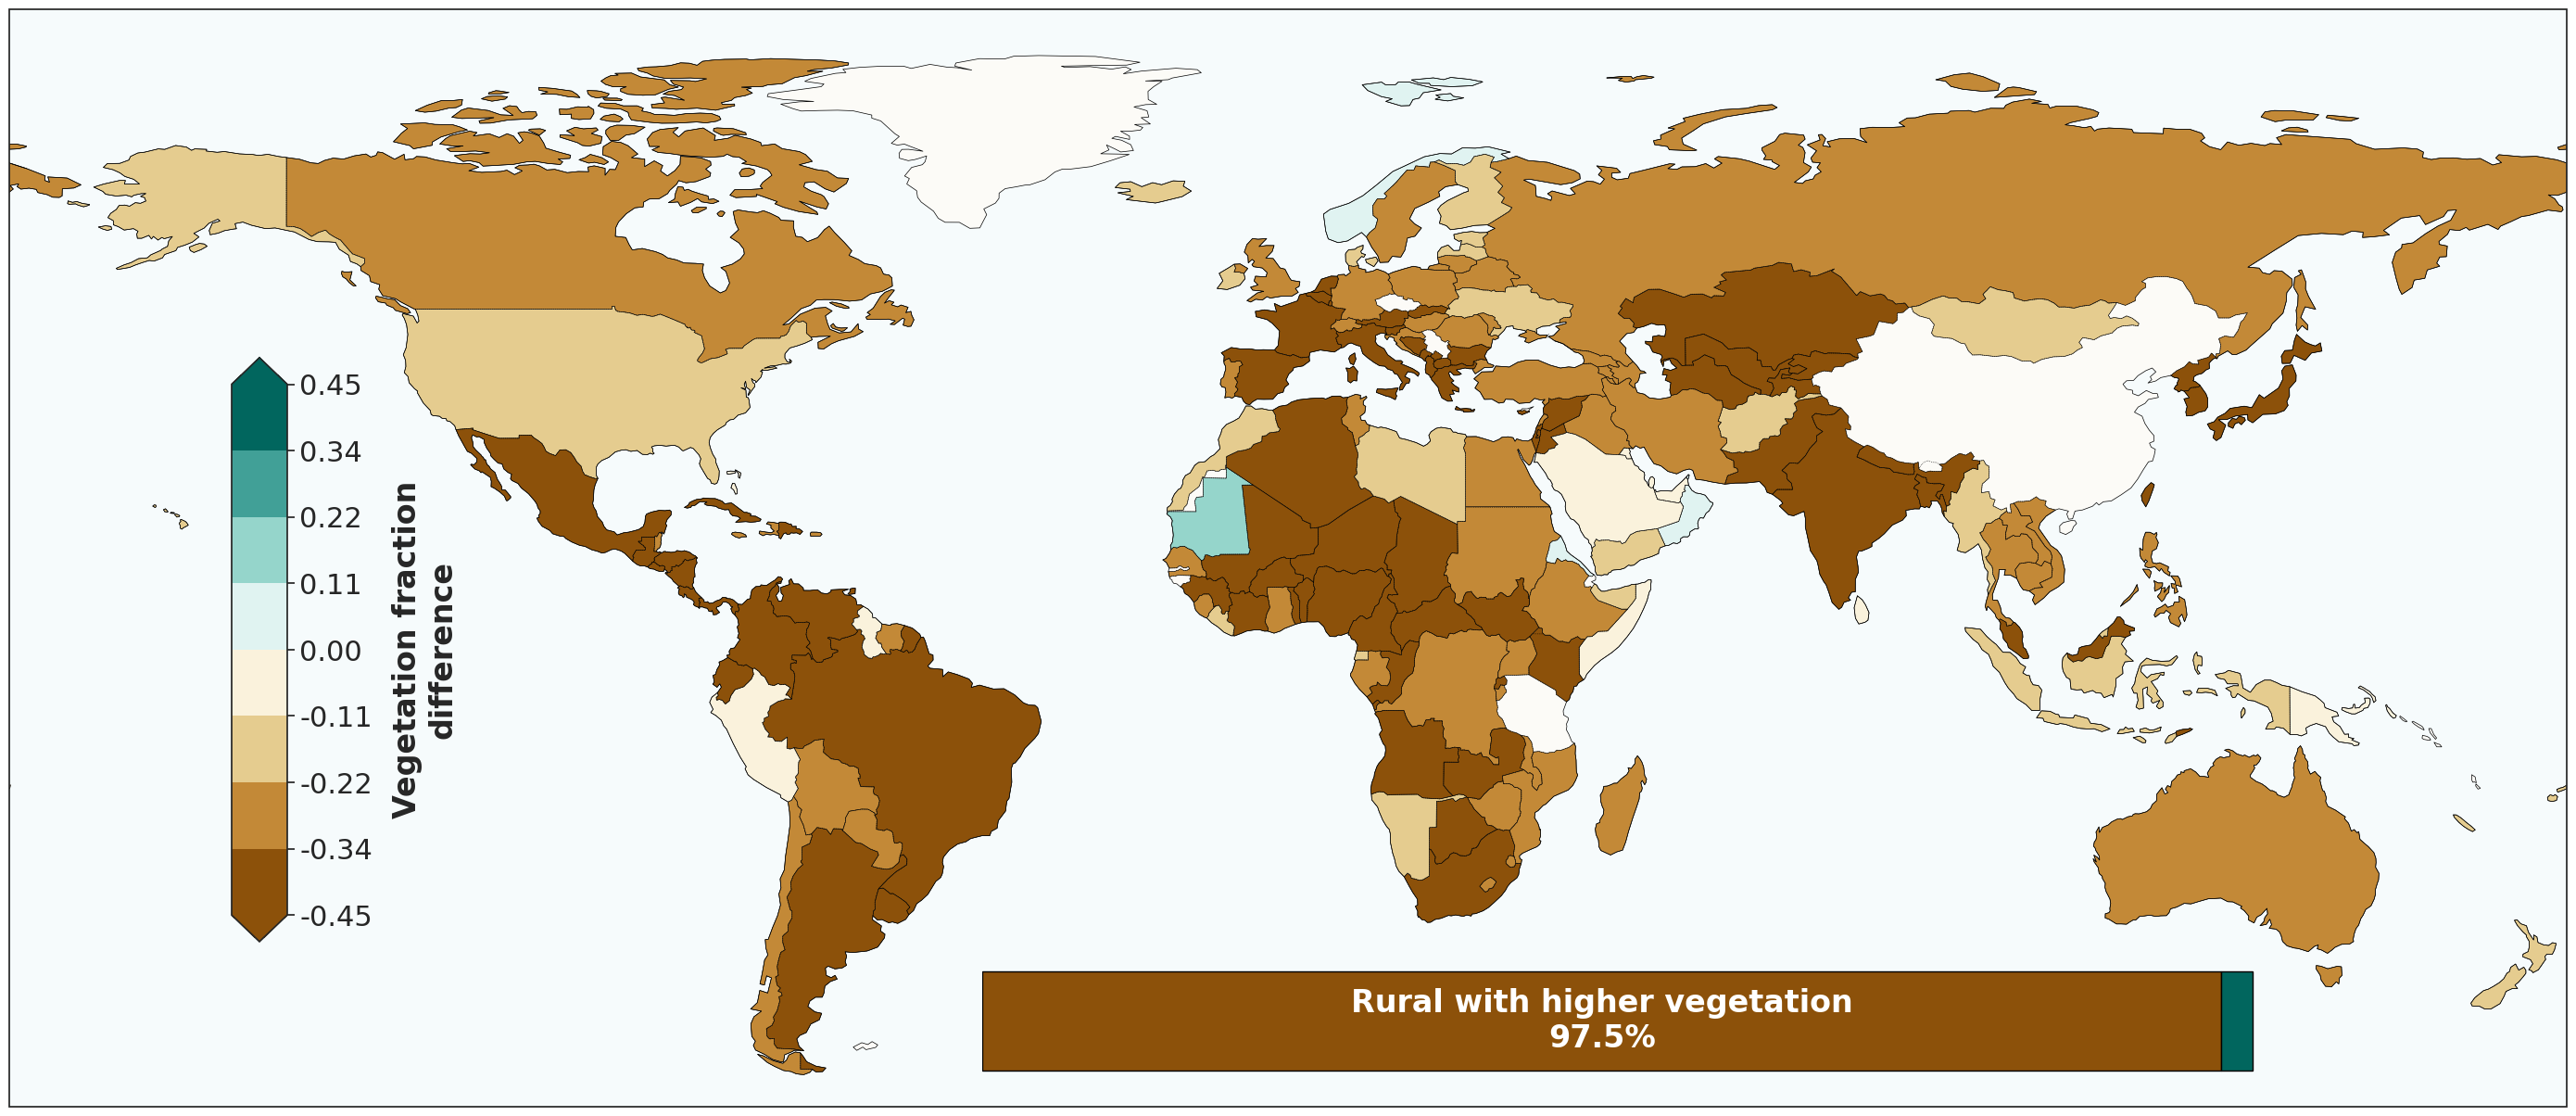

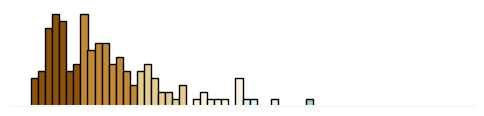

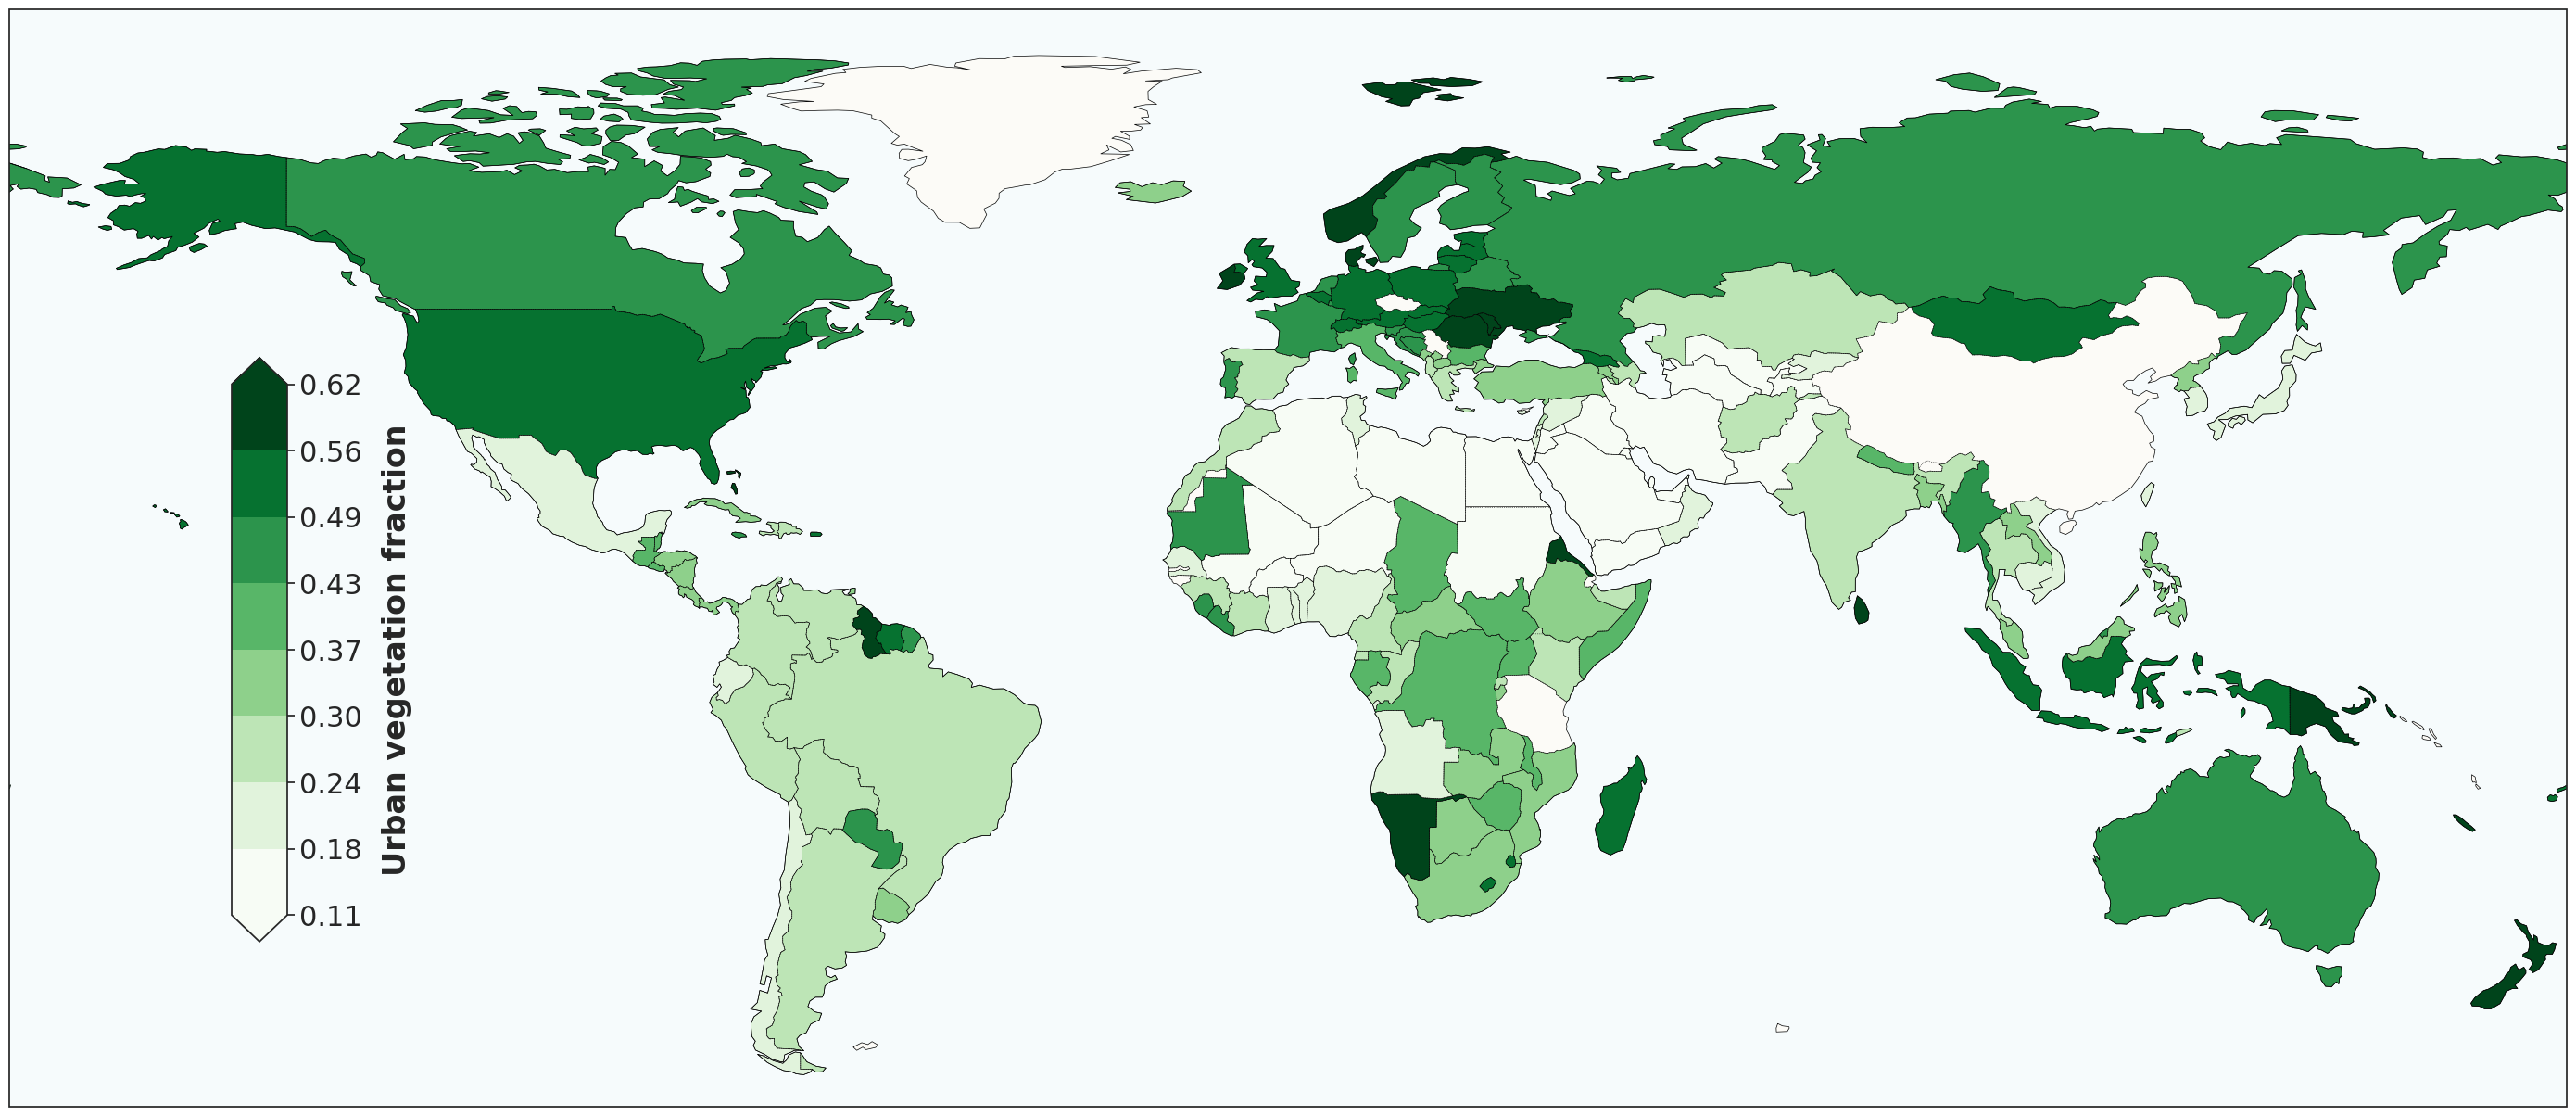

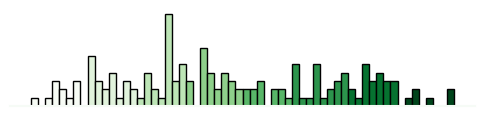

In [28]:
# ------------------------------------------------------------------
# IMPORTS
# ------------------------------------------------------------------
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable

# ------------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------------
CSV_PATH   = Path('/content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries.csv')
SHAPE_PATH = Path('/content/ne_110m_admin_0_countries.shp')

OUT_DIR        = Path('/content/')
OUT_MAP_DIFF   = str(OUT_DIR / 'Sup_VegFrac_country_diff_Map.pdf')
OUT_HIST_DIFF  = str(OUT_DIR / 'Sup_VegFrac_country_diff_Hist.pdf')
OUT_MAP_UABS   = str(OUT_DIR / 'Sup_VegFrac_country_abs_Map.pdf')
OUT_HIST_UABS  = str(OUT_DIR / 'Sup_VegFrac_country_abs_Hist.pdf')

MIN_CITIES      = 3
NUM_COLOR_BINS  = 8
NUM_HIST_BINS   = 60
EPS_TIE         = 1e-9   # tolerance for "ties" in DW gap

URBAN_AREA_COL        = "Urban_Area"
RURAL_AREA_CANDIDATES = ["Buffer_area", "Rural_Area"]

# Vegetation classes (same as your other veg scripts)
URBAN_VEG_COLS = [
    "cropland_area_urban", "grassland_area_urban", "herbaceous_wetland_area_urban",
    "mangroves_area_urban", "moss_and_lichen_area_urban", "shrubland_area_urban",
    "tree_cover_area_urban"
]
RURAL_VEG_COLS = [
    "cropland_area_rural", "grassland_area_rural", "herbaceous_wetland_area_rural",
    "mangroves_area_rural", "moss_and_lichen_area_rural", "shrubland_area_rural",
    "tree_cover_area_rural"
]

# Diverging palette (brown ↔ white ↔ green) for DW difference
DIVERGING_COLS = [
    '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
    '#ffffff',          # Zero-ish
    '#c7eae5', '#80cdc1', '#35978f', '#01665e'
]
COLOR_RURAL_GREENER = DIVERGING_COLS[0]
COLOR_URBAN_GREENER = DIVERGING_COLS[-1]
COLOR_TIES          = "#d9d9d9"

# Sequential greens for absolute urban fraction
SEQUENTIAL_COLS = [
    '#f7fcf5','#e5f5e0','#c7e9c0','#a1d99b',
    '#74c476','#41ab5d','#238b45','#006d2c','#00441b'
]

# ------------------------------------------------------------------
# HELPERS
# ------------------------------------------------------------------
def _std_name(series: pd.Series) -> pd.Series:
    """Standardises country names for robust merging."""
    return (series.astype(str).str.lower()
            .str.replace("&", "and", regex=False)
            .str.replace("-", " ",   regex=False)
            .str.replace(".", "",    regex=False)
            .str.replace(",", "",    regex=False)
            .str.strip())

def _pick_rural_area_col(df: pd.DataFrame) -> str:
    for c in RURAL_AREA_CANDIDATES:
        if c in df.columns:
            return c
    raise KeyError(f"None of {RURAL_AREA_CANDIDATES} found as rural area column.")

def _require_cols(df: pd.DataFrame, cols: list[str]) -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        sys.exit(f"ERROR: missing column(s) {missing!r} in CSV")

def _kish_weighted_mean_se(x: np.ndarray, w: np.ndarray):
    """
    Kish-weighted mean & SE. Return (mu_w, se_w, n_eff, n_raw, W_sum).
    """
    x = np.asarray(x, float)
    w = np.asarray(w, float)
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[m], w[m]
    n_raw = int(x.size)
    if n_raw == 0:
        return (np.nan, np.nan, 0.0, 0, 0.0)

    W = float(w.sum())
    if W <= 0:
        return (np.nan, np.nan, 0.0, n_raw, W)

    mu_w = float((w * x).sum() / W)
    w2   = float((w * w).sum())
    n_eff = (W * W) / w2 if w2 > 0 else 0.0

    var_w = float((w * (x - mu_w) ** 2).sum() / W)
    if not np.isfinite(var_w):
        return (mu_w, np.nan, n_eff, n_raw, W)

    se_w = float(np.sqrt(max(var_w, 0.0) / max(n_eff, 1.0))) if n_eff > 0 else np.nan
    return (mu_w, se_w, n_eff, n_raw, W)

def _build_discrete_norm(bounds, colors):
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)
    norm = BoundaryNorm(bounds, ncolors=256)
    return cmap, norm

def _styled_map(world_gdf, column, bounds, colors, out_path, label):
    """Generic map (used for absolute urban vegetation fraction)."""
    cmap, norm = _build_discrete_norm(bounds, colors)
    fig, ax = plt.subplots(figsize=(30, 18),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.LAND, facecolor='#fcfbf7')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')

    world_gdf.plot(column=column, cmap=cmap, norm=norm,
                   ax=ax, edgecolor='black', linewidth=0.4,
                   missing_kwds={'color':'lightgrey','label':'No data'})

    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    cbar_ax = fig.add_axes([0.13, 0.27, 0.02, 0.35])
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='both')
    cbar.set_label(label, fontsize=24, labelpad=15, fontweight='bold')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([f'{b:.2f}' for b in bounds])
    cbar.ax.tick_params(labelsize=22)

    plt.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.05)
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=400, bbox_inches='tight', format='pdf', transparent=True)
    plt.show()

def _minimalist_hist(series: pd.Series, bounds_arr, bins, colors, out_path):
    """
    Many bins, but colors are DISCRETE:
    - x range clipped to [bounds_arr[0], bounds_arr[-1]]
    - bars are binned finely
    - each bar's color is mapped to one of the discrete classes defined by bounds_arr
      (so multiple bars share the same color, matching the map classes).
    """
    s = pd.to_numeric(series, errors="coerce").dropna()
    s = s[(s >= bounds_arr[0]) & (s <= bounds_arr[-1])]
    if s.empty:
        print("No data in histogram range – skipped.")
        return

    cmap, norm = _build_discrete_norm(bounds_arr, colors)
    n_classes = len(bounds_arr) - 1

    fig, ax = plt.subplots(figsize=(6, 1.25))
    counts, edges, patches = ax.hist(
        s,
        bins=np.linspace(bounds_arr[0], bounds_arr[-1], bins + 1),
        edgecolor='black',
        linewidth=1
    )

    for p, left, right in zip(patches, edges[:-1], edges[1:]):
        mid = 0.5 * (left + right)
        idx = np.searchsorted(bounds_arr, mid, side='right') - 1
        idx = max(0, min(idx, n_classes - 1))
        class_mid = 0.5 * (bounds_arr[idx] + bounds_arr[idx + 1])
        p.set_facecolor(cmap(norm(class_mid)))

    ax.set_xticks([])
    ax.set_yticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('#f6fbf6')
    ax.spines['bottom'].set_linewidth(1.5)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)

    OUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=400, bbox_inches='tight', format='pdf', transparent=True)
    plt.show()

def _print_table(title: str, subdf: pd.DataFrame, cols: list[str]):
    print(f"\n{title}")
    print(subdf[cols].to_string(index=False))

# ------------------------------------------------------------------
# 1) LOAD & PREP
# ------------------------------------------------------------------
if not CSV_PATH.is_file():
    sys.exit(f"ERROR: CSV not found → {CSV_PATH}")

df = pd.read_csv(CSV_PATH, low_memory=False)

REQ = URBAN_VEG_COLS + RURAL_VEG_COLS + [URBAN_AREA_COL, "NAME_EN"]
_require_cols(df, REQ)

# Coerce numerics
for col in URBAN_VEG_COLS + RURAL_VEG_COLS + [URBAN_AREA_COL]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

rural_area_col = _pick_rural_area_col(df)
df[rural_area_col] = pd.to_numeric(df[rural_area_col], errors='coerce')

df.dropna(
    subset=URBAN_VEG_COLS + RURAL_VEG_COLS + [URBAN_AREA_COL, rural_area_col, "NAME_EN"],
    inplace=True
)
df = df[(df[URBAN_AREA_COL] > 0) & (df[rural_area_col] > 0)].copy()

if df.empty:
    sys.exit("ERROR: No valid rows after cleaning areas and veg columns.")

# Per-city vegetation areas and fractions
df["veg_area_urban_total"] = df[URBAN_VEG_COLS].sum(axis=1, skipna=True)
df["veg_area_rural_total"] = df[RURAL_VEG_COLS].sum(axis=1, skipna=True)

df["veg_frac_u"] = df["veg_area_urban_total"] / df[URBAN_AREA_COL]
df["veg_frac_r"] = df["veg_area_rural_total"] / df[rural_area_col]
df["veg_diff"]   = df["veg_frac_u"] - df["veg_frac_r"]

df["Rural_Area_eff"] = df[rural_area_col]

# Drop non-finite fractions
m = (
    df["veg_frac_u"].notna() & df["veg_frac_r"].notna() &
    np.isfinite(df["veg_frac_u"]) & np.isfinite(df["veg_frac_r"])
)
df = df[m].copy()
if df.empty:
    sys.exit("ERROR: No finite vegetation fractions remain.")

# City-level weights
df["w_u"]    = df[URBAN_AREA_COL].astype(float)
df["w_r"]    = df["Rural_Area_eff"].astype(float)
df["w_diff"] = df["w_u"] + df["w_r"]

df["COUNTRY_STD"] = _std_name(df["NAME_EN"])

# Keep countries with enough cities
counts = df["COUNTRY_STD"].value_counts()
countries_ok = set(counts[counts >= MIN_CITIES].index)
df = df[df["COUNTRY_STD"].isin(countries_ok)].copy()
print(f"Keeping {len(countries_ok)} countries with ≥{MIN_CITIES} cities for analysis.")

if df.empty:
    sys.exit("ERROR: No countries passed the MIN_CITIES threshold.")

# ------------------------------------------------------------------
# 2) COUNTRY AGGREGATION (DW + WD)
# ------------------------------------------------------------------
def _aggregate_country(g: pd.DataFrame) -> pd.Series:
    # DW: area-weighted fractions
    mu_u, se_u, n_eff_u, n_raw_u, W_u = _kish_weighted_mean_se(
        g["veg_frac_u"].to_numpy(),
        g["w_u"].to_numpy()
    )
    mu_r, se_r, n_eff_r, n_raw_r, W_r = _kish_weighted_mean_se(
        g["veg_frac_r"].to_numpy(),
        g["w_r"].to_numpy()
    )

    # WD diagnostic: weighted mean of per-city gaps
    mu_d_wd, se_d_wd, n_eff_d, n_raw_d, W_d = _kish_weighted_mean_se(
        g["veg_diff"].to_numpy(),
        g["w_diff"].to_numpy()
    )

    # DW gap: difference of area-weighted means
    if np.isfinite(mu_u) and np.isfinite(mu_r):
        diff_dw = float(mu_u - mu_r)
        if np.isfinite(se_u) and np.isfinite(se_r):
            se_dw = float(np.sqrt(se_u**2 + se_r**2))
        else:
            se_dw = np.nan
    else:
        diff_dw = np.nan
        se_dw   = np.nan

    n_cities = int(max(n_raw_u, n_raw_r, n_raw_d))

    return pd.Series({
        "veg_urban_country"        : mu_u,
        "veg_urban_se_country"     : se_u,
        "urban_neff_country"       : n_eff_u,
        "urban_W"                  : W_u,

        "veg_rural_country"        : mu_r,
        "veg_rural_se_country"     : se_r,
        "rural_neff_country"       : n_eff_r,
        "rural_W"                  : W_r,

        # DW (PRIMARY)
        "veg_diff_country_dw"      : diff_dw,
        "veg_diff_se_country_dw"   : se_dw,

        # WD (diagnostic)
        "veg_diff_country_wd"      : mu_d_wd,
        "veg_diff_se_country_wd"   : se_d_wd,
        "diff_neff_country_wd"     : n_eff_d,
        "diff_W_wd"                : W_d,

        "n_cities"                 : n_cities
    })

country = (
    df.groupby("COUNTRY_STD", as_index=False)
      .apply(_aggregate_country)
)

if country.empty:
    sys.exit("ERROR: No countries after weighted aggregation.")

# ------------------------------------------------------------------
# 3) PRINT TOP/BOTTOM SUMMARIES
# ------------------------------------------------------------------
# Top/Bottom by weighted urban vegetation fraction
urban_cols = ["COUNTRY_STD", "n_cities", "veg_urban_country"]
top3_urban = country.nlargest(3, "veg_urban_country")[urban_cols]
bot3_urban = country.nsmallest(3, "veg_urban_country")[urban_cols]
_print_table("Top 3 — weighted URBAN vegetation fraction (μ̄_u)", top3_urban, urban_cols)
_print_table("Bottom 3 — weighted URBAN vegetation fraction (μ̄_u)", bot3_urban, urban_cols)

# Most positive / most negative by DW difference (urban − rural)
diff_cols = ["COUNTRY_STD", "n_cities", "veg_diff_country_dw"]
pos3_diff = country.nlargest(3, "veg_diff_country_dw")[diff_cols]
neg3_diff = country.nsmallest(3, "veg_diff_country_dw")[diff_cols]
_print_table("Most positive 3 — DW (urban − rural) vegetation fraction (Δ_DW)", pos3_diff, diff_cols)
_print_table("Most negative 3 — DW (urban − rural) vegetation fraction (Δ_DW)", neg3_diff, diff_cols)

# ------------------------------------------------------------------
# 4) ACROSS-COUNTRY WEIGHTED SUMMARY
# ------------------------------------------------------------------
u_series = country["veg_urban_country"].astype(float)
u_wts    = country["urban_W"].astype(float)

r_series = country["veg_rural_country"].astype(float)
r_wts    = country["rural_W"].astype(float)

d_series_dw = country["veg_diff_country_dw"].astype(float)
d_wts_dw    = (country["urban_W"].astype(float) + country["rural_W"].astype(float))

mu_u_w, se_u_w, n_eff_u_all, _, _ = _kish_weighted_mean_se(u_series.to_numpy(), u_wts.to_numpy())
mu_r_w, se_r_w, n_eff_r_all, _, _ = _kish_weighted_mean_se(r_series.to_numpy(), r_wts.to_numpy())

if np.isfinite(mu_u_w) and np.isfinite(mu_r_w):
    mu_d_w_dw = float(mu_u_w - mu_r_w)
    if np.isfinite(se_u_w) and np.isfinite(se_r_w):
        se_d_w_dw = float(np.sqrt(se_u_w**2 + se_r_w**2))
    else:
        se_d_w_dw = np.nan
else:
    mu_d_w_dw = np.nan
    se_d_w_dw = np.nan

mu_d_w_wd, se_d_w_wd, n_eff_d_all_wd, _, _ = _kish_weighted_mean_se(
    d_series_dw.to_numpy(),
    d_wts_dw.to_numpy()
)

print("\nAcross-country weighted means (area-weighted over countries):")
print(f"  Urban μ̄_u={mu_u_w:.4f} (SE={se_u_w:.4f}, n_eff={n_eff_u_all:.1f})")
print(f"  Rural μ̄_r={mu_r_w:.4f} (SE={se_r_w:.4f}, n_eff={n_eff_r_all:.1f})")
print(f"  DW gap μ̄_Δ_DW={mu_d_w_dw:.4f} (SE={se_d_w_dw:.4f})")
print(f"  WD (country gaps) μ̄_Δ_WD={mu_d_w_wd:.4f} (SE={se_d_w_wd:.4f}, n_eff={n_eff_d_all_wd:.1f})")

# ------------------------------------------------------------------
# 5) LOAD WORLD SHAPE & MERGE
# ------------------------------------------------------------------
if not SHAPE_PATH.is_file():
    sys.exit(f"ERROR: shapefile not found → {SHAPE_PATH}")

world = gpd.read_file(SHAPE_PATH)
name_field = 'ADMIN' if 'ADMIN' in world.columns else ('NAME_EN' if 'NAME_EN' in world.columns else None)
if name_field is None:
    sys.exit("ERROR: Could not find country name field ('ADMIN' or 'NAME_EN') in shapefile.")

world = world[world.get(name_field, '') != 'Antarctica']
country["std_name"] = country["COUNTRY_STD"]
world["std_name"]   = _std_name(world[name_field])

# ------------------------------------------------------------------
# 6) DW DIFFERENCE MAP (URBAN − RURAL) + INSET + HISTOGRAM
# ------------------------------------------------------------------
merged_diff = world.merge(
    country[["std_name", "veg_diff_country_dw"]],
    how="left", on="std_name"
).dropna(subset=["veg_diff_country_dw"])

if not merged_diff.empty:
    vals_d = merged_diff["veg_diff_country_dw"].to_numpy()
    abs_lim_d = max(float(np.percentile(np.abs(vals_d), 95)), 0.1)
    bounds_d = np.linspace(-abs_lim_d, abs_lim_d, NUM_COLOR_BINS + 1)

    cmap_diff, norm_diff = _build_discrete_norm(bounds_d, DIVERGING_COLS)

    fig, ax = plt.subplots(figsize=(30, 18),
                           subplot_kw={"projection": ccrs.PlateCarree()})
    ax.add_feature(cfeature.LAND, facecolor="#fcfbf7")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=":")

    merged_diff.plot(
        column="veg_diff_country_dw",
        cmap=cmap_diff,
        norm=norm_diff,
        ax=ax,
        edgecolor="black",
        linewidth=0.4,
        missing_kwds={"color":"lightgrey", "label":"No data"}
    )

    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    cbar_ax = fig.add_axes([0.13, 0.27, 0.02, 0.35])
    sm = ScalarMappable(norm=norm_diff, cmap=cmap_diff)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation="vertical", extend="both")
    cbar.set_label("Vegetation fraction\ndifference", fontsize=24,
                   labelpad=15, fontweight="bold")
    cbar.set_ticks(bounds_d)
    cbar.set_ticklabels([f"{b:.2f}" for b in bounds_d])
    cbar.ax.tick_params(labelsize=22)

    # Inset stacked bar: % countries with rural/urban higher veg fraction (DW)
    try:
        diffs = merged_diff["veg_diff_country_dw"].dropna().to_numpy()
        n_tot = diffs.size
        rural_mask = diffs < -EPS_TIE
        urban_mask = diffs >  EPS_TIE
        tie_mask   = ~(rural_mask | urban_mask)

        n_rural = int(rural_mask.sum())
        n_urban = int(urban_mask.sum())
        n_ties  = int(tie_mask.sum())

        pct_rural = 100.0 * n_rural / n_tot if n_tot > 0 else 0.0
        pct_urban = 100.0 * n_urban / n_tot if n_tot > 0 else 0.0
        pct_ties  = 100.0 * n_ties  / n_tot if n_tot > 0 else 0.0

        bax = fig.add_axes([0.4, 0.19, 0.48, 0.065])
        bax.set_axis_off()

        # Left segment: Rural-greener
        bax.barh(["Countries"], [pct_rural], color=COLOR_RURAL_GREENER,
                 edgecolor="black", height=0.45, zorder=3)

        # Middle segment: Ties (if any)
        if pct_ties > 0:
            bax.barh(["Countries"], [pct_ties], color=COLOR_TIES,
                     edgecolor="black", height=0.45, left=pct_rural, zorder=3)
            right_start = pct_rural + pct_ties
        else:
            right_start = pct_rural

        # Right segment: Urban-greener
        bax.barh(["Countries"], [pct_urban], color=COLOR_URBAN_GREENER,
                 edgecolor="black", height=0.45, left=right_start, zorder=3)

        # Labels
        if pct_rural > 0:
            bax.text(pct_rural/2, 0,
                     f"Rural with higher vegetation\n{pct_rural:.1f}%",
                     ha="center", va="center", fontsize=24,
                     color="white", weight="bold")
        if pct_ties > 0:
            bax.text(pct_rural + pct_ties/2, 0,
                     f"",
                     ha="center", va="center", fontsize=24,
                     color="black", weight="bold")
        if pct_urban > 0:
            bax.text(right_start + pct_urban/2, 0,
                     f"",
                     ha="center", va="center", fontsize=24,
                     color="white", weight="bold")
    except Exception as e:
        print(f"[WARN] Inset bar skipped: {e}", file=sys.stderr)

    plt.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.05)
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUT_MAP_DIFF, dpi=400, bbox_inches="tight", format="pdf", transparent=True)
    plt.show()

    _minimalist_hist(
        merged_diff["veg_diff_country_dw"],
        bounds_d,
        NUM_HIST_BINS,
        DIVERGING_COLS,
        OUT_HIST_DIFF
    )
else:
    print("[WARN] No countries matched the shapefile for DW difference map.")

# ------------------------------------------------------------------
# 7) URBAN ABSOLUTE VEGETATION FRACTION MAP + HISTOGRAM
# ------------------------------------------------------------------
merged_uabs = world.merge(
    country[["std_name", "veg_urban_country"]],
    how="left", on="std_name"
).dropna(subset=["veg_urban_country"])

if not merged_uabs.empty:
    vals_u = merged_uabs["veg_urban_country"].to_numpy()
    low_u, high_u = np.percentile(vals_u, 5), np.percentile(vals_u, 95)
    if low_u == high_u:
        low_u, high_u = float(vals_u.min()), float(vals_u.max())
    bounds_u = np.linspace(low_u, high_u, NUM_COLOR_BINS + 1)

    _styled_map(
        merged_uabs,
        "veg_urban_country",
        bounds_u,
        SEQUENTIAL_COLS,
        out_path=OUT_MAP_UABS,
        label="Urban vegetation fraction"
    )
    _minimalist_hist(
        merged_uabs["veg_urban_country"],
        bounds_u,
        NUM_HIST_BINS,
        SEQUENTIAL_COLS,
        OUT_HIST_UABS
    )
else:
    print("[WARN] No countries matched the shapefile for urban absolute map.")


### all veg GN GS

In [16]:
from __future__ import annotations
import math
import sys
from pathlib import Path
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# ────────────────────────── USER CONFIG ──────────────────────────

CSV_PATH   = Path("/content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries_global_ns.csv")
GROUP_COL  = "GlobalNS"           # expects North/South style labels
URBAN_AREA = "Urban_Area"
RURAL_AREA_CANDIDATES = ["Buffer_area", "Rural_Area"]
TOP_N      = 1000                 # for "Major cities"
SAVE_DIR   = "/content/ns_outputs"  # None → default to CSV dir

# Optional: restrict vegetation columns by keywords (case-insensitive).
# If empty, all *_area_urban / *_area_rural are used.
INCLUDE_KEYS: List[str] = []

MAP_NS = {
    "North": "Global North",
    "South": "Global South",
    "Global North": "Global North",
    "Global South": "Global South",
}
REGION_ORDER = ["Global North", "Global South"]

# ────────────────────────── HELPERS ──────────────────────────────

def _coerce_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def _unweighted_mean_se(x: pd.Series) -> Tuple[float, float, int]:
    x = _coerce_num(x).dropna()
    n = int(x.size)
    if n == 0:
        return np.nan, np.nan, 0
    mu = float(x.mean())
    se = float(x.std(ddof=1) / math.sqrt(n)) if n > 1 else np.nan
    return mu, se, n

def _kish_weighted_mean_se(x: pd.Series, w: pd.Series) -> Tuple[float, float]:
    """
    Kish-weighted mean & SE:
        μ_w   = Σ w x / Σ w
        Var_w = Σ w (x - μ_w)^2 / Σ w
        n_eff = (Σ w)^2 / Σ w^2
        SE_w  = sqrt(Var_w / n_eff)
    """
    x = _coerce_num(x)
    w = _coerce_num(w)
    m = x.notna() & w.notna() & np.isfinite(x) & np.isfinite(w) & (w > 0)
    x = x[m].to_numpy(float)
    w = w[m].to_numpy(float)

    if x.size == 0:
        return np.nan, np.nan

    W = float(w.sum())
    if W <= 0:
        return np.nan, np.nan

    mu_w = float(np.dot(w, x) / W)
    w2 = float(np.dot(w, w))
    if w2 <= 0:
        return mu_w, np.nan

    n_eff = (W * W) / w2
    var_w = float(np.dot(w, (x - mu_w) ** 2) / W)
    if not (np.isfinite(var_w) and np.isfinite(n_eff) and n_eff > 0 and var_w >= 0):
        return mu_w, np.nan

    se_w = float(math.sqrt(var_w / n_eff))
    return mu_w, se_w

def _rank_biserial_from_mwu(U: float, n1: int, n2: int) -> Optional[float]:
    if not np.isfinite(U) or n1 <= 0 or n2 <= 0:
        return None
    return 1.0 - 2.0 * (U / (n1 * n2))

def _fmt4(v):
    if v is None or v == "":
        return ""
    if isinstance(v, (float, np.floating)):
        if not np.isfinite(v):
            return ""
        return f"{v:.4f}"
    if isinstance(v, (int, np.integer)):
        return f"{v:,d}"
    return str(v)

# ───────────────────── DETECT / PREPARE DATAFRAME ─────────────────

def _pick_rural_area(df: pd.DataFrame) -> str:
    for c in RURAL_AREA_CANDIDATES:
        if c in df.columns:
            return c
    raise KeyError(f"Missing rural area col; expected one of {RURAL_AREA_CANDIDATES}")

def _detect_veg_columns(df: pd.DataFrame, include_keys: List[str]) -> Tuple[List[str], List[str]]:
    urban_cols = [c for c in df.columns if c.lower().endswith("_area_urban")]
    rural_cols = [c for c in df.columns if c.lower().endswith("_area_rural")]

    if include_keys:
        keys = [k.lower() for k in include_keys]

        def keep(name: str) -> bool:
            lname = name.lower()
            return any(k in lname for k in keys)

        urban_cols = [c for c in urban_cols if keep(c)]
        rural_cols = [c for c in rural_cols if keep(c)]

    if not urban_cols or not rural_cols:
        raise ValueError(
            "No vegetation columns detected. Need '*_area_urban' and '*_area_rural'. "
            "Adjust INCLUDE_KEYS if necessary."
        )
    return urban_cols, rural_cols

def _prepare_dataframe(csv_path: Path, include_keys: List[str]) -> pd.DataFrame:
    if not csv_path.is_file():
        raise FileNotFoundError(f"CSV not found: {csv_path}")

    df = pd.read_csv(csv_path, low_memory=False)

    if URBAN_AREA not in df.columns:
        raise KeyError(f"Missing '{URBAN_AREA}' column.")

    ra_col = _pick_rural_area(df)
    veg_u_cols, veg_r_cols = _detect_veg_columns(df, include_keys)

    # Coerce numeric
    for c in [URBAN_AREA, ra_col] + veg_u_cols + veg_r_cols:
        df[c] = _coerce_num(df[c])

    # Map groups → Global North / Global South
    df[GROUP_COL] = df[GROUP_COL].map(MAP_NS)
    df = df[df[GROUP_COL].isin(REGION_ORDER)].copy()

    # Valid positive areas
    df = df.dropna(subset=[GROUP_COL, URBAN_AREA, ra_col])
    df = df[(df[URBAN_AREA] > 0) & (df[ra_col] > 0)].copy()
    if df.empty:
        raise ValueError("No valid rows after area filtering.")

    df["Rural_Area_eff"] = df[ra_col]

    # Aggregate vegetation area
    df["veg_area_urban"] = df[veg_u_cols].sum(axis=1, min_count=1)
    df["veg_area_rural"] = df[veg_r_cols].sum(axis=1, min_count=1)
    df = df.dropna(subset=["veg_area_urban", "veg_area_rural"]).copy()

    # Fractions
    df["frac_urban"] = df["veg_area_urban"] / df[URBAN_AREA]
    df["frac_rural"] = df["veg_area_rural"] / df["Rural_Area_eff"]

    # Difference for tests
    df["diff"] = df["frac_urban"] - df["frac_rural"]

    return df

def _subset_top_n(df: pd.DataFrame, n: int) -> pd.DataFrame:
    if n is None or n <= 0:
        return df.copy()
    tmp = df.dropna(subset=[URBAN_AREA])
    tmp = tmp[tmp[URBAN_AREA] > 0]
    if tmp.empty:
        return pd.DataFrame(columns=df.columns)
    n = min(n, len(tmp))
    return tmp.nlargest(n, URBAN_AREA, keep="all").copy()

# ───────────────────── REGION-STATS & TESTS ───────────────────────

def _compute_region_stats(
    df: pd.DataFrame,
    cohort_label: str,
) -> pd.DataFrame:
    """
    For each Region in REGION_ORDER:
      compute Urban/Rural μ, SE, μw, SEw, Δ, Δw, U>R/U<R/U==R, n.
    """
    rows = []
    for region in REGION_ORDER:
        sub = df[df[GROUP_COL] == region]

        # Urban stats
        u_mu, u_se, u_n = _unweighted_mean_se(sub["frac_urban"])
        u_mu_w, u_se_w = _kish_weighted_mean_se(sub["frac_urban"], sub[URBAN_AREA])

        # Rural stats
        r_mu, r_se, r_n = _unweighted_mean_se(sub["frac_rural"])
        r_mu_w, r_se_w = _kish_weighted_mean_se(sub["frac_rural"], sub["Rural_Area_eff"])

        # Within-region Δ
        delta = (u_mu - r_mu) if np.isfinite(u_mu) and np.isfinite(r_mu) else np.nan
        delta_w = (u_mu_w - r_mu_w) if np.isfinite(u_mu_w) and np.isfinite(r_mu_w) else np.nan

        # U>R, U<R, U==R
        d = _coerce_num(sub["diff"]).dropna()
        n_diff = int(d.size)
        if n_diff > 0:
            pct_ur = float((d > 0).mean() * 100.0)
            pct_ul = float((d < 0).mean() * 100.0)
            pct_eq = float((d == 0).mean() * 100.0)
        else:
            pct_ur = pct_ul = pct_eq = np.nan

        rows.append({
            "Variable": "Vegetation",
            "Region": region,
            "Cohort": cohort_label,
            "Urban μ": u_mu,
            "Urban SE": u_se,
            "Urban μw": u_mu_w,
            "Urban SEw": u_se_w,
            "Rural μ": r_mu,
            "Rural SE": r_se,
            "Rural μw": r_mu_w,
            "Rural SEw": r_se_w,
            "Δ": delta,
            "Δw": delta_w,
            "U>R": pct_ur,
            "U<R": pct_ul,
            "U==R": pct_eq,
            "n": u_n,
        })

    return pd.DataFrame(rows)

def _mwu_on_diff_regions(df: pd.DataFrame) -> Dict[str, float]:
    """
    MWU on diff (Urban−Rural) between Global North vs Global South.
    """
    a = _coerce_num(df[df[GROUP_COL] == "Global North"]["diff"]).dropna()
    b = _coerce_num(df[df[GROUP_COL] == "Global South"]["diff"]).dropna()

    if a.empty or b.empty:
        return {"U": np.nan, "p": np.nan, "r_rb": np.nan}

    try:
        U, p = mannwhitneyu(a, b, alternative="two-sided")
    except Exception:
        return {"U": np.nan, "p": np.nan, "r_rb": np.nan}

    r_rb = _rank_biserial_from_mwu(float(U), int(a.size), int(b.size))
    return {
        "U": float(U),
        "p": float(p),
        "r_rb": float(r_rb) if (r_rb is not None and np.isfinite(r_rb)) else np.nan,
    }

# ───────────────────── BUILD SUMMARY TABLE ────────────────────────

def _build_summary(df_all: pd.DataFrame, top_n: int) -> pd.DataFrame:
    # All cities
    stats_all = _compute_region_stats(df_all, "All cities")
    mwu_all = _mwu_on_diff_regions(df_all)

    # Major cities
    df_top = _subset_top_n(df_all, top_n)
    have_top = not df_top.empty
    if have_top:
        stats_top = _compute_region_stats(df_top, "Major cities")
        mwu_top = _mwu_on_diff_regions(df_top)
    else:
        stats_top = pd.DataFrame()
        mwu_top = {"U": np.nan, "p": np.nan, "r_rb": np.nan}

    rows: List[Dict] = []

    def add_block(stats_df: pd.DataFrame, cohort_label: str, mwu: Dict[str, float]):
        if stats_df.empty:
            return

        for _, r in stats_df.iterrows():
            region = r["Region"]
            attach = (region == "Global North")  # attach MWU only once per block

            rows.append({
                "Variable": r["Variable"],
                "Region": region,
                "Cohort": cohort_label,
                "Urban μ": r["Urban μ"],
                "Urban SE": r["Urban SE"],
                "Urban μw": r["Urban μw"],
                "Urban SEw": r["Urban SEw"],
                "Rural μ": r["Rural μ"],
                "Rural SE": r["Rural SE"],
                "Rural μw": r["Rural μw"],
                "Rural SEw": r["Rural SEw"],
                "Δ": r["Δ"],
                "Δw": r["Δw"],
                "U>R": r["U>R"],
                "U<R": r["U<R"],
                "U==R": r["U==R"],
                "n": int(r["n"]) if np.isfinite(r["n"]) else "",
                "U-statistic": mwu["U"] if attach else "",
                "p-value": mwu["p"] if attach else "",
                "Rank-biserial r": mwu["r_rb"] if attach else "",
            })

    add_block(stats_all, "All cities", mwu_all)
    if have_top:
        add_block(stats_top, "Major cities", mwu_top)

    if not rows:
        raise RuntimeError("No summary rows generated.")

    summary_df = pd.DataFrame(rows, columns=[
        "Variable", "Region", "Cohort",
        "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
        "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
        "Δ", "Δw",
        "U>R", "U<R", "U==R",
        "n",
        "U-statistic", "p-value", "Rank-biserial r",
    ])

    # Rounding
    cols_4 = [
        "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
        "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
        "Δ", "Δw",
        "U-statistic", "p-value", "Rank-biserial r",
    ]
    for c in cols_4:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(4)

    for c in ["U>R", "U<R", "U==R"]:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(2)

    # Sort for readability
    summary_df["Region"] = pd.Categorical(summary_df["Region"], REGION_ORDER, ordered=True)
    summary_df["Cohort"] = pd.Categorical(summary_df["Cohort"],
                                          ["All cities", "Major cities"],
                                          ordered=True)
    summary_df.sort_values(["Variable", "Cohort", "Region"], inplace=True)
    summary_df.reset_index(drop=True, inplace=True)

    return summary_df

# ────────────────────────── MAIN / RUN ────────────────────────────

def main():
    try:
        df_all = _prepare_dataframe(CSV_PATH, INCLUDE_KEYS)
        print(f"[OK] Loaded {df_all.shape[0]:,} rows × {df_all.shape[1]:,} cols after cleaning.")

        summary_df = _build_summary(df_all, TOP_N)

        # Console pretty table
        print("\n=== All Vegetation — Global North vs South (Urban/Rural as columns) ===")
        with pd.option_context("display.max_rows", None,
                               "display.max_columns", None):
            print(summary_df.to_string(
                index=False,
                formatters={col: _fmt4 for col in summary_df.columns}
            ))

        # CSV for copy-paste
        out_csv = summary_df.to_csv(index=False, float_format="%.4f", na_rep="")
        print("\n=== ALL VEGETATION SUMMARY TABLE CSV (copy/paste) ===")
        print(out_csv)

        # Save
        out_dir = Path(SAVE_DIR) if SAVE_DIR else CSV_PATH.parent
        try:
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / "veg_all_ns_urban_rural_style_table.csv"
            summary_df.to_csv(out_path, index=False, float_format="%.4f", na_rep="")
            print(f"[OK] Summary CSV saved → {out_path}")
        except Exception as e:
            print(f"[WARN] Could not save CSV to '{out_dir}': {e}", file=sys.stderr)

    except (FileNotFoundError, KeyError, ValueError) as e:
        print(f"[ERROR] {e}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"[ERROR] Unexpected failure: {e.__class__.__name__}: {e}", file=sys.stderr)
        raise

if __name__ == "__main__":
    main()


[OK] Loaded 80,341 rows × 39 cols after cleaning.

=== All Vegetation — Global North vs South (Urban/Rural as columns) ===
  Variable       Region       Cohort Urban μ Urban SE Urban μw Urban SEw Rural μ Rural SE Rural μw Rural SEw       Δ      Δw    U>R     U<R   U==R      n    U-statistic p-value Rank-biserial r
Vegetation Global North   All cities  0.5155   0.0011   0.4558    0.0090  0.7817   0.0009   0.7316    0.0079 -0.2662 -0.2758 5.7500 94.1800 0.0700 30,621 836657566.0000  0.0000         -0.0991
Vegetation Global South   All cities  0.4058   0.0012   0.3114    0.0062  0.6962   0.0009   0.6618    0.0049 -0.2904 -0.3503 5.5900 94.3000 0.1100 49,720            NaN     NaN             NaN
Vegetation Global North Major cities  0.4413   0.0089   0.4257    0.0173  0.7163   0.0086   0.6893    0.0169 -0.2750 -0.2637 6.6800 93.3200 0.0000    419    172834.0000  0.0000         -0.4199
Vegetation Global South Major cities  0.2503   0.0059   0.2593    0.0116  0.6380   0.0062   0.6357    0.0

In [17]:
from __future__ import annotations
import math
import sys
from pathlib import Path
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# ────────────────────────── USER CONFIG ──────────────────────────

CSV_PATH   = Path("/content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries_global_ns.csv")
GROUP_COL  = "GlobalNS"           # original NS grouping; will be remapped
URBAN_AREA = "Urban_Area"
RURAL_AREA_CANDIDATES = ["Buffer_area", "Rural_Area"]
TOP_N      = 1000                 # Major cities threshold
SAVE_DIR   = "/content/ns_outputs"  # None → default to CSV dir

# Per-PFT detection rules: label -> list of substrings to match in area column names
PFT_SPECS: Dict[str, List[str]] = {
    "Tree cover": ["tree"],
    "Shrubland":  ["shrub"],
    "Cropland":   ["crop", "cropland"],
    "Grassland":  ["grass", "herb"],  # adjust if needed for your schema
}

MAP_NS = {
    "North": "Global North",
    "South": "Global South",
    "Global North": "Global North",
    "Global South": "Global South",
}
REGION_ORDER = ["Global North", "Global South"]

# ────────────────────────── HELPERS ──────────────────────────────

def _coerce_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def _unweighted_mean_se(x: pd.Series) -> Tuple[float, float, int]:
    x = _coerce_num(x).dropna()
    n = int(x.size)
    if n == 0:
        return np.nan, np.nan, 0
    mu = float(x.mean())
    se = float(x.std(ddof=1) / math.sqrt(n)) if n > 1 else np.nan
    return mu, se, n

def _kish_weighted_mean_se(x: pd.Series, w: pd.Series) -> Tuple[float, float]:
    """
    Kish-weighted mean & SE:
        μ_w   = Σ w x / Σ w
        Var_w = Σ w (x - μ_w)^2 / Σ w
        n_eff = (Σ w)^2 / Σ w^2
        SE_w  = sqrt(Var_w / n_eff)
    """
    x = _coerce_num(x)
    w = _coerce_num(w)
    m = x.notna() & w.notna() & np.isfinite(x) & np.isfinite(w) & (w > 0)
    x = x[m].to_numpy(float)
    w = w[m].to_numpy(float)

    if x.size == 0:
        return np.nan, np.nan

    W = float(w.sum())
    if W <= 0:
        return np.nan, np.nan

    mu_w = float(np.dot(w, x) / W)
    w2 = float(np.dot(w, w))
    if w2 <= 0:
        return mu_w, np.nan

    n_eff = (W * W) / w2
    var_w = float(np.dot(w, (x - mu_w) ** 2) / W)

    if not (np.isfinite(var_w) and np.isfinite(n_eff) and n_eff > 0 and var_w >= 0):
        return mu_w, np.nan

    se_w = float(math.sqrt(var_w / n_eff))
    return mu_w, se_w

def _rank_biserial_from_mwu(U: float, n1: int, n2: int) -> Optional[float]:
    if not np.isfinite(U) or n1 <= 0 or n2 <= 0:
        return None
    return 1.0 - 2.0 * (U / (n1 * n2))

def _fmt4(v):
    if v is None or v == "":
        return ""
    if isinstance(v, (float, np.floating)):
        if not np.isfinite(v):
            return ""
        return f"{v:.4f}"
    if isinstance(v, (int, np.integer)):
        return f"{v:,d}"
    return str(v)

# ───────────────────── BASE DATA LOADING ─────────────────────────

def _pick_rural_area(df: pd.DataFrame) -> str:
    for c in RURAL_AREA_CANDIDATES:
        if c in df.columns:
            return c
    raise KeyError(f"Missing rural area column; expected one of {RURAL_AREA_CANDIDATES}")

def _load_base(csv_path: Path) -> pd.DataFrame:
    if not csv_path.is_file():
        raise FileNotFoundError(f"CSV not found: {csv_path}")

    df = pd.read_csv(csv_path, low_memory=False)

    if URBAN_AREA not in df.columns:
        raise KeyError(f"Missing '{URBAN_AREA}' column.")

    ra_col = _pick_rural_area(df)

    # Map GlobalNS → Global North / Global South
    df[GROUP_COL] = df[GROUP_COL].map(MAP_NS)
    df = df[df[GROUP_COL].isin(REGION_ORDER)].copy()
    if df.empty:
        raise ValueError("No valid rows with recognized GlobalNS categories after mapping.")

    # Coerce areas
    df[URBAN_AREA] = _coerce_num(df[URBAN_AREA])
    df[ra_col]     = _coerce_num(df[ra_col])

    df = df.dropna(subset=[URBAN_AREA, ra_col])
    df = df[(df[URBAN_AREA] > 0) & (df[ra_col] > 0)].copy()
    if df.empty:
        raise ValueError("No valid rows after area filtering.")

    df["Rural_Area_eff"] = df[ra_col]

    return df

def _subset_top_n(df: pd.DataFrame, n: int) -> pd.DataFrame:
    if n is None or n <= 0:
        return df.copy()
    tmp = df.dropna(subset=[URBAN_AREA])
    tmp = tmp[tmp[URBAN_AREA] > 0]
    if tmp.empty:
        return pd.DataFrame(columns=df.columns)
    n = min(n, len(tmp))
    return tmp.nlargest(n, URBAN_AREA, keep="all").copy()

# ───────────────────── PFT COLUMN DETECTION ──────────────────────

def _detect_pft_columns(
    df: pd.DataFrame,
    keys: List[str],
) -> Tuple[List[str], List[str]]:
    """
    For a given PFT, detect *_area_urban / *_area_rural columns whose
    names contain ANY of the provided keys (case-insensitive).
    """
    if not keys:
        return [], []

    lkeys = [k.lower() for k in keys]

    def match(name: str) -> bool:
        lname = name.lower()
        return any(k in lname for k in lkeys)

    urban_cols = [c for c in df.columns if c.lower().endswith("_area_urban") and match(c)]
    rural_cols = [c for c in df.columns if c.lower().endswith("_area_rural") and match(c)]

    return urban_cols, rural_cols

# ───────────────────── REGION STATS & TESTS ──────────────────────

def _compute_region_stats(
    df: pd.DataFrame,
    variable_label: str,
    cohort_label: str,
) -> pd.DataFrame:
    """
    Expects df with columns:
      - GROUP_COL in {Global North, Global South}
      - frac_urban, frac_rural, diff
    Returns per-Region stats for this Variable×Cohort.
    """
    rows = []
    for region in REGION_ORDER:
        sub = df[df[GROUP_COL] == region]

        u_mu, u_se, u_n = _unweighted_mean_se(sub["frac_urban"])
        u_mu_w, u_se_w = _kish_weighted_mean_se(sub["frac_urban"], sub[URBAN_AREA])

        r_mu, r_se, r_n = _unweighted_mean_se(sub["frac_rural"])
        r_mu_w, r_se_w = _kish_weighted_mean_se(sub["frac_rural"], sub["Rural_Area_eff"])

        delta = (u_mu - r_mu) if np.isfinite(u_mu) and np.isfinite(r_mu) else np.nan
        delta_w = (u_mu_w - r_mu_w) if np.isfinite(u_mu_w) and np.isfinite(r_mu_w) else np.nan

        d = _coerce_num(sub["diff"]).dropna()
        n_diff = int(d.size)
        if n_diff > 0:
            pct_ur = float((d > 0).mean() * 100.0)
            pct_ul = float((d < 0).mean() * 100.0)
            pct_eq = float((d == 0).mean() * 100.0)
        else:
            pct_ur = pct_ul = pct_eq = np.nan

        rows.append({
            "Variable": variable_label,
            "Region": region,
            "Cohort": cohort_label,
            "Urban μ": u_mu,
            "Urban SE": u_se,
            "Urban μw": u_mu_w,
            "Urban SEw": u_se_w,
            "Rural μ": r_mu,
            "Rural SE": r_se,
            "Rural μw": r_mu_w,
            "Rural SEw": r_se_w,
            "Δ": delta,
            "Δw": delta_w,
            "U>R": pct_ur,
            "U<R": pct_ul,
            "U==R": pct_eq,
            "n": u_n,
        })

    return pd.DataFrame(rows)

def _mwu_on_diff_regions(df: pd.DataFrame) -> Dict[str, float]:
    """
    Mann–Whitney U on diff (Urban−Rural) between Global North vs Global South.
    """
    a = _coerce_num(df[df[GROUP_COL] == "Global North"]["diff"]).dropna()
    b = _coerce_num(df[df[GROUP_COL] == "Global South"]["diff"]).dropna()

    if a.empty or b.empty:
        return {"U": np.nan, "p": np.nan, "r_rb": np.nan}

    try:
        U, p = mannwhitneyu(a, b, alternative="two-sided")
    except Exception:
        return {"U": np.nan, "p": np.nan, "r_rb": np.nan}

    r_rb = _rank_biserial_from_mwu(float(U), int(a.size), int(b.size))
    return {
        "U": float(U),
        "p": float(p),
        "r_rb": float(r_rb) if (r_rb is not None and np.isfinite(r_rb)) else np.nan,
    }

# ───────────────────── BUILD SUMMARY FOR ONE PFT ─────────────────

def _build_summary_for_pft(
    base_df: pd.DataFrame,
    label: str,
    keys: List[str],
) -> List[Dict]:
    """
    Construct rows for a single PFT class.
    """
    rows: List[Dict] = []

    ucols, rcols = _detect_pft_columns(base_df, keys)
    if not ucols or not rcols:
        print(f"[WARN] No matching area columns for '{label}' (keys={keys}); skipping.", file=sys.stderr)
        return rows

    # ---- All cities ----
    df_all = base_df.copy()
    df_all["pft_area_urban"] = df_all[ucols].sum(axis=1, min_count=1)
    df_all["pft_area_rural"] = df_all[rcols].sum(axis=1, min_count=1)
    df_all = df_all.dropna(subset=["pft_area_urban", "pft_area_rural"]).copy()

    if df_all.empty:
        print(f"[WARN] No valid rows for '{label}' after area aggregation; skipping.", file=sys.stderr)
        return rows

    df_all["frac_urban"] = df_all["pft_area_urban"] / df_all[URBAN_AREA]
    df_all["frac_rural"] = df_all["pft_area_rural"] / df_all["Rural_Area_eff"]
    df_all["diff"] = df_all["frac_urban"] - df_all["frac_rural"]
    df_all = df_all.dropna(subset=["frac_urban", "frac_rural", "diff"])

    if df_all.empty:
        print(f"[WARN] No valid fraction rows for '{label}' (ALL); skipping.", file=sys.stderr)
        return rows

    stats_all = _compute_region_stats(df_all, label, "All cities")
    mwu_all = _mwu_on_diff_regions(df_all)

    # ---- Major cities ----
    df_top = _subset_top_n(df_all, TOP_N)
    have_top = not df_top.empty
    if have_top:
        df_top = df_top.copy()
        # frac_urban / frac_rural / diff already defined in df_all and carried over by subset
        stats_top = _compute_region_stats(df_top, label, "Major cities")
        mwu_top = _mwu_on_diff_regions(df_top)
    else:
        stats_top = pd.DataFrame()
        mwu_top = {"U": np.nan, "p": np.nan, "r_rb": np.nan}

    def add_block(stats_df: pd.DataFrame, cohort_label: str, mwu: Dict[str, float]):
        if stats_df.empty:
            return
        for _, r in stats_df.iterrows():
            region = r["Region"]
            attach = (region == "Global North")  # attach MWU only once per block

            rows.append({
                "Variable": label,
                "Region": region,
                "Cohort": cohort_label,
                "Urban μ": r["Urban μ"],
                "Urban SE": r["Urban SE"],
                "Urban μw": r["Urban μw"],
                "Urban SEw": r["Urban SEw"],
                "Rural μ": r["Rural μ"],
                "Rural SE": r["Rural SE"],
                "Rural μw": r["Rural μw"],
                "Rural SEw": r["Rural SEw"],
                "Δ": r["Δ"],
                "Δw": r["Δw"],
                "U>R": r["U>R"],
                "U<R": r["U<R"],
                "U==R": r["U==R"],
                "n": int(r["n"]) if np.isfinite(r["n"]) else "",
                "U-statistic": mwu["U"] if attach else "",
                "p-value": mwu["p"] if attach else "",
                "Rank-biserial r": mwu["r_rb"] if attach else "",
            })

    add_block(stats_all, "All cities", mwu_all)
    if have_top:
        add_block(stats_top, "Major cities", mwu_top)

    return rows

# ────────────────────────── MAIN ──────────────────────────────────

def main():
    try:
        base_df = _load_base(CSV_PATH)
        print(f"[OK] Loaded {base_df.shape[0]:,} rows × {base_df.shape[1]:,} cols after cleaning.")

        all_rows: List[Dict] = []

        for label, keys in PFT_SPECS.items():
            pft_rows = _build_summary_for_pft(base_df, label, keys)
            if pft_rows:
                print(f"[INFO] Added rows for {label}")
                all_rows.extend(pft_rows)
            else:
                print(f"[INFO] No rows produced for {label} (likely no matching columns).")

        if not all_rows:
            print("[ERROR] No summary rows generated for any PFT.", file=sys.stderr)
            sys.exit(2)

        summary_df = pd.DataFrame(all_rows, columns=[
            "Variable", "Region", "Cohort",
            "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
            "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
            "Δ", "Δw",
            "U>R", "U<R", "U==R",
            "n",
            "U-statistic", "p-value", "Rank-biserial r",
        ])

        # Rounding
        cols_4 = [
            "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
            "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
            "Δ", "Δw",
            "U-statistic", "p-value", "Rank-biserial r",
        ]
        for c in cols_4:
            summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(4)

        for c in ["U>R", "U<R", "U==R"]:
            summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").round(2)

        # Ordering
        summary_df["Cohort"] = pd.Categorical(
            summary_df["Cohort"],
            ["All cities", "Major cities"],
            ordered=True,
        )
        summary_df["Region"] = pd.Categorical(
            summary_df["Region"],
            REGION_ORDER,
            ordered=True,
        )
        # Preserve Variable order as in PFT_SPECS
        var_order = list(PFT_SPECS.keys())
        summary_df["Variable"] = pd.Categorical(
            summary_df["Variable"],
            var_order,
            ordered=True,
        )

        summary_df.sort_values(["Variable", "Cohort", "Region"], inplace=True)
        summary_df.reset_index(drop=True, inplace=True)

        # Console print
        print("\n=== PFT Vegetation Fractions — Global North vs South (Urban/Rural as columns) ===")
        with pd.option_context("display.max_rows", None,
                               "display.max_columns", None):
            print(summary_df.to_string(
                index=False,
                formatters={col: _fmt4 for col in summary_df.columns}
            ))

        # Save
        out_dir = Path(SAVE_DIR) if SAVE_DIR else CSV_PATH.parent
        try:
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / "veg_pft_ns_urban_rural_style_table.csv"
            summary_df.to_csv(out_path, index=False, float_format="%.4f", na_rep="")
            print(f"\n[OK] Summary CSV saved → {out_path}")
        except Exception as e:
            print(f"[WARN] Could not save CSV to '{out_dir}': {e}", file=sys.stderr)

    except (FileNotFoundError, KeyError, ValueError) as e:
        print(f"[ERROR] {e}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"[ERROR] Unexpected failure: {e.__class__.__name__}: {e}", file=sys.stderr)
        raise

if __name__ == "__main__":
    main()


[OK] Loaded 80,341 rows × 34 cols after cleaning.
[INFO] Added rows for Tree cover
[INFO] Added rows for Shrubland
[INFO] Added rows for Cropland
[INFO] Added rows for Grassland

=== PFT Vegetation Fractions — Global North vs South (Urban/Rural as columns) ===
  Variable       Region       Cohort Urban μ Urban SE Urban μw Urban SEw Rural μ Rural SE Rural μw Rural SEw       Δ      Δw     U>R     U<R    U==R      n    U-statistic p-value Rank-biserial r
Tree cover Global North   All cities  0.2741   0.0010   0.2830    0.0078  0.3275   0.0012   0.3511    0.0090 -0.0535 -0.0681 38.4700 61.1900  0.3400 30,621 725640273.0000  0.0000          0.0468
Tree cover Global South   All cities  0.1507   0.0007   0.1404    0.0042  0.1892   0.0009   0.2111    0.0050 -0.0385 -0.0707 36.3300 61.8400  1.8300 49,720            NaN     NaN             NaN
Tree cover Global North Major cities  0.2902   0.0079   0.2887    0.0151  0.3690   0.0095   0.3635    0.0178 -0.0788 -0.0749 33.6500 66.3500  0.0000    41

Data after cleaning: (80341, 37)
Unique GlobalNS values: ['South', 'North']

[North] Area-weighted stats for veg_frac_difference:
  n_raw (cities)                  : 30621
  n_eff (Kish)                    : 464.1
  μ_w (weighted mean of diffs)    : -0.2693
  SE_w (weighted)                 : 0.0072
  Δ (ratio-of-sums, group-level)  : -0.2758
  U > R                           : 1760 / 30621 (5.7%)

[South] Area-weighted stats for veg_frac_difference:
  n_raw (cities)                  : 49720
  n_eff (Kish)                    : 1247.1
  μ_w (weighted mean of diffs)    : -0.3399
  SE_w (weighted)                 : 0.0047
  Δ (ratio-of-sums, group-level)  : -0.3503
  U > R                           : 2779 / 49720 (5.6%)


/tmp/ipython-input-3898841460.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Figure saved → /content/Fig1C_areaWeighted.pdf


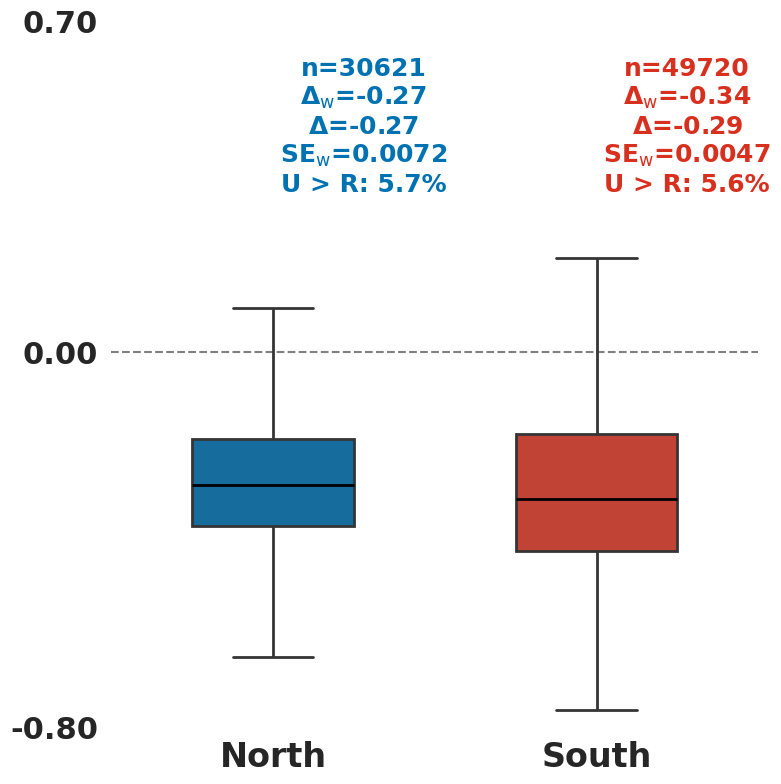

In [18]:
from __future__ import annotations
import sys
from pathlib import Path
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ─────────────────────────────────────────────────────────────────────
# CONFIG
# ─────────────────────────────────────────────────────────────────────
INPUT_CSV   = Path('/content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries_global_ns.csv')
OUTPUT_FIG  = Path('/content/Fig1C_areaWeighted.pdf')
GROUP_COL   = 'GlobalNS'
FEATURE     = 'veg_frac_difference'
PLOT_ORDER  = ['North', 'South']  # keep 'North' left

# Colors (Okabe–Ito blue; Vermilion)
COLORS = {'North': '#0072B2', 'South': '#d7301f'}

# Vegetation classes for TOTAL vegetation areas (adjust if your schema differs)
VEG_TYPES: List[str] = [
    "cropland", "grassland", "herbaceous_wetland",
    "mangroves", "moss_and_lichen", "shrubland", "tree_cover"
]


# ─────────────────────────────────────────────────────────────────────
# HELPERS
# ─────────────────────────────────────────────────────────────────────
def _safe_y_limits(values: pd.Series) -> Tuple[float, float]:
    """Keep 0 in range with small padding."""
    v = pd.to_numeric(values, errors='coerce').dropna().astype(float)
    if v.empty:
        return (-1.0, 1.0)
    vmin, vmax = float(np.min(v)), float(np.max(v))
    vmin = min(vmin, 0.0); vmax = max(vmax, 0.0)
    if np.isclose(vmin, vmax):
        pad = max(abs(vmax), 0.01) * 0.1
        vmin, vmax = vmax - pad, vmax + pad
    span = vmax - vmin
    return (vmin - 0.02 * span, vmax + 0.02 * span)


def _kish_weighted_mean_se(x: np.ndarray, w: np.ndarray) -> Tuple[float, float, float, int]:
    """
    Kish-weighted mean and SE:
      μ_w   = Σ w x / Σ w
      Var_w = Σ w (x − μ_w)^2 / Σ w
      n_eff = (Σ w)^2 / Σ w^2
      SE_w  = sqrt(Var_w / n_eff)
    Returns (mean_w, se_w, n_eff, n_raw)
    """
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[m], w[m]
    n_raw = int(x.size)
    if n_raw == 0:
        return (np.nan, np.nan, 0.0, 0)
    W = float(np.sum(w))
    mu_w = float(np.sum(w * x) / W)
    var_w = float(np.sum(w * (x - mu_w) ** 2) / W)
    w2 = float(np.sum(w * w))
    n_eff = (W * W) / w2 if w2 > 0 else 0.0
    se_w = float(np.sqrt(var_w / max(n_eff, 1.0))) if np.isfinite(var_w) else np.nan
    return (mu_w, se_w, n_eff, n_raw)


def _group_ratio_of_sums(df_g: pd.DataFrame, urban_cols: List[str], rural_cols: List[str]) -> float:
    """
    Group-level difference via ratio-of-sums:
      (Σ veg_area_urban / Σ Urban_Area) − (Σ veg_area_rural / Σ Buffer_area)
    """
    u_area = float(df_g['Urban_Area'].sum())
    r_area = float(df_g['Buffer_area'].sum())
    if u_area <= 0 or r_area <= 0:
        return np.nan
    u_num = float(df_g[urban_cols].sum(axis=1).sum())
    r_num = float(df_g[rural_cols].sum(axis=1).sum())
    return (u_num / u_area) - (r_num / r_area)


def _ext_from_path(p: Path) -> str:
    ext = p.suffix.lower().lstrip('.')
    return ext if ext in {'pdf', 'png', 'svg'} else 'pdf'


# ─────────────────────────────────────────────────────────────────────
# PLOTTING
# ─────────────────────────────────────────────────────────────────────
def create_minimalistic_boxplot(data: pd.DataFrame,
                                feature: str,
                                stats_w: Dict[str, Dict[str, float]],
                                output_path: Path) -> None:
    if data.empty:
        raise ValueError(f"No data available for plotting '{feature}'.")

    plt.rcParams.update({'font.size': 24})
    sns.set(style="white")
    fig = plt.figure(figsize=(8, 8), facecolor="none")
    ax = plt.gca()
    ax.set_facecolor("none")

    # Unweighted boxplot (distribution shape); weighted stats in annotations
    sns.boxplot(
        x=GROUP_COL, y=feature, data=data, order=PLOT_ORDER,
        width=0.5, showfliers=False, palette=COLORS,
        boxprops={'alpha': 1, 'linewidth': 2},
        whiskerprops={'linewidth': 2},
        capprops={'linewidth': 2},
        medianprops={'linewidth': 2, 'color': 'black'}
    )

    # Reference line at 0
    ax.axhline(0, color='grey', linestyle='--', linewidth=1.5, zorder=0)

    # y-limits and ticks
    ymin, ymax = _safe_y_limits(data[feature])
    ax.set_ylim(ymin, ymax)
    ax.set_yticks([ax.get_ylim()[0], 0, ax.get_ylim()[1]])
    ax.set_yticklabels([f"{ax.get_ylim()[0]:.2f}", "0.00", f"{ax.get_ylim()[1]:.2f}"])

    # Minimal axes
    sns.despine(left=True, bottom=True, trim=True, offset=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    plt.yticks(fontsize=22, fontweight='bold')
    plt.xticks(fontsize=24, fontweight='bold')

    # AREA-WEIGHTED μ_w / SE_w + simple μ + RAW n + % U > R (mathtext)
    y0, y1 = ax.get_ylim()
    for i, label in enumerate(PLOT_ORDER):
        st = stats_w.get(label)
        if not st:
            continue
        y_pos = y1 - 0.05 * (y1 - y0)  # 5% below top
        ann = (
            f"n={st['n_raw']}\n"
            r"$\boldsymbol{\Delta}_{\mathrm{w}}$" + f"={st['mean_w']:.2f}\n"
            r"$\boldsymbol{\Delta}$"               + f"={st['mu_simple']:.2f}\n"
            r"$\mathbf{SE}_{\mathrm{w}}$"       + f"={st['se_w']:.4f}\n"
            f"U > R: {st['pct_pos']:.1f}%"
        )
        ax.text(
            i + 0.28, y_pos, ann,
            ha='center', va='top', fontsize=18, fontweight='bold',
            color=COLORS.get(label, 'black')
        )

    plt.tight_layout()
    output_path.parent.mkdir(parents=True, exist_ok=True)
    fmt = _ext_from_path(output_path)
    plt.savefig(output_path, dpi=400, bbox_inches='tight', format=fmt, transparent=True)
    print(f"Figure saved → {output_path}")
    plt.show()


# ─────────────────────────────────────────────────────────────────────
# PIPELINE
# ─────────────────────────────────────────────────────────────────────
def vegetation_difference_analysis(file_path: Path, output_path: Path) -> None:
    if not file_path.is_file():
        raise FileNotFoundError(f"The file '{file_path}' does not exist.")

    try:
        df = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        raise IOError(f"Error reading '{file_path}': {e}")

    # Column lists
    urban_veg_cols = [f"{v}_area_urban" for v in VEG_TYPES]
    rural_veg_cols = [f"{v}_area_rural" for v in VEG_TYPES]
    required_cols = urban_veg_cols + rural_veg_cols + ['Urban_Area', 'Buffer_area', GROUP_COL]

    # Validate
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Coerce numerics
    for col in urban_veg_cols + rural_veg_cols + ['Urban_Area', 'Buffer_area']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Clean / filter
    df = df.dropna(subset=required_cols).copy()
    df = df[(df['Urban_Area'] > 0) & (df['Buffer_area'] > 0)].copy()
    if df.empty:
        raise ValueError("No valid rows remain after cleaning and positive-area filtering.")

    # Compute per-city vegetation fractions and difference
    df['urban_veg_frac'] = df[urban_veg_cols].sum(axis=1) / df['Urban_Area']
    df['rural_veg_frac'] = df[rural_veg_cols].sum(axis=1) / df['Buffer_area']
    df[FEATURE] = df['urban_veg_frac'] - df['rural_veg_frac']

    # Keep North/South; order fixed
    df = df[df[GROUP_COL].isin(PLOT_ORDER)].copy()
    if df.empty:
        raise ValueError(f"No rows with groups in {PLOT_ORDER}.")
    df[GROUP_COL] = pd.Categorical(df[GROUP_COL], categories=PLOT_ORDER, ordered=True)

    # Weights for city-level diff_i (cover both domains)
    df['w_diff'] = df['Urban_Area'] + df['Buffer_area']
    df = df[df['w_diff'] > 0].copy()

    print(f"Data after cleaning: {df.shape}")
    print(f"Unique {GROUP_COL} values: {list(df[GROUP_COL].unique())}")

    # AREA-WEIGHTED stats per group + ratio-of-sums + % U>R
    stats_weighted: Dict[str, Dict[str, float]] = {}
    for g in PLOT_ORDER:
        gdf = df[df[GROUP_COL] == g].copy()
        x = gdf[FEATURE].to_numpy()
        w = gdf['w_diff'].to_numpy()

        mean_w, se_w, n_eff, n_raw = _kish_weighted_mean_se(x, w)
        mu_simple = float(np.nanmean(x)) if x.size else float('nan')
        ros = _group_ratio_of_sums(gdf, urban_veg_cols, rural_veg_cols)
        n_pos = int((gdf[FEATURE] > 0).sum())
        pct_pos = 100.0 * n_pos / n_raw if n_raw > 0 else np.nan

        stats_weighted[g] = {
            'mean_w': mean_w,
            'se_w': se_w,
            'n_eff': n_eff,
            'n_raw': n_raw,
            'mu_simple': mu_simple,
            'ratio_of_sums': ros,
            'pct_pos': pct_pos
        }

        # Console diagnostics
        print(f"\n[{g}] Area-weighted stats for {FEATURE}:")
        print(f"  n_raw (cities)                  : {n_raw}")
        print(f"  n_eff (Kish)                    : {n_eff:.1f}")
        print(f"  μ_w (weighted mean of diffs)    : {mean_w:.4f}")
        print(f"  SE_w (weighted)                 : {se_w:.4f}")
        print(f"  Δ (ratio-of-sums, group-level)  : {ros:.4f}")
        print(f"  U > R                           : {n_pos} / {n_raw} ({pct_pos:.1f}%)")

    # Plot (boxplots show distribution; annotations are weighted + %)
    create_minimalistic_boxplot(df, FEATURE, stats_weighted, output_path)


def main() -> None:
    try:
        vegetation_difference_analysis(INPUT_CSV, OUTPUT_FIG)
    except (FileNotFoundError, ValueError, IOError) as e:
        print(f"[ERROR] {e}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"[ERROR] Unexpected: {e}", file=sys.stderr)
        sys.exit(2)


if __name__ == '__main__':
    main()


###all veg climate

In [19]:
from __future__ import annotations
import math
import sys
from pathlib import Path
from typing import Dict, Tuple, Optional, List

import numpy as np
import pandas as pd
from scipy.stats import wilcoxon, f_oneway

# ────────────────────────── USER CONFIG ──────────────────────────
CSV_PATH = Path("/content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries_global_ns.csv")
SAVE_DIR = "/content/ns_outputs_climate"  # e.g., Path("/content/ns_outputs"); None → do not write file
TOP_N    = 1000

URBAN_AREA_COL = "Urban_Area"
RURAL_AREA_COL = "Buffer_area"
KOPPEN_COL     = "koppen_name_urban"

# Vegetation classes (edit if columns differ)
VEG_TYPES: Dict[str, Tuple[str, str]] = {
    "Cropland":           ("cropland_area_urban",           "cropland_area_rural"),
    "Grassland":          ("grassland_area_urban",          "grassland_area_rural"),
    "HerbaceousWetland":  ("herbaceous_wetland_area_urban", "herbaceous_wetland_area_rural"),
    "Mangroves":          ("mangroves_area_urban",          "mangroves_area_rural"),
    "MossLichen":         ("moss_and_lichen_area_urban",    "moss_and_lichen_area_rural"),
    "Shrubland":          ("shrubland_area_urban",          "shrubland_area_rural"),
    "TreeCover":          ("tree_cover_area_urban",         "tree_cover_area_rural"),
}

KOPPEN_MAP = {"A": "Tropical", "B": "Arid", "C": "Temperate", "D": "Continental"}
CLIMATE_ORDER = ["Arid", "Tropical", "Temperate", "Continental"]

PCT_COLS = ["% U>R", "% U<R", "% U=R"]

# ────────────────────────── HELPERS ──────────────────────────────

def _coerce_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def _kish_weighted_mean_se(x: pd.Series, w: pd.Series) -> Tuple[float, float]:
    x = _coerce_num(x)
    w = _coerce_num(w)
    m = x.notna() & w.notna() & np.isfinite(x) & np.isfinite(w) & (w > 0)
    x = x[m].to_numpy(dtype=float)
    w = w[m].to_numpy(dtype=float)

    if x.size == 0:
        return (np.nan, np.nan)

    W = float(w.sum())
    if W <= 0:
        return (np.nan, np.nan)

    mu_w = float(np.dot(w, x) / W)
    w2 = float(np.dot(w, w))
    n_eff = (W * W) / w2 if w2 > 0 else np.nan

    var_w = float(np.dot(w, (x - mu_w) ** 2) / W)
    if not np.isfinite(var_w) or not np.isfinite(n_eff) or n_eff <= 0:
        return (mu_w, np.nan)

    se_w = float(math.sqrt(var_w / n_eff))
    return (mu_w, se_w)

def _mean_se(x: pd.Series) -> Tuple[float, float, int]:
    x = _coerce_num(x).dropna()
    n = int(x.size)
    if n == 0:
        return (np.nan, np.nan, 0)
    mu = float(x.mean())
    se = float(x.std(ddof=1) / math.sqrt(n)) if n > 1 else np.nan
    return (mu, se, n)

def _fmt(v):
    """Default formatter: 4 decimal places for floats."""
    if v is None:
        return ""
    if isinstance(v, (float, np.floating)):
        if not np.isfinite(v):
            return ""
        return f"{v:.4f}"
    if isinstance(v, (int, np.integer)):
        return f"{v:d}"
    if v == "":
        return ""
    return str(v)

def _fmt_pct(v):
    """Formatter for percentage columns: max 2 decimal places."""
    if v is None:
        return ""
    if isinstance(v, (float, np.floating)):
        if not np.isfinite(v):
            return ""
        s = f"{v:.2f}"
        # Strip trailing zeros and decimal point → "12.30" → "12.3"; "12.00" → "12"
        s = s.rstrip("0").rstrip(".")
        return s
    if isinstance(v, (int, np.integer)):
        return f"{v:d}"
    if v == "":
        return ""
    return str(v)

def _rank_biserial_from_wilcoxon(T: float, n: int) -> Optional[float]:
    """
    For Wilcoxon signed-rank:

      T = smaller of positive/negative rank sums (SciPy's wilcoxon statistic)
      R = n(n+1)/2
      |r_rb| = 1 - 2T/R

    This function returns the **magnitude** |r_rb|.
    The sign is attached later using sign(Δ) so that r
    has the same direction as the mean difference.
    """
    if not np.isfinite(T) or n <= 0:
        return None
    R = n * (n + 1) / 2.0
    if R <= 0:
        return None
    return 1.0 - (2.0 * T / R)

# ────────────────────────── ETL ───────────────────────────────────

def _load_and_prepare(csv_path: Path) -> pd.DataFrame:
    if not csv_path.is_file():
        raise FileNotFoundError(f"CSV not found: {csv_path}")

    df = pd.read_csv(csv_path, low_memory=False)

    required = [URBAN_AREA_COL, RURAL_AREA_COL, KOPPEN_COL]
    for u, r in VEG_TYPES.values():
        required.extend([u, r])

    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Coerce numeric
    for c in set(required) - {KOPPEN_COL}:
        df[c] = _coerce_num(df[c])

    # Guard denominators
    df[URBAN_AREA_COL] = df[URBAN_AREA_COL].replace(0, np.nan)
    df[RURAL_AREA_COL] = df[RURAL_AREA_COL].replace(0, np.nan)

    # Drop missing essentials
    df = df.dropna(subset=[URBAN_AREA_COL, RURAL_AREA_COL, KOPPEN_COL]).copy()

    # Aggregate veg areas
    urban_cols = [u for (u, _) in VEG_TYPES.values()]
    rural_cols = [r for (_, r) in VEG_TYPES.values()]
    df["total_veg_urban"] = df[urban_cols].sum(axis=1, min_count=1)
    df["total_veg_rural"] = df[rural_cols].sum(axis=1, min_count=1)
    df = df.dropna(subset=["total_veg_urban", "total_veg_rural"]).copy()

    # Fractions
    df["veg_frac_urban"] = df["total_veg_urban"] / df[URBAN_AREA_COL]
    df["veg_frac_rural"] = df["total_veg_rural"] / df[RURAL_AREA_COL]
    df["veg_frac_diff"]  = df["veg_frac_urban"] - df["veg_frac_rural"]

    # Climate classes from Köppen
    def map_koppen(val: str) -> Optional[str]:
        if not isinstance(val, str) or len(val) == 0:
            return None
        return KOPPEN_MAP.get(val[0])

    df["Climate"] = df[KOPPEN_COL].astype(str).map(map_koppen)
    df = df.dropna(subset=["Climate", "veg_frac_diff"]).copy()
    df["Climate"] = pd.Categorical(df["Climate"],
                                   categories=CLIMATE_ORDER,
                                   ordered=True)

    # Weights for diff
    df["w_diff"] = df[URBAN_AREA_COL] + df[RURAL_AREA_COL]
    df = df[df["w_diff"] > 0].copy()

    if df.empty:
        raise ValueError("No valid rows after cleaning and weighting constraints.")

    return df

def _top_n_by_urban_area(df: pd.DataFrame, n: int) -> pd.DataFrame:
    if n is None or n <= 0 or df.empty:
        return df
    n = min(n, len(df))
    # keep ties deterministically using nlargest with keep="all"
    return df.nlargest(n, URBAN_AREA_COL, keep="all").copy()

# ────────────────────────── SCOPE-WISE SUMMARY ─────────────────────

def _summarize_scope(df: pd.DataFrame, cohort_label: str) -> pd.DataFrame:
    rows = []
    groups_for_anova: List[np.ndarray] = []

    for clim in CLIMATE_ORDER:
        sub = df[df["Climate"] == clim]
        if sub.empty:
            continue

        # Urban / Rural stats
        u_mu, u_se, u_n = _mean_se(sub["veg_frac_urban"])
        r_mu, r_se, r_n = _mean_se(sub["veg_frac_rural"])

        # Weighted (Kish)
        u_mu_w, u_se_w = _kish_weighted_mean_se(sub["veg_frac_urban"], sub[URBAN_AREA_COL])
        r_mu_w, r_se_w = _kish_weighted_mean_se(sub["veg_frac_rural"],  sub[RURAL_AREA_COL])

        # Differences
        diff = _coerce_num(sub["veg_frac_diff"]).dropna()
        n_diff = int(diff.size)
        delta = float(diff.mean()) if n_diff > 0 else np.nan

        # Weighted Δw using w_diff
        if n_diff > 0:
            x = diff.to_numpy()
            w = _coerce_num(sub.loc[diff.index, "w_diff"]).to_numpy()
            m = np.isfinite(x) & np.isfinite(w) & (w > 0)
            x, w = x[m], w[m]
            if x.size > 0 and w.sum() > 0:
                delta_w = float(np.dot(w, x) / w.sum())
            else:
                delta_w = np.nan
        else:
            delta_w = np.nan

        # Wilcoxon signed-rank on diff vs 0 (paired U-R within climate)
        if n_diff >= 5 and np.any(diff != 0):
            try:
                T, p_w = wilcoxon(diff, zero_method="wilcox", alternative="two-sided")
            except Exception:
                T, p_w = (np.nan, np.nan)
        else:
            T, p_w = (np.nan, np.nan)

        # Cohen's d for diff vs 0
        if n_diff > 1:
            sd_diff = float(diff.std(ddof=1))
            d = float(delta / sd_diff) if (sd_diff > 0 and np.isfinite(sd_diff)) else np.nan
        else:
            d = np.nan

        # Rank-biserial r: magnitude from Wilcoxon, sign from Δ
        if np.isfinite(T) and n_diff > 0:
            r_mag = _rank_biserial_from_wilcoxon(float(T), n_diff)
            if r_mag is not None and np.isfinite(delta) and delta != 0:
                r_rb = float(np.sign(delta) * r_mag)
            else:
                r_rb = None
        else:
            r_rb = None

        # % U>R, % U<R, % U=R
        if n_diff > 0:
            pct_ur = float((diff > 0).mean() * 100.0)
            pct_lr = float((diff < 0).mean() * 100.0)
            pct_eq = float(np.isclose(diff, 0.0, atol=1e-6).mean() * 100.0)
        else:
            pct_ur = pct_lr = pct_eq = np.nan

        # For ANOVA across climates within this scope
        if n_diff > 0:
            groups_for_anova.append(diff.to_numpy())

        rows.append({
            "Climate": clim,
            "Cohort": cohort_label,
            "Urban μ": u_mu,
            "Urban SE": u_se,
            "Urban μw": u_mu_w,
            "Urban SEw": u_se_w,
            "Rural μ": r_mu,
            "Rural SE": r_se,
            "Rural μw": r_mu_w,
            "Rural SEw": r_se_w,
            "Δ": delta,
            "Δw": delta_w,
            "Cohen's d": d,
            "Rank-biserial r": r_rb if r_rb is not None else np.nan,
            "Test Statistic": T,
            "p-value": p_w,
            "n": n_diff,
            "% U>R": pct_ur,
            "% U<R": pct_lr,
            "% U=R": pct_eq,
        })

    # One-way ANOVA on diff across climates within this scope
    F_anova = np.nan
    p_anova = np.nan
    eta2 = np.nan
    valid_groups = [g for g in groups_for_anova if g.size > 1]
    if len(valid_groups) >= 2:
        try:
            F_anova, p_anova = f_oneway(*valid_groups)
            k = len(valid_groups)
            N = float(sum(len(g) for g in valid_groups))
            # η² = SSB / SST approximated via F:
            # η² = F*(k-1) / (F*(k-1) + (N-k))
            if np.isfinite(F_anova) and N > k:
                eta2 = float((F_anova * (k - 1)) /
                             (F_anova * (k - 1) + (N - k)))
        except Exception:
            F_anova = p_anova = eta2 = np.nan

    out = pd.DataFrame(rows)

    # Attach global ANOVA columns for this scope
    out["ANOVA F"] = F_anova
    out["ANOVA η²"] = eta2
    out["ANOVA p-value"] = p_anova

    # Sort by climate order
    out["Climate"] = pd.Categorical(out["Climate"],
                                    categories=CLIMATE_ORDER,
                                    ordered=True)
    out = out.sort_values(["Cohort", "Climate"]).reset_index(drop=True)

    # Round numeric columns (4 d.p. for most; 2 d.p. for % columns)
    num_cols_4 = [
        "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
        "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
        "Δ", "Δw",
        "Cohen's d", "Rank-biserial r",
        "Test Statistic", "p-value",
        "ANOVA F", "ANOVA η²", "ANOVA p-value",
    ]
    for c in num_cols_4:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce").round(4)

    for c in PCT_COLS:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce").round(2)

    return out

# ────────────────────────── MAIN ───────────────────────────────────

def main():
    try:
        df_all = _load_and_prepare(CSV_PATH)
        print(f"[OK] Loaded {df_all.shape[0]:,} rows × {df_all.shape[1]:,} cols after cleaning.")

        # All cities
        summary_all = _summarize_scope(df_all, cohort_label="All cities")

        # Top 1000 by Urban_Area (Major cities)
        df_top = _top_n_by_urban_area(df_all, TOP_N)
        if df_top.empty:
            print(f"[WARN] TOP_{TOP_N} subset is empty; only All cities will be reported.")
            summary_top = pd.DataFrame(columns=summary_all.columns)
        else:
            print(f"[OK] TOP_{TOP_N}: {df_top.shape[0]:,} rows selected for Major cities.")
            summary_top = _summarize_scope(df_top, cohort_label="Major cities")

        # Combined table
        summary = pd.concat([summary_all, summary_top], ignore_index=True)

        # Console table
        print("\n=== VEGETATION FRACTION × CLIMATE × COHORT SUMMARY TABLE ===")
        # Column-specific formatters: 2 d.p. max for % columns, 4 d.p. for others
        formatters = {
            col: (_fmt_pct if col in PCT_COLS else _fmt)
            for col in summary.columns
        }
        with pd.option_context("display.max_rows", None,
                               "display.max_columns", None):
            print(summary.to_string(
                index=False,
                formatters=formatters
            ))

        # CSV block for direct copy
        print("\n=== VEGETATION FRACTION × CLIMATE × COHORT SUMMARY TABLE CSV ===")
        # Per-column rounding already applied; no global float_format so % stay at 2 d.p.
        print(summary.to_csv(index=False, na_rep=""))

        # Optional save
        if SAVE_DIR:
            out_dir = Path(SAVE_DIR)
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / "veg_climate_fraction_summary_table.csv"
            summary.to_csv(out_path, index=False, na_rep="")
            print(f"[OK] Saved: {out_path}")

    except (FileNotFoundError, ValueError) as e:
        print(f"[ERROR] {e}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"[ERROR] Unexpected failure: {e.__class__.__name__}: {e}", file=sys.stderr)
        raise

if __name__ == "__main__":
    main()


[OK] Loaded 82,790 rows × 40 cols after cleaning.
[OK] TOP_1000: 1,000 rows selected for Major cities.

=== VEGETATION FRACTION × CLIMATE × COHORT SUMMARY TABLE ===
    Climate       Cohort Urban μ Urban SE Urban μw Urban SEw Rural μ Rural SE Rural μw Rural SEw       Δ      Δw Cohen's d Rank-biserial r Test Statistic p-value     n % U>R % U<R % U=R  ANOVA F ANOVA η² ANOVA p-value
       Arid   All cities  0.2473   0.0018   0.1899    0.0105  0.5429   0.0021   0.5243    0.0151 -0.2957 -0.3296   -1.3566         -0.9165   3622904.0000  0.0000 13173 10.13 89.22  0.65 542.6958   0.0193        0.0000
   Tropical   All cities  0.4172   0.0024   0.3597    0.0144  0.7006   0.0016   0.6792    0.0096 -0.2834 -0.3139   -1.5881         -0.9583   1128282.0000  0.0000 10406  9.08 90.92     0 542.6958   0.0193        0.0000
  Temperate   All cities  0.4676   0.0010   0.4068    0.0070  0.7538   0.0008   0.7177    0.0050 -0.2861 -0.3038   -1.8714         -0.9776  10894987.0000  0.0000 44127  4.33 95.67  

In [20]:
from __future__ import annotations
import math
import sys
from pathlib import Path
from typing import Dict, Tuple, Optional, List

import numpy as np
import pandas as pd
from scipy.stats import wilcoxon, f_oneway

# ────────────────────────── USER CONFIG ──────────────────────────
CSV_PATH = Path("/content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries_global_ns.csv")
SAVE_DIR = "/content/ns_outputs_climate_lc"  # None → do not write file
TOP_N    = 1000

URBAN_AREA_COL = "Urban_Area"
RURAL_AREA_COL = "Buffer_area"
KOPPEN_COL     = "koppen_name_urban"

# Land-cover types and their columns
LC_TYPES: Dict[str, Tuple[str, str]] = {
    "Tree cover": ("tree_cover_area_urban", "tree_cover_area_rural"),
    "Grassland":  ("grassland_area_urban",  "grassland_area_rural"),
    "Cropland":   ("cropland_area_urban",   "cropland_area_rural"),
    "Shrubland":  ("shrubland_area_urban",  "shrubland_area_rural"),
}

KOPPEN_MAP = {"A": "Tropical", "B": "Arid", "C": "Temperate", "D": "Continental"}
CLIMATE_ORDER = ["Arid", "Tropical", "Temperate", "Continental"]
LC_ORDER = ["Tree cover", "Grassland", "Cropland", "Shrubland"]

# ────────────────────────── HELPERS ──────────────────────────────

def _coerce_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def _kish_weighted_mean_se(x: pd.Series, w: pd.Series) -> Tuple[float, float]:
    x = _coerce_num(x)
    w = _coerce_num(w)
    m = x.notna() & w.notna() & np.isfinite(x) & np.isfinite(w) & (w > 0)
    x = x[m].to_numpy(dtype=float)
    w = w[m].to_numpy(dtype=float)

    if x.size == 0:
        return (np.nan, np.nan)

    W = float(w.sum())
    if W <= 0:
        return (np.nan, np.nan)

    mu_w = float(np.dot(w, x) / W)
    w2 = float(np.dot(w, w))
    n_eff = (W * W) / w2 if w2 > 0 else np.nan

    var_w = float(np.dot(w, (x - mu_w) ** 2) / W)
    if not np.isfinite(var_w) or not np.isfinite(n_eff) or n_eff <= 0:
        return (mu_w, np.nan)

    se_w = float(math.sqrt(var_w / n_eff))
    return (mu_w, se_w)

def _mean_se(x: pd.Series) -> Tuple[float, float, int]:
    x = _coerce_num(x).dropna()
    n = int(x.size)
    if n == 0:
        return (np.nan, np.nan, 0)
    mu = float(x.mean())
    se = float(x.std(ddof=1) / math.sqrt(n)) if n > 1 else np.nan
    return (mu, se, n)

def _fmt(v: object) -> str:
    if v is None:
        return ""
    if isinstance(v, (float, np.floating)):
        if not np.isfinite(v):
            return ""
        return f"{v:.4f}"
    if isinstance(v, (int, np.integer)):
        return f"{v:d}"
    if v == "":
        return ""
    return str(v)

# ────────────────────────── ETL ───────────────────────────────────

def _load_base(csv_path: Path) -> pd.DataFrame:
    if not csv_path.is_file():
        raise FileNotFoundError(f"CSV not found: {csv_path}")

    df = pd.read_csv(csv_path, low_memory=False)

    required = [URBAN_AREA_COL, RURAL_AREA_COL, KOPPEN_COL]
    for u, r in LC_TYPES.values():
        required.extend([u, r])

    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Coerce numeric for all but Koppen
    for c in set(required) - {KOPPEN_COL}:
        df[c] = _coerce_num(df[c])

    # Guard denominators
    df[URBAN_AREA_COL] = df[URBAN_AREA_COL].replace(0, np.nan)
    df[RURAL_AREA_COL] = df[RURAL_AREA_COL].replace(0, np.nan)

    # Drop missing essentials
    df = df.dropna(subset=[URBAN_AREA_COL, RURAL_AREA_COL, KOPPEN_COL]).copy()

    # Climate classes from Köppen first letter
    def map_koppen(val: str) -> Optional[str]:
        if not isinstance(val, str) or len(val) == 0:
            return None
        return KOPPEN_MAP.get(val[0])

    df["Climate"] = df[KOPPEN_COL].astype(str).map(map_koppen)
    df = df.dropna(subset=["Climate"]).copy()
    df["Climate"] = pd.Categorical(df["Climate"],
                                   categories=CLIMATE_ORDER,
                                   ordered=True)

    return df

def _top_n_by_urban_area(df: pd.DataFrame, n: int) -> pd.DataFrame:
    if n is None or n <= 0 or df.empty:
        return df
    n = min(n, len(df))
    # keep="all" to retain ties deterministically
    return df.nlargest(n, URBAN_AREA_COL, keep="all").copy()

# ────────────────────────── SUMMARIES ─────────────────────────────

def _summarize_scope_for_lc(
    df: pd.DataFrame,
    lc_name: str,
    urb_col: str,
    rur_col: str,
    cohort_label: str,
) -> pd.DataFrame:
    """
    Summarize one land-cover type for a given cohort (All / Major).
    """
    # Work on a copy with LC-specific fractions and diffs
    sub = df.copy()

    # Drop rows without valid LC areas
    sub = sub.dropna(subset=[urb_col, rur_col]).copy()

    # Fractions
    sub["frac_urban"] = sub[urb_col] / sub[URBAN_AREA_COL]
    sub["frac_rural"] = sub[rur_col] / sub[RURAL_AREA_COL]
    sub["diff"] = sub["frac_urban"] - sub["frac_rural"]

    # Total weight for diff
    sub["w_diff"] = sub[URBAN_AREA_COL] + sub[RURAL_AREA_COL]
    sub = sub.dropna(subset=["frac_urban", "frac_rural", "diff", "w_diff"]).copy()
    sub = sub[sub["w_diff"] > 0]

    rows: List[dict] = []
    groups_for_anova: List[np.ndarray] = []

    for clim in CLIMATE_ORDER:
        csub = sub[sub["Climate"] == clim]
        if csub.empty:
            continue

        # Urban / Rural stats
        u_mu, u_se, u_n = _mean_se(csub["frac_urban"])
        r_mu, r_se, r_n = _mean_se(csub["frac_rural"])

        # Weighted fractions
        u_mu_w, u_se_w = _kish_weighted_mean_se(csub["frac_urban"], csub[URBAN_AREA_COL])
        r_mu_w, r_se_w = _kish_weighted_mean_se(csub["frac_rural"],  csub[RURAL_AREA_COL])

        # Differences
        diff = _coerce_num(csub["diff"]).dropna()
        n_diff = int(diff.size)
        delta = float(diff.mean()) if n_diff > 0 else np.nan

        # Weighted Δw using w_diff
        if n_diff > 0:
            x = diff.to_numpy()
            w = _coerce_num(csub.loc[diff.index, "w_diff"]).to_numpy()
            m = np.isfinite(x) & np.isfinite(w) & (w > 0)
            x, w = x[m], w[m]
            if x.size > 0 and w.sum() > 0:
                delta_w = float(np.dot(w, x) / w.sum())
            else:
                delta_w = np.nan
        else:
            delta_w = np.nan

        # Wilcoxon signed-rank on diff vs 0
        if n_diff >= 5 and np.any(diff != 0):
            try:
                T, p_w = wilcoxon(diff, zero_method="wilcox", alternative="two-sided")
            except Exception:
                T, p_w = (np.nan, np.nan)
        else:
            T, p_w = (np.nan, np.nan)

        # Cohen's d (primary effect size) for diff vs 0
        if n_diff > 1:
            sd_diff = float(diff.std(ddof=1))
            d = float(delta / sd_diff) if (sd_diff > 0 and np.isfinite(sd_diff)) else np.nan
        else:
            d = np.nan

        # % U>R, % U<R, % U=R
        if n_diff > 0:
            pct_ur = float((diff > 0).mean() * 100.0)
            pct_lr = float((diff < 0).mean() * 100.0)
            pct_eq = float(np.isclose(diff, 0.0, atol=1e-6).mean() * 100.0)
        else:
            pct_ur = pct_lr = pct_eq = np.nan

        # For ANOVA across climates within this LC × cohort
        if n_diff > 0:
            groups_for_anova.append(diff.to_numpy())

        rows.append({
            "Variable": lc_name,
            "Climate": clim,
            "Cohort": cohort_label,
            "Urban μ": u_mu,
            "Urban SE": u_se,
            "Urban μw": u_mu_w,
            "Urban SEw": u_se_w,
            "Rural μ": r_mu,
            "Rural SE": r_se,
            "Rural μw": r_mu_w,
            "Rural SEw": r_se_w,
            "Δ": delta,
            "Δw": delta_w,
            "Cohen's d": d,
            "Test Statistic": T,
            "p-value": p_w,
            "n": n_diff,
            "% U>R": pct_ur,
            "% U<R": pct_lr,
            "% U=R": pct_eq,
        })

    # One-way ANOVA on diff across climates for this LC × cohort
    F_anova = np.nan
    p_anova = np.nan
    eta2 = np.nan
    valid_groups = [g for g in groups_for_anova if g.size > 1]
    if len(valid_groups) >= 2:
        try:
            F_anova, p_anova = f_oneway(*valid_groups)
            k = len(valid_groups)
            N = float(sum(len(g) for g in valid_groups))
            if np.isfinite(F_anova) and N > k:
                eta2 = float((F_anova * (k - 1)) /
                             (F_anova * (k - 1) + (N - k)))
        except Exception:
            F_anova = p_anova = eta2 = np.nan

    out = pd.DataFrame(rows)
    if not out.empty:
        out["ANOVA F"] = F_anova
        out["ANOVA η²"] = eta2
        out["ANOVA p-value"] = p_anova

        # Ensure climate ordering inside this LC × cohort
        out["Climate"] = pd.Categorical(out["Climate"],
                                        categories=CLIMATE_ORDER,
                                        ordered=True)
        out = out.sort_values(["Variable", "Cohort", "Climate"]).reset_index(drop=True)

        # Rounding
        float_cols_4 = [
            "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
            "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
            "Δ", "Δw",
            "Cohen's d",
            "Test Statistic", "p-value",
            "ANOVA F", "ANOVA η²", "ANOVA p-value",
        ]
        for c in float_cols_4:
            if c in out.columns:
                out[c] = pd.to_numeric(out[c], errors="coerce").round(4)

        # Percent columns to 2 d.p.
        for c in ["% U>R", "% U<R", "% U=R"]:
            if c in out.columns:
                out[c] = pd.to_numeric(out[c], errors="coerce").round(2)

    return out

# ────────────────────────── MAIN ───────────────────────────────────

def main():
    try:
        base = _load_base(CSV_PATH)
        print(f"[OK] Loaded {base.shape[0]:,} rows × {base.shape[1]:,} cols after base cleaning.")

        # Prepare TOP_N subset once (cohort-level, not per LC)
        top = _top_n_by_urban_area(base, TOP_N)
        have_top = not top.empty
        if have_top:
            print(f"[OK] TOP_{TOP_N}: {top.shape[0]:,} rows selected for Major cities.")
        else:
            print(f"[WARN] TOP_{TOP_N} subset empty; only All cities will be reported.")

        all_rows: List[pd.DataFrame] = []

        # Loop over land-cover types in desired order
        for lc_name in LC_ORDER:
            if lc_name not in LC_TYPES:
                continue
            urb_col, rur_col = LC_TYPES[lc_name]

            # All cities
            summ_all = _summarize_scope_for_lc(base, lc_name, urb_col, rur_col,
                                               cohort_label="All cities")
            if not summ_all.empty:
                all_rows.append(summ_all)

            # Major cities
            if have_top:
                summ_top = _summarize_scope_for_lc(top, lc_name, urb_col, rur_col,
                                                   cohort_label="Major cities")
                if not summ_top.empty:
                    all_rows.append(summ_top)

        if not all_rows:
            print("[ERROR] No summary rows generated.", file=sys.stderr)
            sys.exit(1)

        summary = pd.concat(all_rows, ignore_index=True)

        # Order rows: Variable (Tree, Grassland, Cropland, Shrubland),
        # then Cohort (All, Major), then Climate (Arid..Continental)
        summary["Variable"] = pd.Categorical(summary["Variable"],
                                             categories=LC_ORDER,
                                             ordered=True)
        summary["Cohort"] = pd.Categorical(summary["Cohort"],
                                           categories=["All cities", "Major cities"],
                                           ordered=True)
        summary["Climate"] = pd.Categorical(summary["Climate"],
                                            categories=CLIMATE_ORDER,
                                            ordered=True)

        summary = summary.sort_values(
            ["Variable", "Cohort", "Climate"]
        ).reset_index(drop=True)

        # Console table
        print("\n=== LAND-COVER FRACTION × CLIMATE × COHORT SUMMARY TABLE ===")
        with pd.option_context("display.max_rows", None,
                               "display.max_columns", None):
            print(summary.to_string(index=False,
                                    formatters={col: _fmt for col in summary.columns}))

        # CSV block
        print("\n=== LAND-COVER FRACTION × CLIMATE × COHORT SUMMARY TABLE CSV ===")
        print(summary.to_csv(index=False, float_format="%.4f", na_rep=""))

        # Optional save
        if SAVE_DIR:
            out_dir = Path(SAVE_DIR)
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / "lc_climate_fraction_summary_table.csv"
            summary.to_csv(out_path, index=False, float_format="%.4f", na_rep="")
            print(f"[OK] Saved: {out_path}")

    except (FileNotFoundError, ValueError) as e:
        print(f"[ERROR] {e}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"[ERROR] Unexpected failure: {e.__class__.__name__}: {e}", file=sys.stderr)
        raise

if __name__ == "__main__":
    main()


[OK] Loaded 82,790 rows × 34 cols after base cleaning.
[OK] TOP_1000: 1,000 rows selected for Major cities.

=== LAND-COVER FRACTION × CLIMATE × COHORT SUMMARY TABLE ===
  Variable     Climate       Cohort Urban μ Urban SE Urban μw Urban SEw Rural μ Rural SE Rural μw Rural SEw       Δ      Δw Cohen's d Test Statistic p-value     n   % U>R   % U<R   % U=R   ANOVA F ANOVA η² ANOVA p-value
Tree cover        Arid   All cities  0.0464   0.0008   0.0550    0.0050  0.0525   0.0007   0.0687    0.0058 -0.0061 -0.0143   -0.0882  30977602.0000  0.0000 13173 41.5500 52.1700  6.3000 1201.7142   0.0417        0.0000
Tree cover    Tropical   All cities  0.2044   0.0017   0.1859    0.0096  0.3091   0.0021   0.3083    0.0124 -0.1047 -0.1203   -0.8053   5652316.0000  0.0000 10406 18.3300 81.3900  0.2900 1201.7142   0.0417        0.0000
Tree cover   Temperate   All cities  0.2235   0.0008   0.2372    0.0061  0.2716   0.0010   0.3170    0.0065 -0.0481 -0.0813   -0.3365 312175804.0000  0.0000 44127 37.1100

In [21]:
from __future__ import annotations
import math
import sys
from pathlib import Path
from typing import Dict, Tuple, Optional, List

import numpy as np
import pandas as pd
from scipy.stats import wilcoxon, f_oneway

# ────────────────────────── USER CONFIG ──────────────────────────
CSV_PATH = Path("/content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries_global_ns.csv")
SAVE_DIR = "/content/ns_outputs_climate_lc"  # None → do not write file
TOP_N    = 1000

URBAN_AREA_COL = "Urban_Area"
RURAL_AREA_COL = "Buffer_area"
KOPPEN_COL     = "koppen_name_urban"

# Land-cover types and their columns
LC_TYPES: Dict[str, Tuple[str, str]] = {
    "Tree cover": ("tree_cover_area_urban", "tree_cover_area_rural"),
    "Grassland":  ("grassland_area_urban",  "grassland_area_rural"),
    "Cropland":   ("cropland_area_urban",   "cropland_area_rural"),
    "Shrubland":  ("shrubland_area_urban",  "shrubland_area_rural"),
}

KOPPEN_MAP = {"A": "Tropical", "B": "Arid", "C": "Temperate", "D": "Continental"}
CLIMATE_ORDER = ["Arid", "Tropical", "Temperate", "Continental"]
LC_ORDER = ["Tree cover", "Grassland", "Cropland", "Shrubland"]

# ────────────────────────── HELPERS ──────────────────────────────

def _coerce_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def _kish_weighted_mean_se(x: pd.Series, w: pd.Series) -> Tuple[float, float]:
    x = _coerce_num(x)
    w = _coerce_num(w)
    m = x.notna() & w.notna() & np.isfinite(x) & np.isfinite(w) & (w > 0)
    x = x[m].to_numpy(dtype=float)
    w = w[m].to_numpy(dtype=float)

    if x.size == 0:
        return (np.nan, np.nan)

    W = float(w.sum())
    if W <= 0:
        return (np.nan, np.nan)

    mu_w = float(np.dot(w, x) / W)
    w2 = float(np.dot(w, w))
    n_eff = (W * W) / w2 if w2 > 0 else np.nan

    var_w = float(np.dot(w, (x - mu_w) ** 2) / W)
    if not np.isfinite(var_w) or not np.isfinite(n_eff) or n_eff <= 0:
        return (mu_w, np.nan)

    se_w = float(math.sqrt(var_w / n_eff))
    return (mu_w, se_w)

def _mean_se(x: pd.Series) -> Tuple[float, float, int]:
    x = _coerce_num(x).dropna()
    n = int(x.size)
    if n == 0:
        return (np.nan, np.nan, 0)
    mu = float(x.mean())
    se = float(x.std(ddof=1) / math.sqrt(n)) if n > 1 else np.nan
    return (mu, se, n)

def _fmt(v: object) -> str:
    if v is None:
        return ""
    if isinstance(v, (float, np.floating)):
        if not np.isfinite(v):
            return ""
        return f"{v:.4f}"
    if isinstance(v, (int, np.integer)):
        return f"{v:d}"
    if v == "":
        return ""
    return str(v)

# ────────────────────────── ETL ───────────────────────────────────

def _load_base(csv_path: Path) -> pd.DataFrame:
    if not csv_path.is_file():
        raise FileNotFoundError(f"CSV not found: {csv_path}")

    df = pd.read_csv(csv_path, low_memory=False)

    required = [URBAN_AREA_COL, RURAL_AREA_COL, KOPPEN_COL]
    for u, r in LC_TYPES.values():
        required.extend([u, r])

    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Coerce numeric for all but Koppen
    for c in set(required) - {KOPPEN_COL}:
        df[c] = _coerce_num(df[c])

    # Guard denominators
    df[URBAN_AREA_COL] = df[URBAN_AREA_COL].replace(0, np.nan)
    df[RURAL_AREA_COL] = df[RURAL_AREA_COL].replace(0, np.nan)

    # Drop missing essentials
    df = df.dropna(subset=[URBAN_AREA_COL, RURAL_AREA_COL, KOPPEN_COL]).copy()

    # Climate classes from Köppen first letter
    def map_koppen(val: str) -> Optional[str]:
        if not isinstance(val, str) or len(val) == 0:
            return None
        return KOPPEN_MAP.get(val[0])

    df["Climate"] = df[KOPPEN_COL].astype(str).map(map_koppen)
    df = df.dropna(subset=["Climate"]).copy()
    df["Climate"] = pd.Categorical(df["Climate"],
                                   categories=CLIMATE_ORDER,
                                   ordered=True)

    return df

def _top_n_by_urban_area(df: pd.DataFrame, n: int) -> pd.DataFrame:
    if n is None or n <= 0 or df.empty:
        return df
    n = min(n, len(df))
    # keep="all" to retain ties deterministically
    return df.nlargest(n, URBAN_AREA_COL, keep="all").copy()

# ────────────────────────── SUMMARIES ─────────────────────────────

def _summarize_scope_for_lc(
    df: pd.DataFrame,
    lc_name: str,
    urb_col: str,
    rur_col: str,
    cohort_label: str,
) -> pd.DataFrame:
    """
    Summarize one land-cover type for a given cohort (All / Major).
    """
    # Work on a copy with LC-specific fractions and diffs
    sub = df.copy()

    # Drop rows without valid LC areas
    sub = sub.dropna(subset=[urb_col, rur_col]).copy()

    # Fractions
    sub["frac_urban"] = sub[urb_col] / sub[URBAN_AREA_COL]
    sub["frac_rural"] = sub[rur_col] / sub[RURAL_AREA_COL]
    sub["diff"] = sub["frac_urban"] - sub["frac_rural"]

    # Total weight for diff
    sub["w_diff"] = sub[URBAN_AREA_COL] + sub[RURAL_AREA_COL]
    sub = sub.dropna(subset=["frac_urban", "frac_rural", "diff", "w_diff"]).copy()
    sub = sub[sub["w_diff"] > 0]

    rows: List[dict] = []
    groups_for_anova: List[np.ndarray] = []

    for clim in CLIMATE_ORDER:
        csub = sub[sub["Climate"] == clim]
        if csub.empty:
            continue

        # Urban / Rural stats
        u_mu, u_se, u_n = _mean_se(csub["frac_urban"])
        r_mu, r_se, r_n = _mean_se(csub["frac_rural"])

        # Weighted fractions
        u_mu_w, u_se_w = _kish_weighted_mean_se(csub["frac_urban"], csub[URBAN_AREA_COL])
        r_mu_w, r_se_w = _kish_weighted_mean_se(csub["frac_rural"],  csub[RURAL_AREA_COL])

        # Differences
        diff = _coerce_num(csub["diff"]).dropna()
        n_diff = int(diff.size)
        delta = float(diff.mean()) if n_diff > 0 else np.nan

        # Weighted Δw using w_diff
        if n_diff > 0:
            x = diff.to_numpy()
            w = _coerce_num(csub.loc[diff.index, "w_diff"]).to_numpy()
            m = np.isfinite(x) & np.isfinite(w) & (w > 0)
            x, w = x[m], w[m]
            if x.size > 0 and w.sum() > 0:
                delta_w = float(np.dot(w, x) / w.sum())
            else:
                delta_w = np.nan
        else:
            delta_w = np.nan

        # Wilcoxon signed-rank on diff vs 0
        if n_diff >= 5 and np.any(diff != 0):
            try:
                T, p_w = wilcoxon(diff, zero_method="wilcox", alternative="two-sided")
            except Exception:
                T, p_w = (np.nan, np.nan)
        else:
            T, p_w = (np.nan, np.nan)

        # Cohen's d (primary effect size) for diff vs 0
        if n_diff > 1:
            sd_diff = float(diff.std(ddof=1))
            d = float(delta / sd_diff) if (sd_diff > 0 and np.isfinite(sd_diff)) else np.nan
        else:
            d = np.nan

        # % U>R, % U<R, % U=R
        if n_diff > 0:
            pct_ur = float((diff > 0).mean() * 100.0)
            pct_lr = float((diff < 0).mean() * 100.0)
            pct_eq = float(np.isclose(diff, 0.0, atol=1e-6).mean() * 100.0)
        else:
            pct_ur = pct_lr = pct_eq = np.nan

        # For ANOVA across climates within this LC × cohort
        if n_diff > 0:
            groups_for_anova.append(diff.to_numpy())

        rows.append({
            "Variable": lc_name,
            "Climate": clim,
            "Cohort": cohort_label,
            "Urban μ": u_mu,
            "Urban SE": u_se,
            "Urban μw": u_mu_w,
            "Urban SEw": u_se_w,
            "Rural μ": r_mu,
            "Rural SE": r_se,
            "Rural μw": r_mu_w,
            "Rural SEw": r_se_w,
            "Δ": delta,
            "Δw": delta_w,
            "Cohen's d": d,
            "Test Statistic": T,
            "p-value": p_w,
            "n": n_diff,
            "% U>R": pct_ur,
            "% U<R": pct_lr,
            "% U=R": pct_eq,
        })

    # One-way ANOVA on diff across climates for this LC × cohort
    F_anova = np.nan
    p_anova = np.nan
    eta2 = np.nan
    valid_groups = [g for g in groups_for_anova if g.size > 1]
    if len(valid_groups) >= 2:
        try:
            F_anova, p_anova = f_oneway(*valid_groups)
            k = len(valid_groups)
            N = float(sum(len(g) for g in valid_groups))
            if np.isfinite(F_anova) and N > k:
                eta2 = float((F_anova * (k - 1)) /
                             (F_anova * (k - 1) + (N - k)))
        except Exception:
            F_anova = p_anova = eta2 = np.nan

    out = pd.DataFrame(rows)
    if not out.empty:
        out["ANOVA F"] = F_anova
        out["ANOVA η²"] = eta2
        out["ANOVA p-value"] = p_anova

        # Ensure climate ordering inside this LC × cohort
        out["Climate"] = pd.Categorical(out["Climate"],
                                        categories=CLIMATE_ORDER,
                                        ordered=True)
        out = out.sort_values(["Variable", "Cohort", "Climate"]).reset_index(drop=True)

        # Rounding
        float_cols_4 = [
            "Urban μ", "Urban SE", "Urban μw", "Urban SEw",
            "Rural μ", "Rural SE", "Rural μw", "Rural SEw",
            "Δ", "Δw",
            "Cohen's d",
            "Test Statistic", "p-value",
            "ANOVA F", "ANOVA η²", "ANOVA p-value",
        ]
        for c in float_cols_4:
            if c in out.columns:
                out[c] = pd.to_numeric(out[c], errors="coerce").round(4)

        # Percent columns to 2 d.p.
        for c in ["% U>R", "% U<R", "% U=R"]:
            if c in out.columns:
                out[c] = pd.to_numeric(out[c], errors="coerce").round(2)

    return out

# ────────────────────────── MAIN ───────────────────────────────────

def main():
    try:
        base = _load_base(CSV_PATH)
        print(f"[OK] Loaded {base.shape[0]:,} rows × {base.shape[1]:,} cols after base cleaning.")

        # Prepare TOP_N subset once (cohort-level, not per LC)
        top = _top_n_by_urban_area(base, TOP_N)
        have_top = not top.empty
        if have_top:
            print(f"[OK] TOP_{TOP_N}: {top.shape[0]:,} rows selected for Major cities.")
        else:
            print(f"[WARN] TOP_{TOP_N} subset empty; only All cities will be reported.")

        all_rows: List[pd.DataFrame] = []

        # Loop over land-cover types in desired order
        for lc_name in LC_ORDER:
            if lc_name not in LC_TYPES:
                continue
            urb_col, rur_col = LC_TYPES[lc_name]

            # All cities
            summ_all = _summarize_scope_for_lc(base, lc_name, urb_col, rur_col,
                                               cohort_label="All cities")
            if not summ_all.empty:
                all_rows.append(summ_all)

            # Major cities
            if have_top:
                summ_top = _summarize_scope_for_lc(top, lc_name, urb_col, rur_col,
                                                   cohort_label="Major cities")
                if not summ_top.empty:
                    all_rows.append(summ_top)

        if not all_rows:
            print("[ERROR] No summary rows generated.", file=sys.stderr)
            sys.exit(1)

        summary = pd.concat(all_rows, ignore_index=True)

        # Order rows: Variable (Tree, Grassland, Cropland, Shrubland),
        # then Cohort (All, Major), then Climate (Arid..Continental)
        summary["Variable"] = pd.Categorical(summary["Variable"],
                                             categories=LC_ORDER,
                                             ordered=True)
        summary["Cohort"] = pd.Categorical(summary["Cohort"],
                                           categories=["All cities", "Major cities"],
                                           ordered=True)
        summary["Climate"] = pd.Categorical(summary["Climate"],
                                            categories=CLIMATE_ORDER,
                                            ordered=True)

        summary = summary.sort_values(
            ["Variable", "Cohort", "Climate"]
        ).reset_index(drop=True)

        # Console table
        print("\n=== LAND-COVER FRACTION × CLIMATE × COHORT SUMMARY TABLE ===")
        with pd.option_context("display.max_rows", None,
                               "display.max_columns", None):
            print(summary.to_string(index=False,
                                    formatters={col: _fmt for col in summary.columns}))

        # CSV block
        print("\n=== LAND-COVER FRACTION × CLIMATE × COHORT SUMMARY TABLE CSV ===")
        print(summary.to_csv(index=False, float_format="%.4f", na_rep=""))

        # Optional save
        if SAVE_DIR:
            out_dir = Path(SAVE_DIR)
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / "lc_climate_fraction_summary_table.csv"
            summary.to_csv(out_path, index=False, float_format="%.4f", na_rep="")
            print(f"[OK] Saved: {out_path}")

    except (FileNotFoundError, ValueError) as e:
        print(f"[ERROR] {e}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"[ERROR] Unexpected failure: {e.__class__.__name__}: {e}", file=sys.stderr)
        raise

if __name__ == "__main__":
    main()


[OK] Loaded 82,790 rows × 34 cols after base cleaning.
[OK] TOP_1000: 1,000 rows selected for Major cities.

=== LAND-COVER FRACTION × CLIMATE × COHORT SUMMARY TABLE ===
  Variable     Climate       Cohort Urban μ Urban SE Urban μw Urban SEw Rural μ Rural SE Rural μw Rural SEw       Δ      Δw Cohen's d Test Statistic p-value     n   % U>R   % U<R   % U=R   ANOVA F ANOVA η² ANOVA p-value
Tree cover        Arid   All cities  0.0464   0.0008   0.0550    0.0050  0.0525   0.0007   0.0687    0.0058 -0.0061 -0.0143   -0.0882  30977602.0000  0.0000 13173 41.5500 52.1700  6.3000 1201.7142   0.0417        0.0000
Tree cover    Tropical   All cities  0.2044   0.0017   0.1859    0.0096  0.3091   0.0021   0.3083    0.0124 -0.1047 -0.1203   -0.8053   5652316.0000  0.0000 10406 18.3300 81.3900  0.2900 1201.7142   0.0417        0.0000
Tree cover   Temperate   All cities  0.2235   0.0008   0.2372    0.0061  0.2716   0.0010   0.3170    0.0065 -0.0481 -0.0813   -0.3365 312175804.0000  0.0000 44127 37.1100

/usr/local/lib/python3.12/dist-packages/ptitprince/PtitPrince.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in self.plot_data.groupby(grouping_vars):
/tmp/ipython-input-47069460.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


[OK] Figure saved → /content/Fig1D.pdf


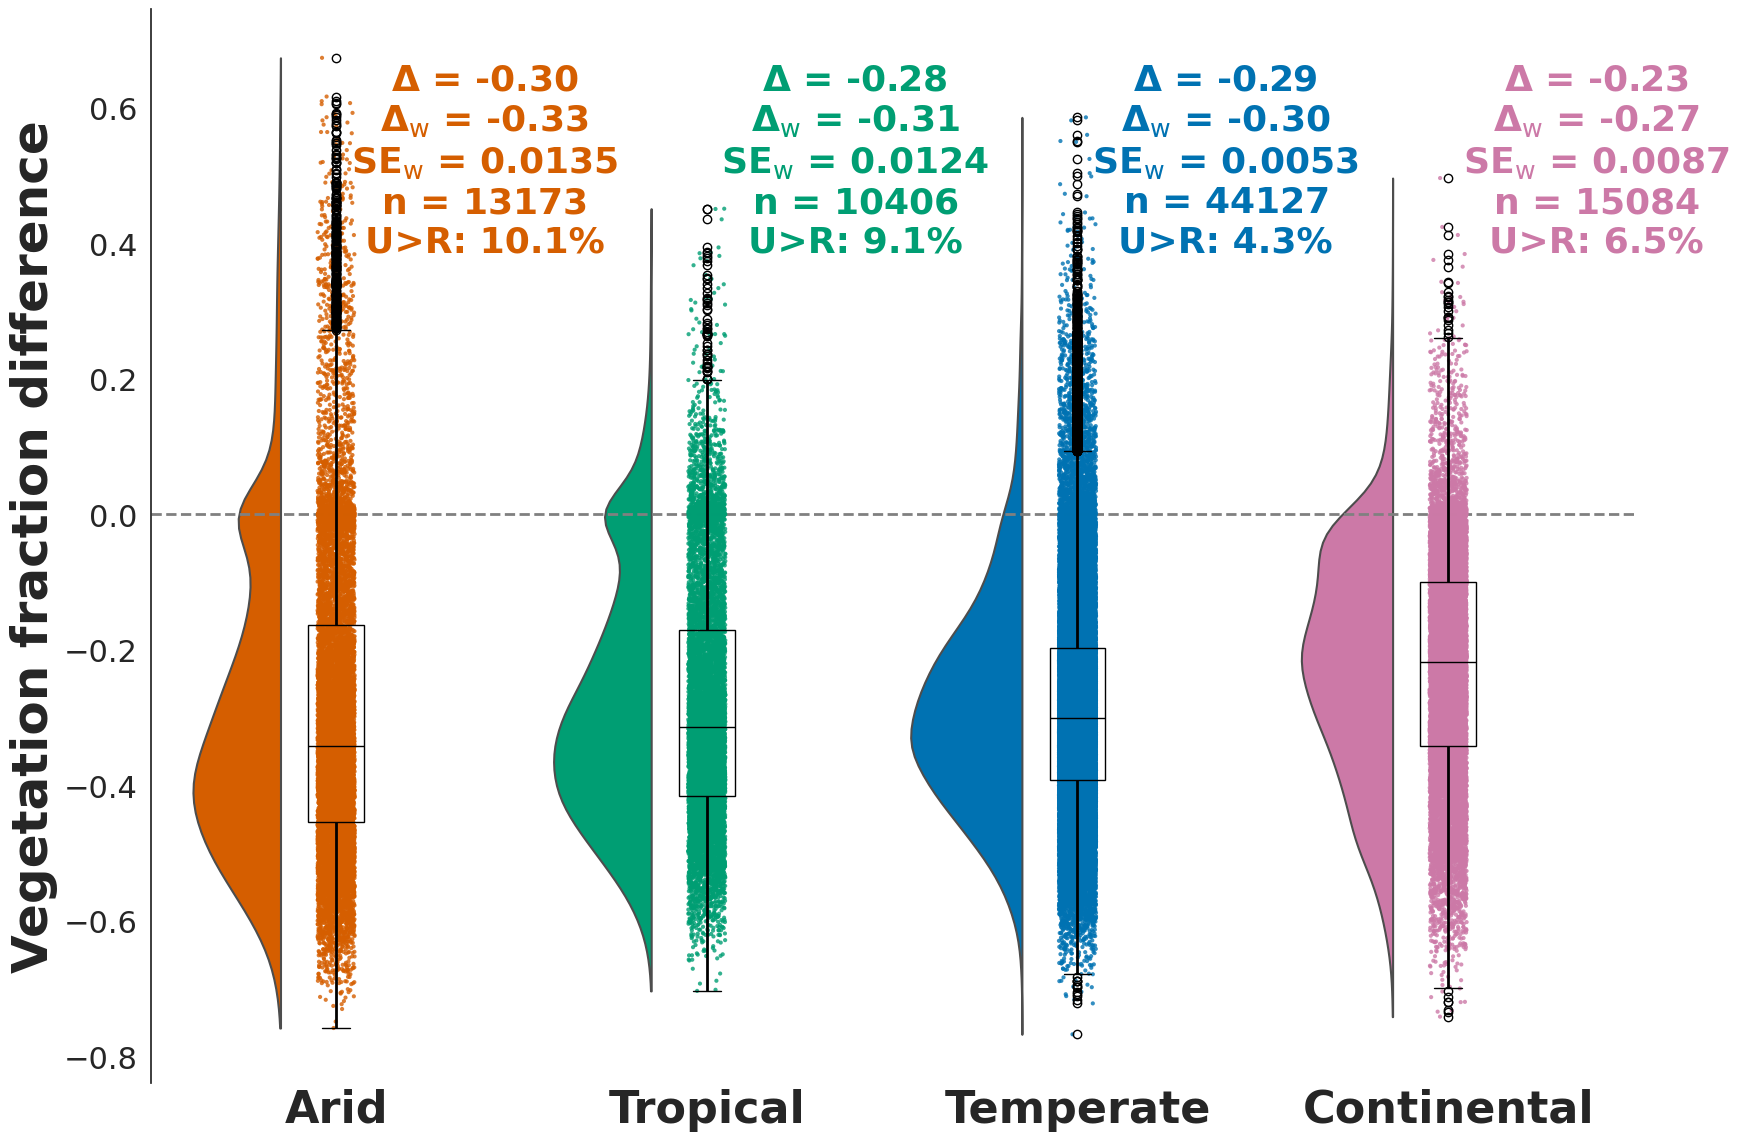


Climate summaries (\bar{μ}, μ, SE_w):
              n_raw  mu_bar  mu_simple    SE_w     n_eff  U>R (%)
Köppen class                                                     
Arid          13173 -0.3296    -0.2957  0.0135  229.3125  10.1344
Tropical      10406 -0.3139    -0.2834  0.0124  203.9048   9.0813
Temperate     44127 -0.3038    -0.2861  0.0053  860.0688   4.3261
Continental   15084 -0.2722    -0.2264  0.0087  302.0870   6.5235


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

# ─────────────────────────────────────────────────────────────────────
# 1) INPUT
# ─────────────────────────────────────────────────────────────────────
CSV_PATH = "/content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries_global_ns.csv"
OUT_PNG  = "/content/Fig1D.pdf"

# ─────────────────────────────────────────────────────────────────────
# 2) CONFIG
# ─────────────────────────────────────────────────────────────────────
VEG_TYPES = {
    "Cropland":            ("cropland_area_urban",           "cropland_area_rural"),
    "Grassland":           ("grassland_area_urban",          "grassland_area_rural"),
    "Herbaceous Wetland":  ("herbaceous_wetland_area_urban", "herbaceous_wetland_area_rural"),
    "Mangroves":           ("mangroves_area_urban",          "mangroves_area_rural"),
    "Moss and Lichen":     ("moss_and_lichen_area_urban",    "moss_and_lichen_area_rural"),
    "Shrubland":           ("shrubland_area_urban",          "shrubland_area_rural"),
    "Tree Cover":          ("tree_cover_area_urban",         "tree_cover_area_rural"),
}
urban_veg_cols = [u for (u, r) in VEG_TYPES.values()]
rural_veg_cols = [r for (u, r) in VEG_TYPES.values()]

REQUIRED = (
    urban_veg_cols + rural_veg_cols +
    ["koppen_name_urban", "lat", "lon", "Urban_Area", "Buffer_area"]
)

KOPPEN_MAP = {"A": "Tropical", "B": "Arid", "C": "Temperate", "D": "Continental"}
ORDER      = ["Arid", "Tropical", "Temperate", "Continental"]
PALETTE    = ["#D55E00", "#009E73", "#0072B2", "#CC79A7"]  # Arid, Tropical, Temperate, Continental

# ─────────────────────────────────────────────────────────────────────
# 3) LOAD + CLEAN
# ─────────────────────────────────────────────────────────────────────
try:
    df = pd.read_csv(CSV_PATH, low_memory=False)
except FileNotFoundError as e:
    raise FileNotFoundError(f"Data file not found: {CSV_PATH}") from e
except Exception as e:
    raise RuntimeError(f"Failed to read CSV: {e}") from e

missing = [c for c in REQUIRED if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Coerce numbers; keep koppen_name_urban as string
for col in REQUIRED:
    if "name" not in col:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Guard denominators
df["Urban_Area"]  = df["Urban_Area"].replace(0, np.nan)
df["Buffer_area"] = df["Buffer_area"].replace(0, np.nan)

df = df.dropna(subset=REQUIRED).copy()
if df.empty:
    raise ValueError("No valid rows after cleaning.")

# ─────────────────────────────────────────────────────────────────────
# 4) CITY-LEVEL FRACTIONS + DIFFERENCE
# ─────────────────────────────────────────────────────────────────────
df["total_veg_urban"] = df[urban_veg_cols].sum(axis=1)
df["total_veg_rural"] = df[rural_veg_cols].sum(axis=1)

df["veg_frac_urban"] = df["total_veg_urban"] / df["Urban_Area"]
df["veg_frac_rural"] = df["total_veg_rural"] / df["Buffer_area"]
df["veg_frac_diff"]  = df["veg_frac_urban"] - df["veg_frac_rural"]

# Köppen class
df["koppen_class"] = df["koppen_name_urban"].astype(str).str[0].map(KOPPEN_MAP)
df = df.dropna(subset=["koppen_class", "veg_frac_diff"]).copy()
df["koppen_class"] = pd.Categorical(df["koppen_class"], categories=ORDER, ordered=True)
df = df.sort_values("koppen_class")

# Weights for climate-level summaries of the *difference*
df["w_diff"] = df["Urban_Area"] + df["Buffer_area"]
df = df[df["w_diff"] > 0].copy()
if df.empty:
    raise ValueError("All rows dropped after enforcing positive weights.")

# ─────────────────────────────────────────────────────────────────────
# 5) AREA-WEIGHTED STATS PER KÖPPEN CLASS (+ U>R %) + SIMPLE MEAN
# ─────────────────────────────────────────────────────────────────────
def weighted_mean_se_with_kish(x: np.ndarray, w: np.ndarray):
    """
    Returns (mean_w, se_w, n_eff). Kish n_eff = (Σw)^2 / Σw^2.
    SE uses var_w = Σ w (x-μ_w)^2 / Σ w, then SE = sqrt(var_w / n_eff).
    """
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[m], w[m]
    if x.size == 0:
        return np.nan, np.nan, 0.0

    W = float(w.sum())
    if W <= 0:
        return np.nan, np.nan, 0.0

    mu_w = float(np.sum(w * x) / W)
    w2 = float(np.sum(w * w))
    n_eff = (W * W) / w2 if w2 > 0 else 0.0

    var_w = float(np.sum(w * (x - mu_w) ** 2) / W)
    se_w = float(np.sqrt(var_w / max(n_eff, 1.0))) if np.isfinite(var_w) else np.nan
    return mu_w, se_w, n_eff

stats_rows = []
for klass, grp in df.groupby("koppen_class", observed=True):
    if grp.empty:
        continue
    x = grp["veg_frac_diff"].to_numpy()
    w = grp["w_diff"].to_numpy()

    mu_w, se_w, n_eff = weighted_mean_se_with_kish(x, w)
    mu_simple = float(np.nanmean(x)) if np.isfinite(x).any() else np.nan
    n_raw  = int(grp.shape[0])
    pct_ur = float((grp["veg_frac_diff"] > 0).mean() * 100.0)  # unweighted share of cities

    stats_rows.append({
        "Köppen class": klass,
        "n_raw": n_raw,
        "mu_bar": mu_w,          # weighted mean
        "mu_simple": mu_simple,  # simple (unweighted) mean
        "SE_w": se_w,
        "n_eff": n_eff,
        "U>R (%)": pct_ur
    })

stats_df = (pd.DataFrame(stats_rows)
              .set_index("Köppen class")
              .reindex(ORDER))

# ─────────────────────────────────────────────────────────────────────
# 6) RAINCLOUD PLOT (distribution unweighted; annotations weighted + simple μ + U>R %)
# ─────────────────────────────────────────────────────────────────────
plt.rcParams.update({"font.size": 26})
fig, ax = plt.subplots(figsize=(18, 12), facecolor='none')  # transparent bg

# RainCloud violins
pt.half_violinplot(
    x="koppen_class", y="veg_frac_diff",
    data=df, palette=PALETTE, bw=.2, cut=0, scale="area",
    width=.6, inner=None, orient="v", ax=ax
)

# Boxplot overlay (unweighted)
sns.boxplot(
    x="koppen_class", y="veg_frac_diff",
    data=df, width=.15, showcaps=True,
    boxprops={"facecolor": "none"},
    whiskerprops={"linewidth": 2},
    capprops={"zorder": 10},
    whis=1.5, color="black", zorder=10, ax=ax
)

# Stripplot overlay
sns.stripplot(
    x="koppen_class", y="veg_frac_diff",
    data=df, palette=PALETTE, jitter=0.05,
    size=3, alpha=0.8, orient="v", ax=ax
)

# Zero line & styling
ax.axhline(y=0, color="gray", linestyle="--", linewidth=2)
ax.grid(False)
for spine in ["top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis='x', length=0)

# Labels
ax.set_ylabel("Vegetation fraction difference", fontsize=36, fontweight="bold")
ax.set_xlabel("")
plt.setp(ax.get_xticklabels(), fontsize=32, fontweight="bold")
plt.yticks(fontsize=22)

# Weighted statistical annotations + simple mean + U>R %
ymin, ymax = ax.get_ylim()
y_text = ymax - 0.05 * (ymax - ymin)

for i, klass in enumerate(ORDER):
    if klass not in stats_df.index or pd.isna(stats_df.loc[klass, "mu_bar"]):
        continue
    n_raw     = int(stats_df.loc[klass, "n_raw"])
    mu_bar    = float(stats_df.loc[klass, "mu_bar"])      # weighted mean
    mu_simple = float(stats_df.loc[klass, "mu_simple"])   # simple mean
    se_w      = float(stats_df.loc[klass, "SE_w"])
    upr       = float(stats_df.loc[klass, "U>R (%)"])

    # Use mathtext for \bar{\Delta}; plain μ for simple mean
    # ann = (
    #     f"n={n_raw}\n"
    #     r"$\bar{\boldsymbol{\Delta}}$" + f"={mu_bar:.2f}\n"
    #     r"$\boldsymbol{\Delta}$" + f"={mu_simple:.2f}\n"
    #     r"$\overline{\mathbf{SE}}$" + f"={se_w:.4f}\n"
    #     f"U>R: {upr:.1f}%"
    # )

    ann = (
        rf"$\boldsymbol{{\Delta}}$ = {mu_simple:.2f}" + "\n" +
        rf"$\boldsymbol{{\Delta}}_{{\mathrm{{w}}}}$ = {mu_bar:.2f}" + "\n" +
        rf"$\mathbf{{SE}}_{{\mathrm{{w}}}}$ = {se_w:.4f}" + "\n" +
        rf"$\mathbf{{n}}$ = {n_raw}" + "\n" +
        f"U>R: {upr:.1f}%"
    )

    ax.text(
        i + 0.4, y_text, ann,
        ha='center', va='top',
        fontsize=26, fontweight='bold',
        color=PALETTE[i]
    )

plt.tight_layout()
try:
    fig.savefig(OUT_PNG, bbox_inches="tight", transparent=True)
    print(f"[OK] Figure saved → {OUT_PNG}")
finally:
    plt.show()

# ─────────────────────────────────────────────────────────────────────
# 7) SUMMARY TABLE
# ─────────────────────────────────────────────────────────────────────
disp = stats_df.loc[ORDER, ["n_raw", "mu_bar", "mu_simple", "SE_w", "n_eff", "U>R (%)"]]
with pd.option_context("display.precision", 4):
    print("\nClimate summaries (\\bar{μ}, μ, SE_w):")
    print(disp.to_string())


#combined

[INFO] Dropped 2,761 row(s) with invalid/missing GlobalNS.
[Global North] n_raw=30621, n_eff=427.5, mu_w=0.4558, SE_w=0.0090
[Global South] n_raw=49720, n_eff=1134.0, mu_w=0.3114, SE_w=0.0062
[OK] Figure saved to /content/Fig1C.pdf


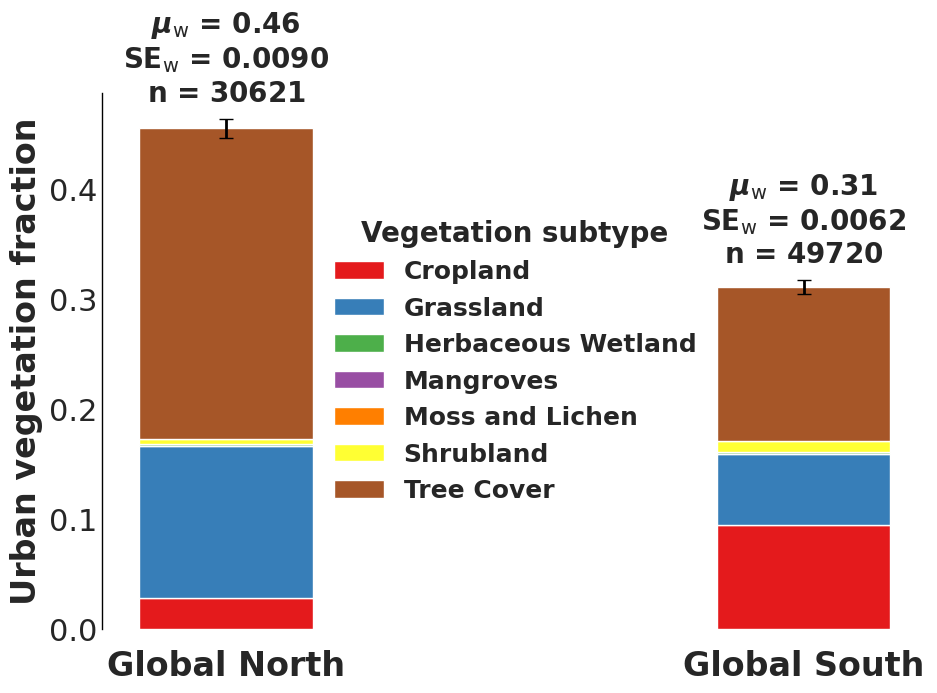

In [23]:
import sys
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# ---------------------------------------------------------------------
# 1. CONFIGURATION
# ---------------------------------------------------------------------
CSV_PATH = Path(
    "/content/combinedFeatures_VegBiomeKoppen_withLatLon_with_countries_global_ns.csv"
)
OUT_PNG = Path(
    "/content/Fig1C.pdf"
)

# Only the urban columns for each vegetation type
URBAN_VEG_TYPES: Dict[str, str] = {
    "Cropland":            "cropland_area_urban",
    "Grassland":           "grassland_area_urban",
    "Herbaceous Wetland":  "herbaceous_wetland_area_urban",
    "Mangroves":           "mangroves_area_urban",
    "Moss and Lichen":     "moss_and_lichen_area_urban",
    "Shrubland":           "shrubland_area_urban",
    "Tree Cover":          "tree_cover_area_urban",
}

COLORS: Dict[str, str] = {
    "Cropland":           "#e41a1c",
    "Grassland":          "#377eb8",
    "Herbaceous Wetland": "#4daf4a",
    "Mangroves":          "#984ea3",
    "Moss and Lichen":    "#ff7f00",
    "Shrubland":          "#ffff33",
    "Tree Cover":         "#a65628",
}

# ---------------------------------------------------------------------
# 2. I/O & VALIDATION
# ---------------------------------------------------------------------
def read_csv(csv_path: Path) -> pd.DataFrame:
    if not csv_path.exists():
        raise FileNotFoundError(f"CSV not found: {csv_path}")
    try:
        df = pd.read_csv(csv_path, low_memory=False)
    except Exception as exc:
        raise IOError(f"Failed reading CSV: {exc}")
    if df.empty:
        raise ValueError(f"CSV is empty: {csv_path}")
    return df


def drop_invalid_globalns(df: pd.DataFrame) -> pd.DataFrame:
    if "GlobalNS" not in df.columns:
        raise ValueError("Required column 'GlobalNS' not found.")
    df["GlobalNS_clean"] = df["GlobalNS"].astype(str).str.strip().str.title()
    valid = df["GlobalNS_clean"].isin({"North", "South"})
    dropped = int((~valid).sum())
    if dropped:
        print(f"[INFO] Dropped {dropped:,} row(s) with invalid/missing GlobalNS.")
    return df.loc[valid].copy()


def ensure_columns(df: pd.DataFrame) -> None:
    required = {"GlobalNS", "Urban_Area"} | set(URBAN_VEG_TYPES.values())
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"CSV missing required columns: {sorted(missing)}")
    # Optional heads-up if a color key is missing
    missing_colors = set(URBAN_VEG_TYPES.keys()) - set(COLORS.keys())
    if missing_colors:
        print(f"[WARN] COLORS missing entries for: {sorted(missing_colors)}")


# ---------------------------------------------------------------------
# 3. PREP + AREA-WEIGHT HELPERS
# ---------------------------------------------------------------------
def _weighted_mean_se_kish(x: np.ndarray, w: np.ndarray) -> Tuple[float, float, float]:
    """
    Area-weighted mean and SE for per-city fractions, using Kish n_eff.
    Returns: mean_w, se_w, n_eff
    """
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[m], w[m]
    if x.size == 0:
        return np.nan, np.nan, 0.0

    W = float(w.sum())
    mean_w = float(np.sum(w * x) / W)

    w2 = float(np.sum(w * w))
    n_eff = (W * W) / w2 if w2 > 0 else 0.0

    var_w = float(np.sum(w * (x - mean_w) ** 2) / W) if W > 0 else np.nan
    se_w = float(np.sqrt(var_w / max(n_eff, 1.0))) if np.isfinite(var_w) else np.nan
    return mean_w, se_w, n_eff


def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # Map region labels
    df["region"] = df["GlobalNS_clean"].map({
        "North": "Global North",
        "South": "Global South"
    })

    # Ensure numeric types
    num_cols = ["Urban_Area"] + list(URBAN_VEG_TYPES.values())
    for c in num_cols:
        if c not in df.columns:
            raise ValueError(f"Required numeric column missing: {c}")
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

    # Drop rows with NaNs in critical numeric columns
    before = len(df)
    df = df.dropna(subset=num_cols).reset_index(drop=True)
    if len(df) < before:
        print(f"[INFO] Dropped {before - len(df):,} row(s) with NaNs in numeric fields.")

    # Aggregate per-row urban vegetation area and fraction
    df["vegetation_area_urban"] = df[list(URBAN_VEG_TYPES.values())].sum(axis=1)

    # Guard against zero or negative Urban_Area
    bad_area = (df["Urban_Area"] <= 0).sum()
    if bad_area:
        print(f"[WARN] {bad_area:,} row(s) with non-positive Urban_Area; dropping.")
        df = df.loc[df["Urban_Area"] > 0].copy()

    df["vegetation_fraction_urban"] = df["vegetation_area_urban"] / df["Urban_Area"]

    # Ensure finite fractions
    df = df[np.isfinite(df["vegetation_fraction_urban"])].copy()
    if df.empty:
        raise ValueError("No valid records remain after cleaning.")

    return df


# ---------------------------------------------------------------------
# 4. AGGREGATE (COMPOSITION + AREA-WEIGHTED μ/SE)
# ---------------------------------------------------------------------
def aggregate(df: pd.DataFrame):
    regions = ["Global North", "Global South"]
    bar_data = {}
    stats_w_rows = []

    for region in regions:
        subset = df[df["region"] == region]
        total_urb_area = subset["Urban_Area"].sum()

        # Stacked composition (ratio-of-sums; already area-weighted)
        if total_urb_area <= 0:
            print(f"[WARN] Total Urban_Area <= 0 for region '{region}'. Using zeros.")
            class_fracs = {veg: 0.0 for veg in URBAN_VEG_TYPES.keys()}
        else:
            class_fracs = {
                veg: subset[urb_col].sum() / total_urb_area
                for veg, urb_col in URBAN_VEG_TYPES.items()
            }
        bar_data[region] = class_fracs

        # Area-weighted μ/SE for city-level urban vegetation fraction
        mean_w, se_w, n_eff = _weighted_mean_se_kish(
            subset["vegetation_fraction_urban"].to_numpy(),
            subset["Urban_Area"].to_numpy()
        )
        n_raw = int(subset.shape[0])

        stats_w_rows.append({
            "region": region,
            "mean_w": mean_w,
            "se_w": se_w,
            "n_eff": n_eff,
            "n_raw": n_raw
        })

    veg_df = pd.DataFrame.from_dict(bar_data, orient="index")[list(URBAN_VEG_TYPES.keys())]
    # Total stacked height equals the ratio-of-sums urban vegetation fraction
    total_frac = veg_df.sum(axis=1)

    stats_w = pd.DataFrame(stats_w_rows).set_index("region").loc[regions]

    return veg_df, total_frac, stats_w


# ---------------------------------------------------------------------
# 5. PLOT (uses **area-weighted** SE for error bars)
# ---------------------------------------------------------------------
def plot_figure(veg_df: pd.DataFrame, total_frac: pd.Series,
                stats_w: pd.DataFrame, out_png: Path):
    if veg_df.empty or total_frac.empty or stats_w.empty:
        raise ValueError("Empty inputs to plot_figure.")

    fig, ax = plt.subplots(figsize=(10, 7.5))
    pos = np.arange(len(veg_df))
    width = 0.3
    cum_bottom = np.zeros(len(veg_df))

    # Stacked bars by vegetation subtype
    for veg in URBAN_VEG_TYPES.keys():
        vals = veg_df[veg].values
        color = COLORS.get(veg, "#999999")
        ax.bar(pos, vals, width, bottom=cum_bottom, color=color, label=veg)
        cum_bottom += vals

    # Error bars & annotations (AREA-WEIGHTED)
    for i, region in enumerate(veg_df.index):
        mean_w = float(stats_w.loc[region, "mean_w"])
        se_w   = float(stats_w.loc[region, "se_w"])
        n_raw  = int(stats_w.loc[region, "n_raw"])
        n_eff  = float(stats_w.loc[region, "n_eff"])

        # Total stacked height should equal mean_w (ratio-of-sums == weighted mean)
        y = float(total_frac[region])

        # yerr needs finite float; replace NaN with 0 for plotting
        se_plot = 0.0 if not np.isfinite(se_w) else se_w

        ax.errorbar(
            pos[i], y,
            yerr=se_plot, fmt="none",
            ecolor="black", capsize=5, elinewidth=2
        )

        # Place label slightly above (use se if finite, else small offset)
        offset = se_plot if se_plot > 0 else 0.01
        label_se = "nan" if not np.isfinite(se_w) else f"{se_w:.4f}"

        # # --- Updated annotation with subscripts: μ_w and SE_w ---
        # ax.text(
        #     pos[i], y + offset + 0.01,
        #     rf"$\mu_{{\mathrm{{w}}}}$={mean_w:.2f}" + "\n" +
        #     rf"$\mathrm{{SE}}_{{\mathrm{{w}}}}$={label_se}" + "\n" +
        #     f"n={n_raw}",
        #     ha="center", va="bottom",
        #     fontsize=20, fontweight="bold"
        # )

        ax.text(
            pos[i], y + offset + 0.01,
            rf"$\boldsymbol{{\mu}}_{{\mathrm{{w}}}}$ = {mean_w:.2f}" + "\n" +
            rf"$\mathbf{{SE}}_{{\mathrm{{w}}}}$ = {label_se}" + "\n" +
            rf"$\mathbf{{n}}$ = {n_raw}",
            ha="center", va="bottom",
            fontsize=20, fontweight="bold"
        )

        # Console transparency
        print(f"[{region}] n_raw={n_raw}, n_eff={n_eff:.1f}, mu_w={mean_w:.4f}, SE_w={se_w:.4f}")

    # Aesthetics
    ax.grid(False)
    ax.set_xticks(pos)
    ax.set_xticklabels(veg_df.index, fontsize=24, fontweight="bold")
    ax.tick_params(axis="x", pad=15)
    ax.set_ylabel("Urban vegetation fraction", fontsize=24, fontweight="bold")
    ax.tick_params(axis="y", labelsize=22)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("black")
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_linewidth(1)
    ax.tick_params(axis="both", length=0)

    # Bold legend title
    bold_font = fm.FontProperties(weight="bold", size=18)
    bold_title_font = fm.FontProperties(weight="bold", size=20)

    ax.legend(
        title="Vegetation subtype",
        title_fontproperties=bold_title_font,
        prop=bold_font,
        loc="center",
        bbox_to_anchor=(0.5, 0.5),
        frameon=False,
        bbox_transform=ax.transAxes
    )

    plt.tight_layout()
    try:
        out_png.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out_png, bbox_inches="tight", transparent=True)
        print(f"[OK] Figure saved to {out_png}")
    except Exception as exc:
        print(f"[ERROR] Could not save figure: {exc}", file=sys.stderr)
    finally:
        plt.show()
        plt.close(fig)


# ---------------------------------------------------------------------
# 6. MAIN
# ---------------------------------------------------------------------
if __name__ == "__main__":
    try:
        df0 = read_csv(CSV_PATH)
        ensure_columns(df0)
        df1 = drop_invalid_globalns(df0)
        df  = prepare_dataframe(df1)
        veg_df, total_frac, stats_w = aggregate(df)
        # Enforce order
        idx_order = ["Global North", "Global South"]
        veg_df = veg_df.reindex(idx_order)
        total_frac = total_frac.reindex(idx_order)
        stats_w = stats_w.reindex(idx_order)
        plot_figure(veg_df, total_frac, stats_w, OUT_PNG)
    except Exception as err:
        print(f"[ERROR] {err}", file=sys.stderr)
        sys.exit(1)
